## FORMULA 1 
### Analysis of race results from 2015 to 2017 season

In [1]:
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from itertools import groupby
import pickle
import os
import math
from sympy import S, symbols
from string import digits
from numpy import *

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
#sns.mpl.rcParams['figure.figsize'] = (16, 10)

# Directory to store pickled dataframes
directory = '/Users/dianaow/Documents/formula-1-race-data/dataframes/'

In [2]:
sns.set(rc={"font.style":"normal",
            "axes.facecolor":(0.9, 0.9, 0.9),
            "figure.facecolor":'white',
            "grid.color":'black',
            "grid.linestyle":':',
            "axes.grid":True,
            'axes.labelsize':30,
            'figure.figsize':(20.0, 15.0),
            'xtick.labelsize':20,
            'ytick.labelsize':20,
           })

current_palette = sns.color_palette("hls", 7)

In [3]:
def read_from_pickle(directory, filename):
    df = pd.DataFrame()
    filepath = directory + filename
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
            
    return df

### Read in the CSV files.
#### (CSV files are downloaded from https://www.kaggle.com/cjgdev/formula-1-race-data-19502017)

In [5]:
df_results = pd.read_csv('./formula-1-race-data/results.csv')
df_circuits = pd.read_csv('./formula-1-race-data/circuits.csv')
df_constructors = pd.read_csv('./formula-1-race-data/constructors.csv')
df_drivers = pd.read_csv('./formula-1-race-data/drivers.csv')
df_driverStandings = pd.read_csv('./formula-1-race-data/driverStandings.csv')
df_lapTimes = pd.read_csv('./formula-1-race-data/lapTimes.csv')
df_pitStops = pd.read_csv('./formula-1-race-data/pitStops.csv')
df_qualifying = pd.read_csv('./formula-1-race-data/qualifying.csv')
df_races = pd.read_csv('./formula-1-race-data/races.csv')
df_results = pd.read_csv('./formula-1-race-data/results.csv')
df_seasons = pd.read_csv('./formula-1-race-data/seasons.csv')
df_status = pd.read_csv('./formula-1-race-data/status.csv')

In [ ]:
# Some drivers have the same surnames, resolve this by replacing driverRef of the non-current driver with the full name

df_drivers.replace("max_verstappen", "verstappen", inplace=True)
df_drivers.replace("jolyon_palmer", "palmer", inplace=True)
df_drivers.replace("kevin_magnussen", "magnussen", inplace=True)
df_drivers.replace("brandon_hartley", "hartley", inplace=True)

df_drivers.loc[75, "driverRef"] = 'jan_magnussen'
df_drivers.loc[49, "driverRef"] = 'jos_verstappen'
df_drivers.loc[155, "driverRef"] = 'jonathan_palmer'
df_drivers.loc[155, "driverRef"] = 'jonathan_palmer'
df_drivers.loc[813, "driverRef"] = 'di resta'

df_races.loc[942, "name"] = "Azerbaijan Grand Prix"

In [9]:
df_races = df_races[df_races['year'] < 2018]
df_races.tail(2)

raceId  year  round  circuitId                  name        date  \
974     987  2017     19         18  Brazilian Grand Prix  2017-11-12   
975     988  2017     20         24  Abu Dhabi Grand Prix  2017-11-26   

         time                                                url  
974  16:00:00  https://en.wikipedia.org/wiki/2017_Brazilian_G...  
975  13:00:00  https://en.wikipedia.org/wiki/2017_Abu_Dhabi_G...

In [11]:
max_laps = pd.DataFrame()
max_laps["total laps"] = df_results.groupby("raceId").laps.max()
max_laps = max_laps.reset_index()
df_races_maxlaps = pd.merge(df_races, max_laps, on='raceId', how='left')
df_races_maxlaps = df_races_maxlaps[['raceId', 'year', 'name', 'total laps']]

# Categorize the races according to the number of laps
for i,row in df_races_maxlaps.iterrows():
    if df_races_maxlaps.loc[i,'total laps'] <=50 :
        df_races_maxlaps.loc[i,'category'] = "<=50"
    elif (df_races_maxlaps.loc[i,'total laps'] > 50) & (df_races_maxlaps.loc[i,'total laps'] <= 55):
        df_races_maxlaps.loc[i,'category'] = ">50 & <= 55"
    elif (df_races_maxlaps.loc[i,'total laps'] > 55) & (df_races_maxlaps.loc[i,'total laps'] <= 61):
        df_races_maxlaps.loc[i,'category'] = ">55 & <= 61"
    elif (df_races_maxlaps.loc[i,'total laps'] == 66):
        df_races_maxlaps.loc[i,'category'] = "66"
    elif (df_races_maxlaps.loc[i,'total laps'] >= 70) & (df_races_maxlaps.loc[i,'total laps'] <= 71):
        df_races_maxlaps.loc[i,'category'] = ">=70 & <= 71"
    elif (df_races_maxlaps.loc[i,'total laps'] == 78):
        df_races_maxlaps.loc[i,'category'] = "78"
             
df_races_maxlaps.to_pickle(os.path.join(directory,  "df_races_maxlaps.pickle"))

In [22]:
# Extract the names and ids of races for each season

races_names_2015 = list(df_races[df_races['year'] == 2015].name.unique())
races_ids_2015 = list(df_races[df_races['year'] == 2015].raceId.unique())
races_names_2016 = list(df_races[df_races['year'] == 2016].name.unique())
races_ids_2016 = list(df_races[df_races['year'] == 2016].raceId.unique())
races_names_2017 = list(df_races[df_races['year'] == 2017].name.unique())
races_ids_2017 = list(df_races[df_races['year'] == 2017].raceId.unique())

tyre_types = ['Soft', 'Super soft', 'Ultra soft', 'Wet', 'Intermediate', 'Medium', 'Hard']
stints = [1,2,3,4]

In [23]:
# Extract the names and ids of drivers for each season

df_results_2015 = df_results[df_results['raceId'].isin(races_ids_2015)]
drivers_ids_2015 = df_results_2015.driverId.unique()
df_results_2016 = df_results[df_results['raceId'].isin(races_ids_2016)]
drivers_ids_2016 = df_results_2016.driverId.unique()
df_results_2017 = df_results[df_results['raceId'].isin(races_ids_2017)]
drivers_ids_2017 = df_results_2017.driverId.unique()

### RACE LAPTIMES

In [32]:
# year input variable must be an integer in a list eg [2016]

def filter_laptimes(df_lapTimes, year, race_name, driver_name):
    """Returns a dataframe filtered by year (eg 2016) and name of race (eg "Australian Grand Prix")"""

    df_race = df_races[df_races['year'].isin(year)]
    df_lapTimes_race = df_lapTimes.loc[df_lapTimes['raceId'].isin(df_race['raceId'])]
    df_M_lapTimes_race = pd.merge(df_lapTimes_race, df_race.loc[:,['name', 'raceId']], on='raceId')
    drivers_ids = df_M_lapTimes_race['driverId'].unique()
    df_drivers_year = df_drivers.loc[df_drivers['driverId'].isin(drivers_ids)]
    df_laptimes_race_drivers = pd.merge(df_M_lapTimes_race, df_drivers_year.loc[:,['driverId', 'driverRef']], on='driverId')
    
    if race_name and driver_name:
        grouped_race = df_laptimes_race_drivers.groupby("name").get_group(race_name)
        data = grouped_race.groupby("driverRef").get_group(driver_name)
    elif race_name:
        data = df_laptimes_race_drivers.groupby("name").get_group(race_name)
    elif driver_name: 
        data = df_laptimes_race_drivers.groupby("driverRef").get_group(driver_name)
    else: 
        data = df_laptimes_race_drivers
        
    return data

In [33]:
def filter_outliers_percentile(data, time_field='milliseconds', id_field='driverRef'):
    """Returns a logical vector corresponding to the outliers (based on percentiles) for each driver. True values are the outliers"""

    time75, time25 = np.percentile(data[time_field], [75 ,25])
    iqrtime = time75 - time25        
    timemin = time25-(iqrtime*1.5)   
    timemax = time75+(iqrtime*1.5) 

    outliers = lambda x: (
        (x < timemin) |
        (x > timemax)
    )
    
    df_outlier = data.groupby(id_field)[[time_field]].apply(outliers).rename(columns = {"milliseconds":"outlier"})
    data = pd.merge(data, df_outlier, left_index = True, right_index = True)
    data = data[data['outlier'] == False]
    data = data[data['lap'] != 1]
    
    return data

In [26]:
def filter_outliers_timediff(data, time_field='milliseconds', id_field='driverRef'):
    """Returns a logical vector corresponding to the outliers (time diff between next lap more than 1000ms) for each driver."""

    def time_diff(df):
        df['time_diff'] = df['milliseconds'].diff()
        return df
    
    data = data.groupby(id_field).apply(time_diff).reset_index()
    data['time_diff'] = abs(data['time_diff'])
    data['outlier'] = (data['time_diff'] > 1000)
    data = data[data['outlier'] == False]
    data = data[data['lap'] != 1]

    return data

In [27]:
def filter_layer(data, df_pitStops, function, time_field='milliseconds', id_field='driverRef'):
    
    filtered1 = function(data, time_field, id_field)
    filtered2 = filter_pitlap_inlap_outlap(data, df_pitStops)
    
    filtered1_mapped = pd.merge(data, filtered1[['driverId', "raceId", "lap", "outlier"]], on=['driverId', "raceId", "lap"])
    filtered2_mapped = pd.merge(filtered1_mapped, filtered2[['driverId', "raceId", "lap", "pitlaps/inlaps/outlaps"]], on=['driverId', "raceId", "lap"])
    
    return filtered2_mapped

## PIT LAPS

In [39]:
def filter_pitlaps(year, race_name, driver_name, df_pitStops = df_pitStops):
    
    df_pitStops = pd.merge(df_pitStops, df_races[['raceId', 'year', 'name']], on='raceId')

    df_race = df_pitStops[df_pitStops['year'].isin(year)]
    df_pitStops_race = df_pitStops.loc[df_pitStops['raceId'].isin(df_race['raceId'])]
    drivers_ids = df_pitStops_race['driverId'].unique()
    df_drivers_year = df_drivers.loc[df_drivers['driverId'].isin(drivers_ids)]
    df_pitStops_race_drivers = pd.merge(df_pitStops_race, df_drivers_year.loc[:,['driverId', 'driverRef']], on='driverId').sort_values(['raceId', 'driverId', 'lap'])
                                        
    if race_name and driver_name:
        grouped_race = df_pitStops_race_drivers.groupby("name").get_group(race_name)
        data = grouped_race.groupby("driverRef").get_group(driver_name)
    elif race_name:
        data = df_pitStops_race_drivers.groupby("name").get_group(race_name)
    elif driver_name: 
        data = df_pitStops_race_drivers.groupby("driverRef").get_group(driver_name)
    else: 
        data = df_pitStops_race 

    return data

In [54]:
def filter_pitlap_inlap_outlap(df, df_pitStops):
    
    df_pitStops = pd.merge(df_pitStops, df_races[['raceId', 'year', 'name']], on='raceId')
    
    inlaps = pd.DataFrame()
    inlaps['lap'] = df_pitStops['lap'] - 1 
    inlaps["raceId"] = df_pitStops['raceId']
    inlaps["driverId"] = df_pitStops['driverId'] 
    inlaps = pd.merge(inlaps, df_races[['raceId', 'year', 'name']], on='raceId')
    
    outlaps = pd.DataFrame()
    outlaps["lap"] = df_pitStops['lap'] + 1 
    outlaps["raceId"] = df_pitStops['raceId']
    outlaps["driverId"] = df_pitStops['driverId'] 
    outlaps = pd.merge(outlaps, df_races[['raceId', 'year', 'name']], on='raceId')
    
    tofilter = pd.concat([df_pitStops, inlaps])
    #tofilter = pd.concat([tofilter, outlaps])
    df_race = pd.merge(tofilter, df_drivers[['driverId', 'driverRef']], on='driverId')
    df_race['pitlaps/inlaps/outlaps'] = "yes"

    mapped = pd.merge(df, df_race[['driverId', 'raceId', 'lap', 'pitlaps/inlaps/outlaps']], on=['driverId', 'raceId', 'lap'], how='left')
    filtered = mapped[mapped['pitlaps/inlaps/outlaps'] != 'yes']
    
    return filtered

In [55]:
pitlaps_151617 = filter_pitlaps([2015, 2016, 2017], "", "", df_pitStops = df_pitStops)
df_status = pd.merge(pitlaps_151617[['raceId', 'driverId', 'stop']], df_results[['raceId', 'driverId', 'statusId', 'laps']], on=['raceId', 'driverId'], how='left')
df_status['is_duplicated'] = df_status.sort_values('stop', ascending=False).duplicated(subset=['raceId', 'driverId'], keep='first')
df_status = df_status[df_status['is_duplicated'] == False].drop(['is_duplicated'], axis=1)

## SAFETY CAR LAPS

In [56]:
xl = pd.ExcelFile("./formula-1-race-data/SC_lap_numbers.xlsx", encoding='utf-8')
xl.sheet_names
sc_laps = xl.parse("Safety car laps")
sc_laps.fillna(0, inplace=True)

In [57]:
def filter_SClaps(sc_laps, df):
    
    sc_laps = pd.merge(sc_laps, df_races[['year', 'name', 'raceId']], on=['year', 'name'], how='left')
    sc_laps = pd.merge(df, sc_laps, on=['raceId', 'name'], how='left')
    for i,row in sc_laps.iterrows():
        if (sc_laps.loc[i,"lap"] >= sc_laps.loc[i,"SC start 1"]) & (sc_laps.loc[i,"lap"] <= sc_laps.loc[i,"SC end 1"]):
            sc_laps.loc[i,"SC lap"] = "Yes"
        elif (sc_laps.loc[i,"lap"] >= sc_laps.loc[i,"SC start 2"]) & (sc_laps.loc[i,"lap"] <= sc_laps.loc[i,"SC end 2"]):
            sc_laps.loc[i,"SC lap"] = "Yes"
        elif (sc_laps.loc[i,"lap"] >= sc_laps.loc[i,"SC start 3"]) & (sc_laps.loc[i,"lap"] <= sc_laps.loc[i,"SC end 3"]):
            sc_laps.loc[i,"SC lap"] = "Yes"
        else:
            sc_laps.loc[i,"SC lap"] = "No"

    sc_laps = sc_laps[sc_laps['SC lap'] == "No"]
    
    sc_laps = sc_laps.drop(['SC start 1', 'SC end 1', 'SC start 2', 'SC end 2', 'SC start 3', 'SC end 3', 'First lap crash', 'SC lap'], axis=1)
    
    return sc_laps

## TYRE USE

In [104]:
import pandas as pd
xl = pd.ExcelFile("./formula-1-race-data/Tyre_Information.xlsx", encoding='utf-8')
xl.sheet_names
tyres = xl.parse("Sheet2")

In [105]:
tyres.replace('Super Soft', 'Super soft',inplace=True)
tyres.replace('Ultra Soft', 'Ultra soft',inplace=True)

In [87]:
def tyre_use_race(df, year, race_name, driver_name):
    
    df = df.iloc[:, 0:16]
    df.columns = [x.lower() for x in df.columns]
    df = df.loc[df['year'].isin(year)]
    df["driverRef"] = [row.split(' ', 1 )[1].lower() for row in df['driver']]
    df = df.rename(columns = {'race': 'name'})
    
    df['first set'].fillna("None", inplace = True)
    df['second set'].fillna("None", inplace = True)
    df['third set'].fillna("None", inplace = True)
    df['fourth set'].fillna("None", inplace = True)
    df['fifth set'].fillna("None", inplace = True)
    df['sixth set'].fillna("None", inplace = True)
    
    df['first set'] = df['first set'].str.strip()
    df['second set'] = df['second set'].str.strip()
    df['third set'] = df['third set'].str.strip()
    df['fourth set'] = df['fourth set'].str.strip()
    df['fifth set'] = df['fifth set'].str.strip()
    df['sixth set'] = df['sixth set'].str.strip()
    
    df['stint'].fillna(0, inplace = True)
    df['stint.1'].fillna(0, inplace = True)
    df['stint.2'].fillna(0, inplace = True)
    df['stint.3'].fillna(0, inplace = True)
    df['stint.4'].fillna(0, inplace = True)
    df['stint.5'].fillna(0, inplace = True)

    if race_name and driver_name:
        grouped_race = df.groupby("name").get_group(race_name)
        df = grouped_race.groupby("driverRef").get_group(driver_name)
    elif race_name:
        df = df.groupby("name").get_group(race_name)
    elif driver_name: 
        df = df.groupby("driverRef").get_group(driver_name)
    
    df = pd.merge(df, df_races[["year", "name", "raceId"]], left_on=['year', 'name'], right_on=['year', 'name'])
    df = pd.merge(df, df_drivers[['driverRef', 'driverId']], left_on=['driverRef'], right_on=['driverRef'])
    df = df.rename(columns={'stint': 'stint 1', 'stint.1': 'stint 2', 
                            'stint.2': 'stint 3', 'stint.3': 'stint 4',
                            'stint.4': 'stint 5', 'stint.5': 'stint 6'})
    df.drop('driver', axis=1, inplace=True)
        
    dcr = pd.merge(df_results[['driverId', 'constructorId', 'raceId']], df_drivers[['driverId', 'driverRef']], on=['driverId'], how='left')
    dcrm = pd.merge(dcr, df_races[['raceId', 'year', 'name']], on=['raceId'], how='left')
    dcrm = pd.merge(dcrm, df_constructors[['constructorId', 'constructorRef']], on=['constructorId'], how='left')
    df = pd.merge(df, dcrm, on=['year', 'name', 'driverRef', 'raceId', 'driverId'], how='left')

    return df

In [68]:
df_tyres = tyre_use_race(tyres, [2015, 2016, 2017], "", "")
df_tyres.to_pickle(os.path.join(directory,  "df_tyres.pickle"))

In [69]:
def no_unfinished_stints(df, df_status):
    """Function to remove laps of an incomplete stint"""
    
    df = pd.merge(df, df_status, on=["raceId", "driverId"], how='left')
    df = df[df["stop"].notnull()]
    for i, row in df.iterrows():
        X = "unfinished"
        if row['statusId'] != 1.:
            if row['stop'] == 3.:
                df.loc[i, 'stint 4']=np.nan
                df.loc[i, 'fourth set']= np.nan
            elif row['stop'] == 2.:
                df.loc[i, 'stint 3']=np.nan
                df.loc[i, 'third set']= np.nan
            elif row['stop'] == 1.:
                df.loc[i, 'stint 2']=np.nan
                df.loc[i, 'second set']= np.nan 
            elif row['stop'] == 0.:
                df.loc[i, 'stint 1']=np.nan
                df.loc[i, 'first set']= np.nan

    return df

In [70]:
def tyre_use_race_laptimes(df, df_tyres):
    """Function to create/merge tyre information for each lap to race laptimes"""
    
    df = pd.merge(df, df_tyres, on=['raceId', 'driverId', 'name', 'driverRef', 'year'])
    
    df['stint 1+2'] = df['stint 1'] + df['stint 2']
    df['stint 1+2+3'] = df['stint 1'] + df['stint 2'] + df['stint 3']
    df['stint 1+2+3+4'] = df['stint 1'] + df['stint 2'] + df['stint 3'] + df['stint 4']
    df['stint 1+2+3+4+5'] = df['stint 1'] + df['stint 2'] + df['stint 3'] + df['stint 4'] + df['stint 5']
    df['stint 1+2+3+4+5+6'] = df['stint 1'] + df['stint 2'] + df['stint 3'] + df['stint 4'] + df['stint 5'] + df['stint 6']
    
    df['tyre'] = np.where((df['lap'] <= df['stint 1']), df['first set'], np.nan)
    df['tyre2'] = np.where((df['lap'] > df['stint 1']) & (df['lap'] <= df['stint 1+2']), df['second set'], np.nan)
    df['tyre3'] = np.where((df['lap'] > df['stint 1+2']) & (df['lap'] <= df['stint 1+2+3']), df['third set'], np.nan)
    df['tyre4'] = np.where((df['lap'] > df['stint 1+2+3']) & (df['lap'] <= df['stint 1+2+3+4']), df['fourth set'], np.nan)
    df['tyre5'] = np.where((df['lap'] > df['stint 1+2+3+4']) & (df['lap'] <= df['stint 1+2+3+4+5']), df['fifth set'], np.nan)
    df['tyre6'] = np.where((df['lap'] > df['stint 1+2+3+4+5']) & (df['lap'] <= df['stint 1+2+3+4+5+6']), df['fifth set'], np.nan)
    
    df['tyre'].fillna(df['tyre2'], inplace=True)
    df['tyre'].fillna(df['tyre3'], inplace=True)
    df['tyre'].fillna(df['tyre4'], inplace=True)
    df['tyre'].fillna(df['tyre5'], inplace=True)
    df['tyre'].fillna(df['tyre6'], inplace=True)
    
    df['stint'] = np.where((df['lap'] <= df['stint 1']), 1, np.nan)
    df['stint2'] = np.where((df['lap'] > df['stint 1']) & (df['lap'] <= df['stint 1+2']), 2, np.nan)
    df['stint3'] = np.where((df['lap'] > df['stint 1+2']) & (df['lap'] <= df['stint 1+2+3']), 3, np.nan)
    df['stint4'] = np.where((df['lap'] > df['stint 1+2+3']) & (df['lap'] <= df['stint 1+2+3+4']), 4, np.nan)
    df['stint5'] = np.where((df['lap'] > df['stint 1+2+3+4']) & (df['lap'] <= df['stint 1+2+3+4+5']), 5, np.nan)
    df['stint6'] = np.where((df['lap'] > df['stint 1+2+3+4+5']) & (df['lap'] <= df['stint 1+2+3+4+5+6']), 6, np.nan)
    
    df['stint'].fillna(df['stint2'], inplace=True)
    df['stint'].fillna(df['stint3'], inplace=True)
    df['stint'].fillna(df['stint4'], inplace=True)
    df['stint'].fillna(df['stint5'], inplace=True)
    df['stint'].fillna(df['stint6'], inplace=True)

    df.drop(['stint2', 'stint3', 'stint4', 'stint5', 'stint6',
             'stint 1', 'stint 2', 'stint 3', 'stint 4', 'stint 5', 'stint 6',
             'stint 1+2', 'stint 1+2+3', 'stint 1+2+3+4', 'stint 1+2+3+4+5', 'stint 1+2+3+4+5+6',
             'tyre2', 'tyre3', 'tyre4', 'tyre5', 'tyre6',
             'first set', 'second set', 'third set', 'fourth set', 'fifth set', 'sixth set'], axis=1, inplace=True)

    return df

## VISUALIZE RACE LAPTIMES

In [78]:
def time_box_plot(data, data_tyres, df_pitStops, df_status, time_field, id_field, title = '', ylabel = 'Driver', xlabel = "Lap Time(s)"):

    # sort laps by finish order, where not all finish on the last lap
    def add_min(group):
        group['min_time'] = group[time_field].min()
        return group
        
    df_filtered = filter_pitlap_inlap_outlap(data, df_pitStops) # remove pitlaps/inlaps/outlaps
    df_filtered = filter_SClaps(sc_laps, df_filtered) # remove safety car laps
    df_filtered = df_filtered[df_filtered['lap'] != 1] # remove first lap
    nounfstints = no_unfinished_stints(data_tyres, df_status) # remove unfinished stints
    
    df_new = tyre_use_race_laptimes(df_filtered, nounfstints)

    data_no_outliers = df_new.groupby(id_field).apply(add_min)
    time_order = data_no_outliers.sort_values(['min_time'])[id_field].unique()

    ids = reversed(list(time_order))
    ids = [str(item) for item in ids]

    ax = sns.boxplot(data_no_outliers[time_field], data_no_outliers[id_field], order=ids, orient='h')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    return ax

In [73]:
def laptime_chart(data, ylabel = 'Driver', xlabel = "Lap Time(s)"):
    
    for index, driver in enumerate(data["driverRef"].unique()):
        ax = plt.figure()
        sns.pointplot(x="lap", y="milliseconds", data=data[data["driverRef"] == driver])
        ax = plt.gca()
        ax.set_title(driver)

#### Example: 2016 Singaporean Grand Prix

In [107]:
SGP_2016 = filter_laptimes(df_lapTimes, [2016], "Singapore Grand Prix", "")
SGP_2016_tyres = tyre_use_race(tyres, [2016], "Singapore Grand Prix", "")

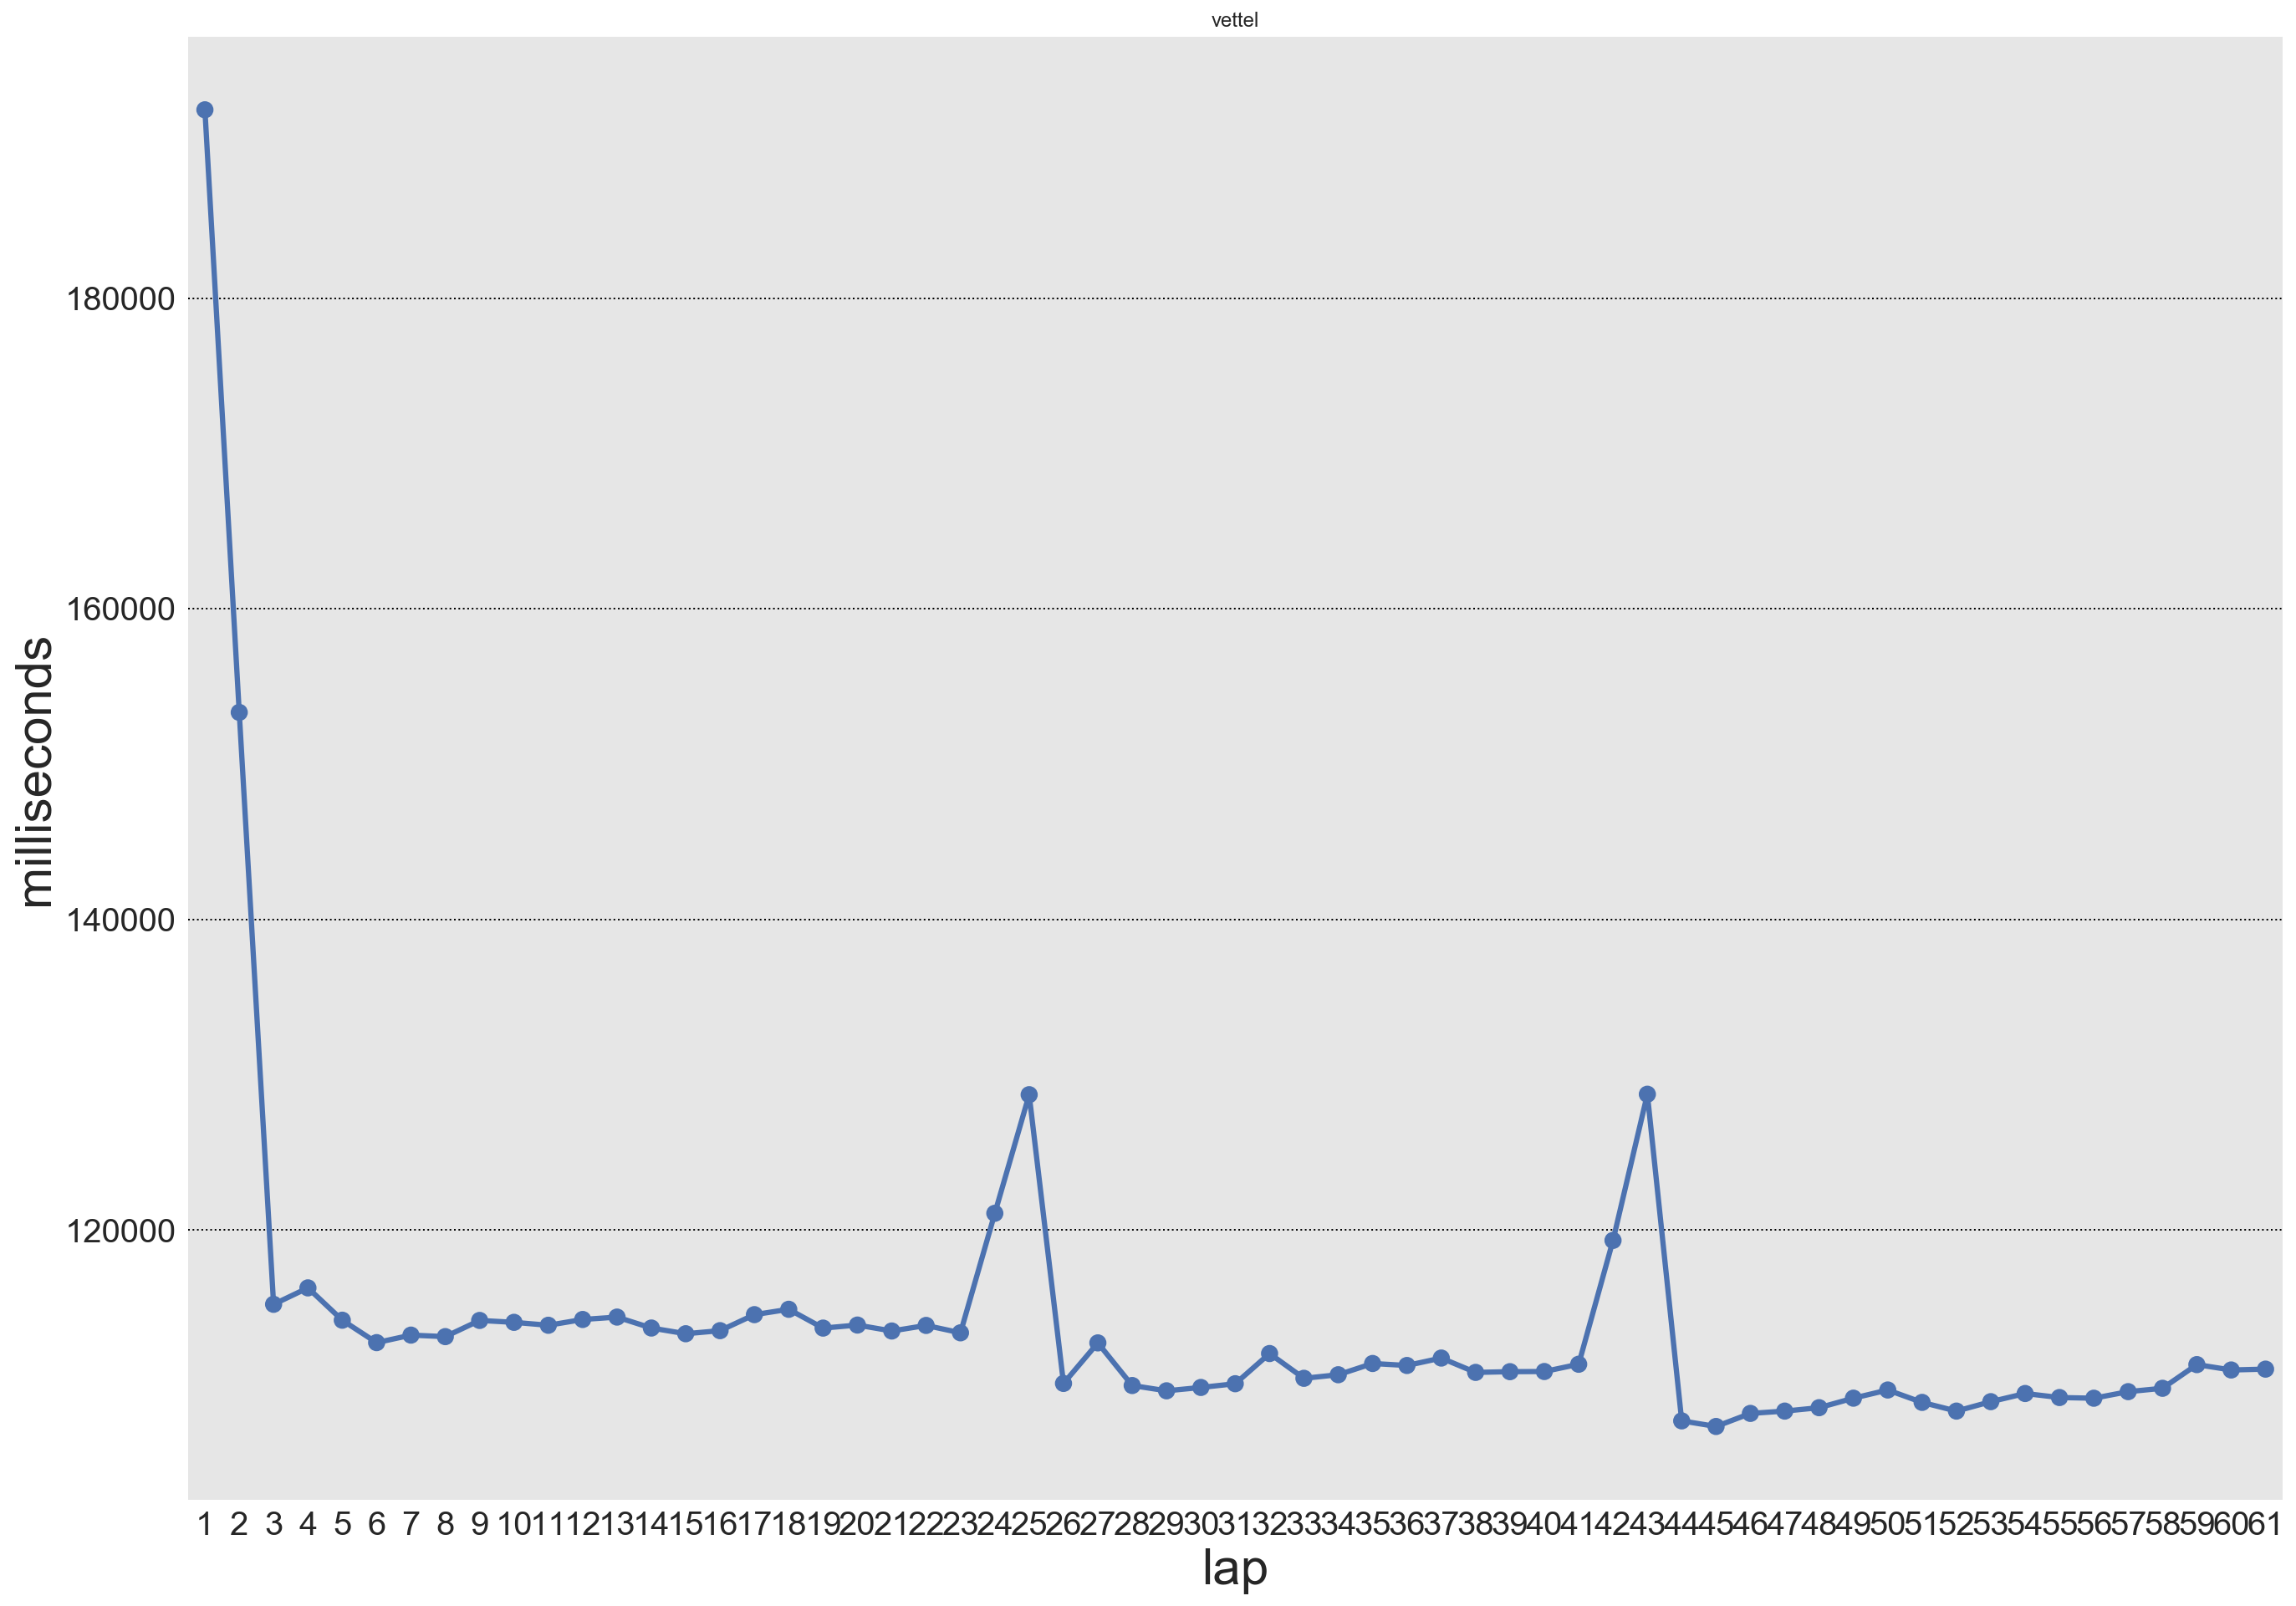

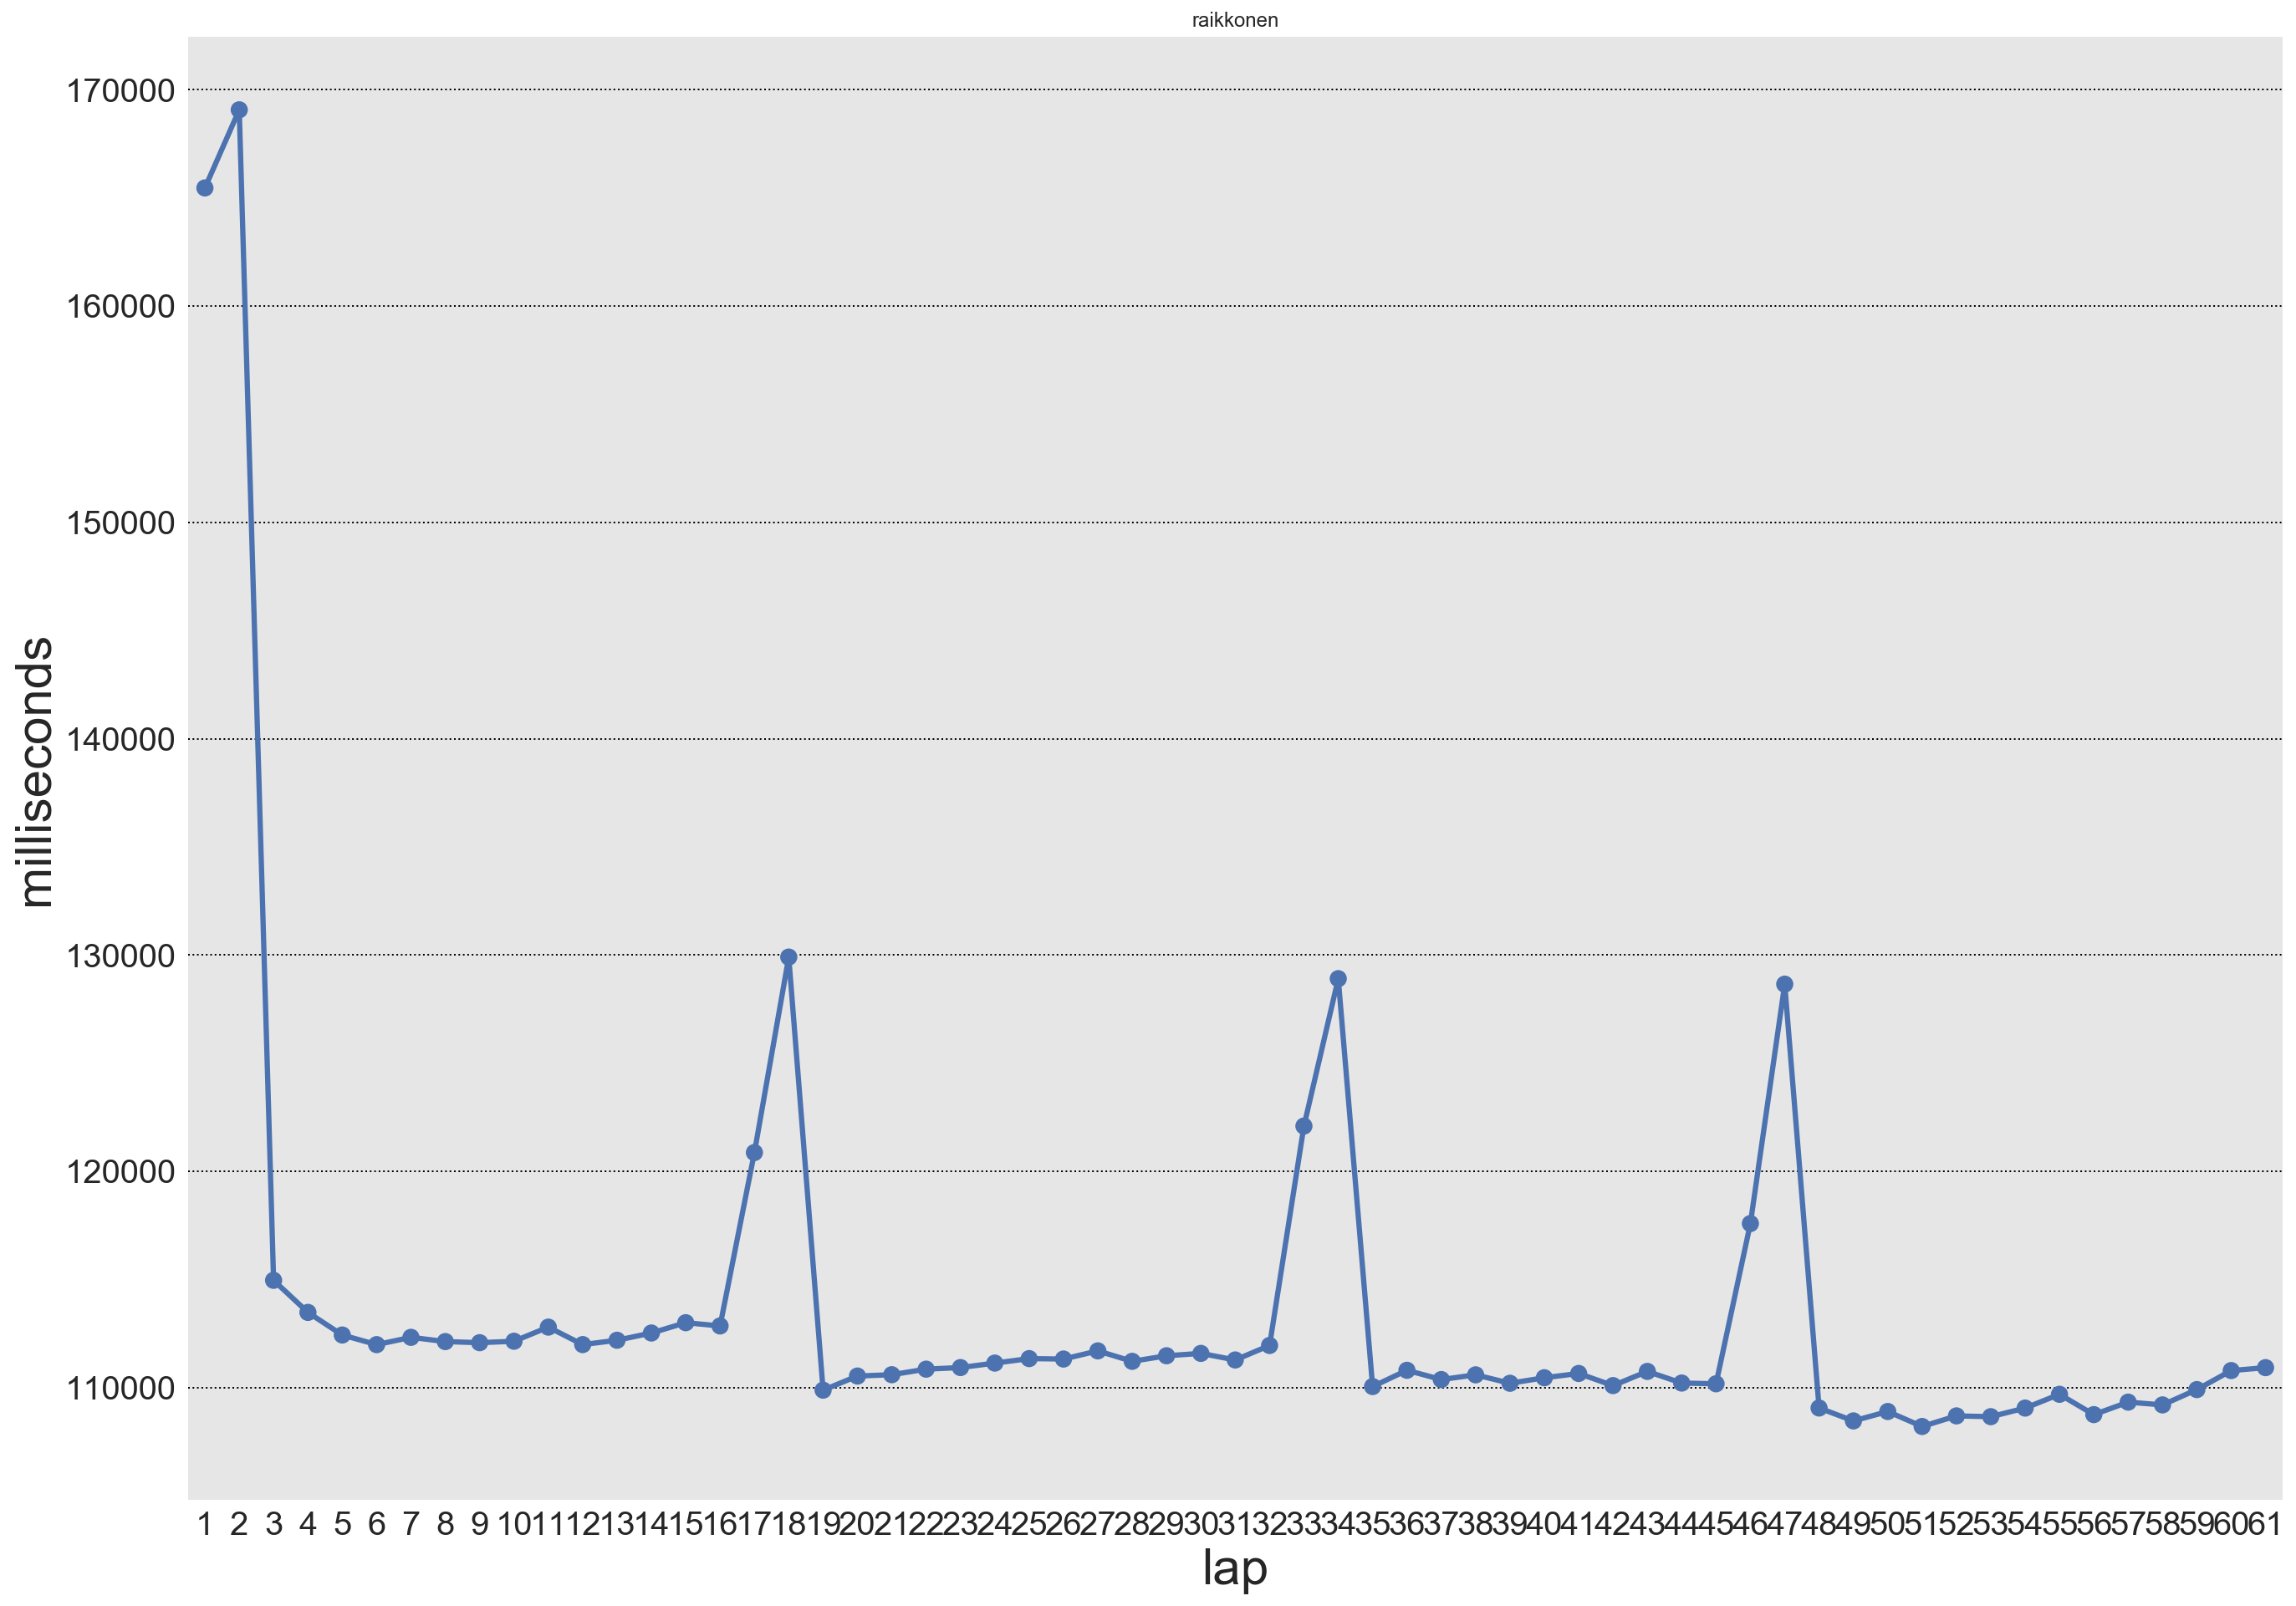

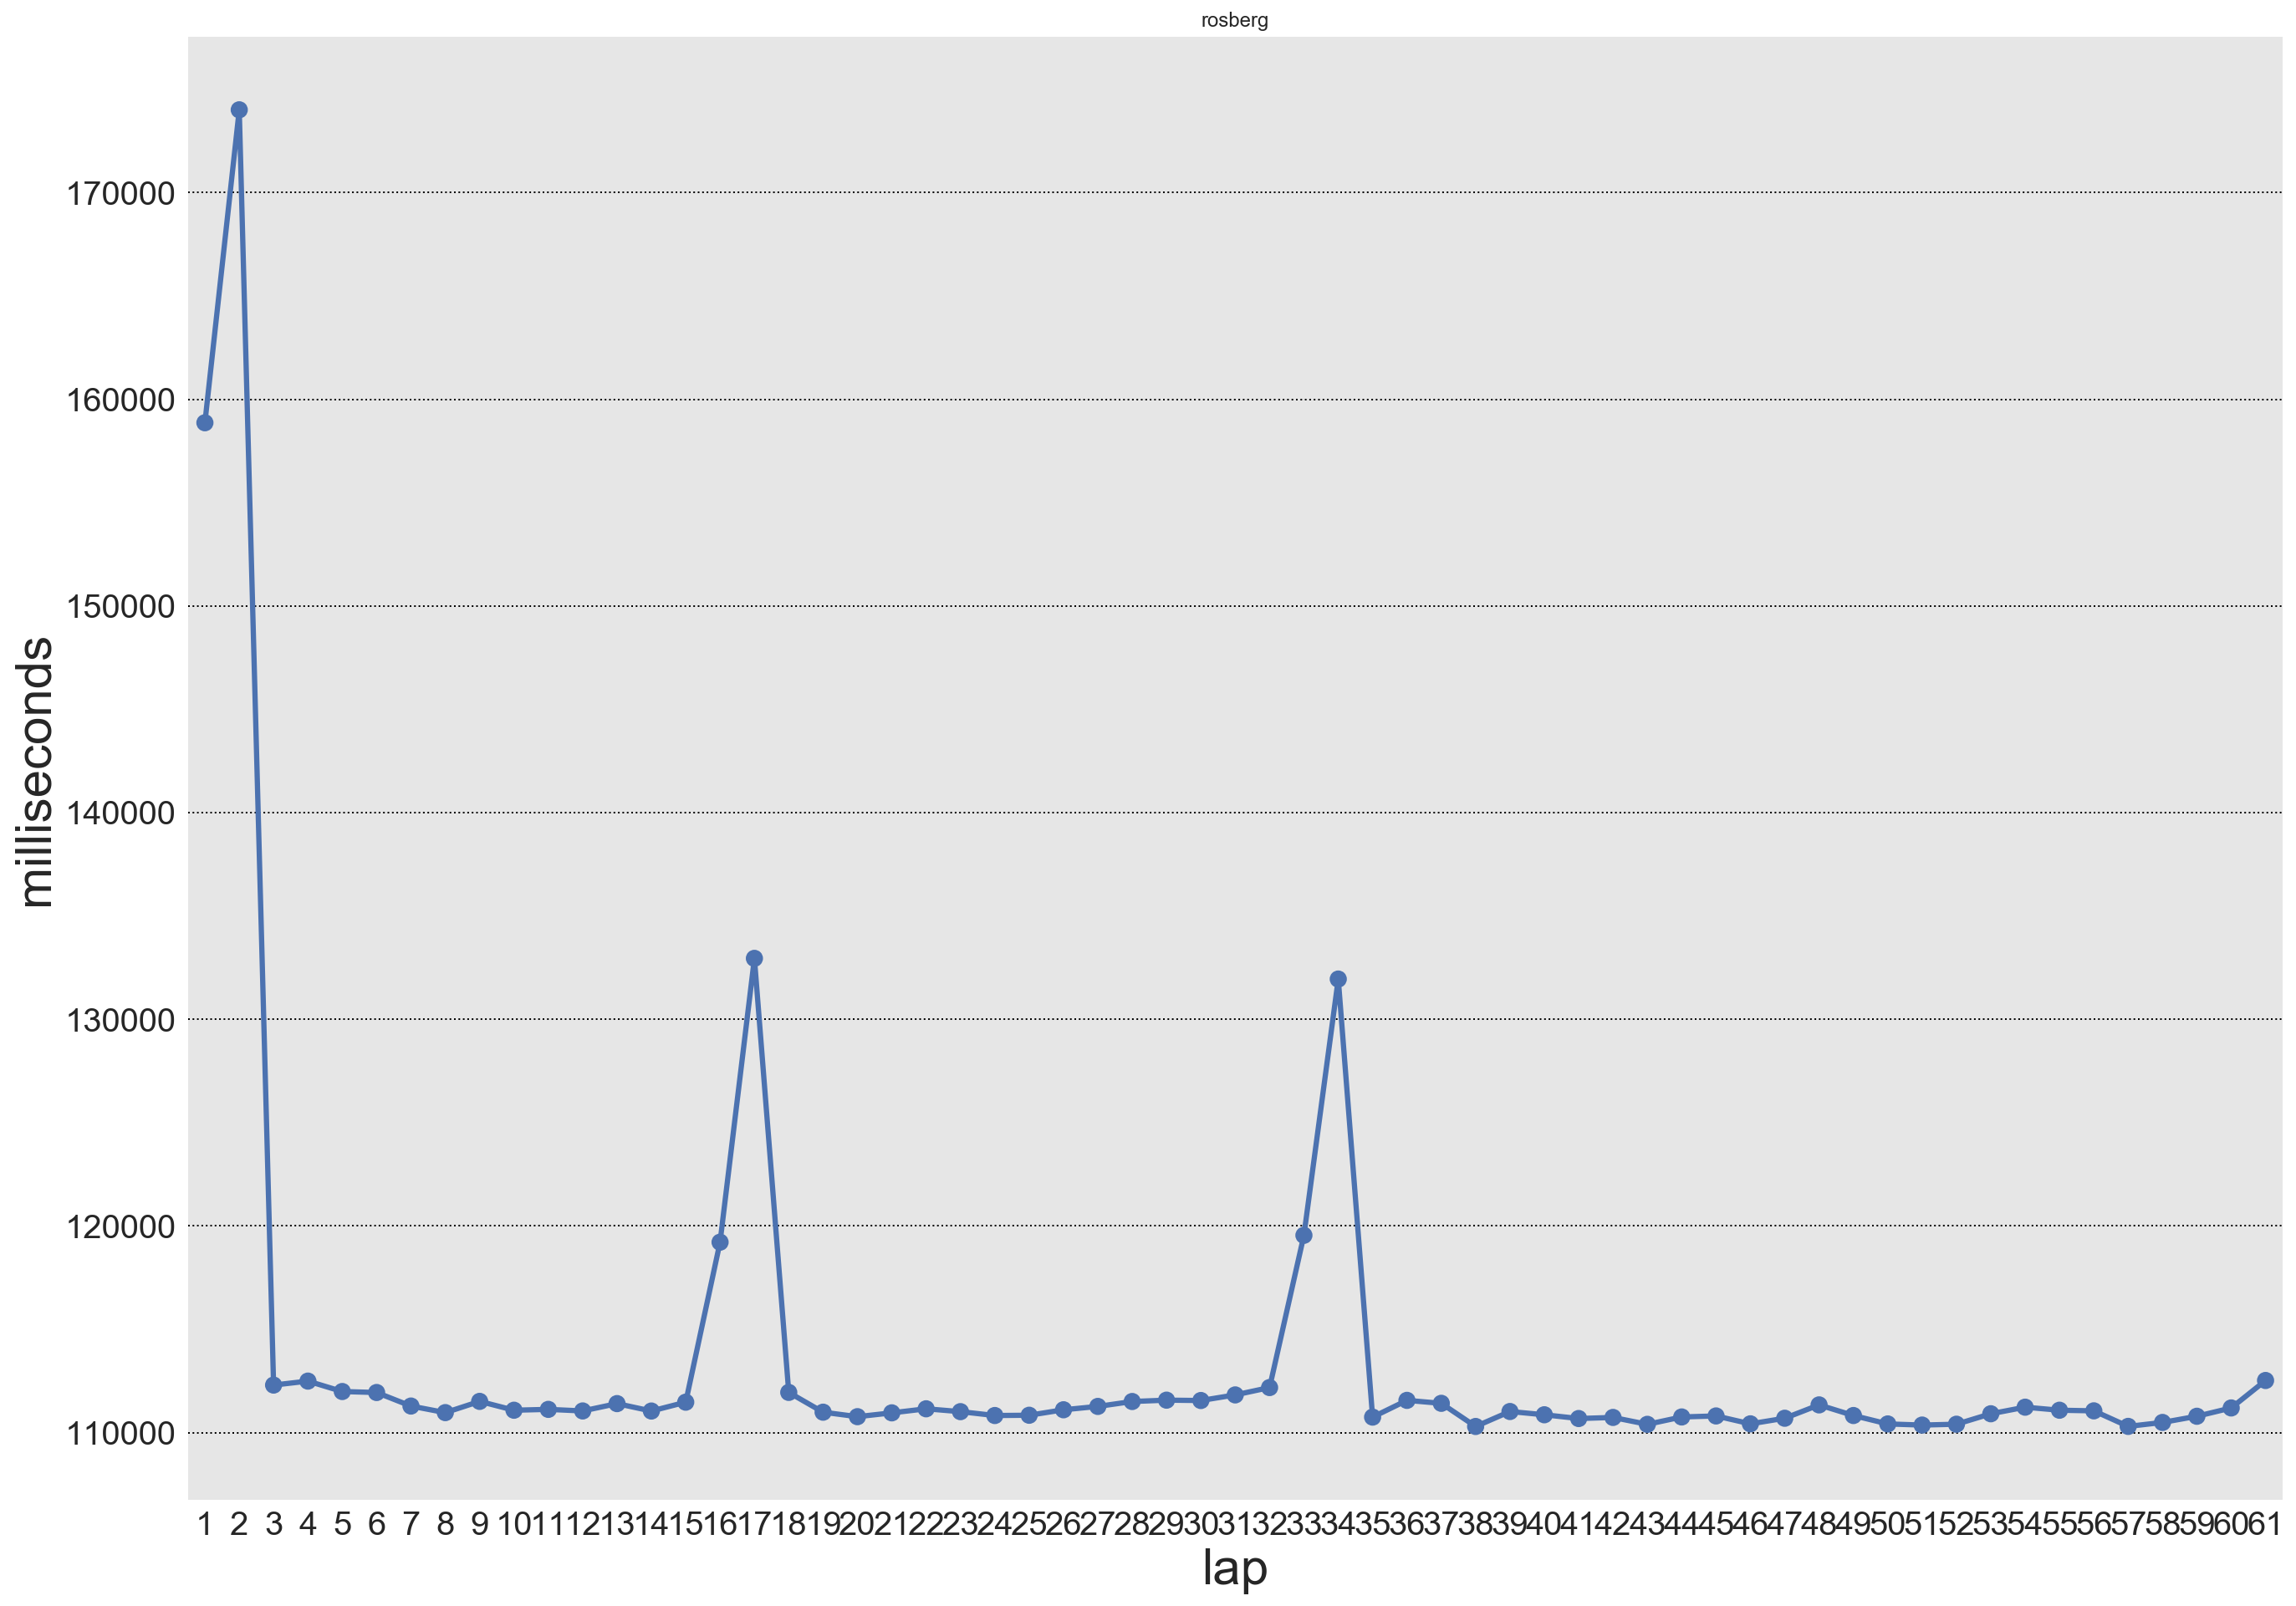

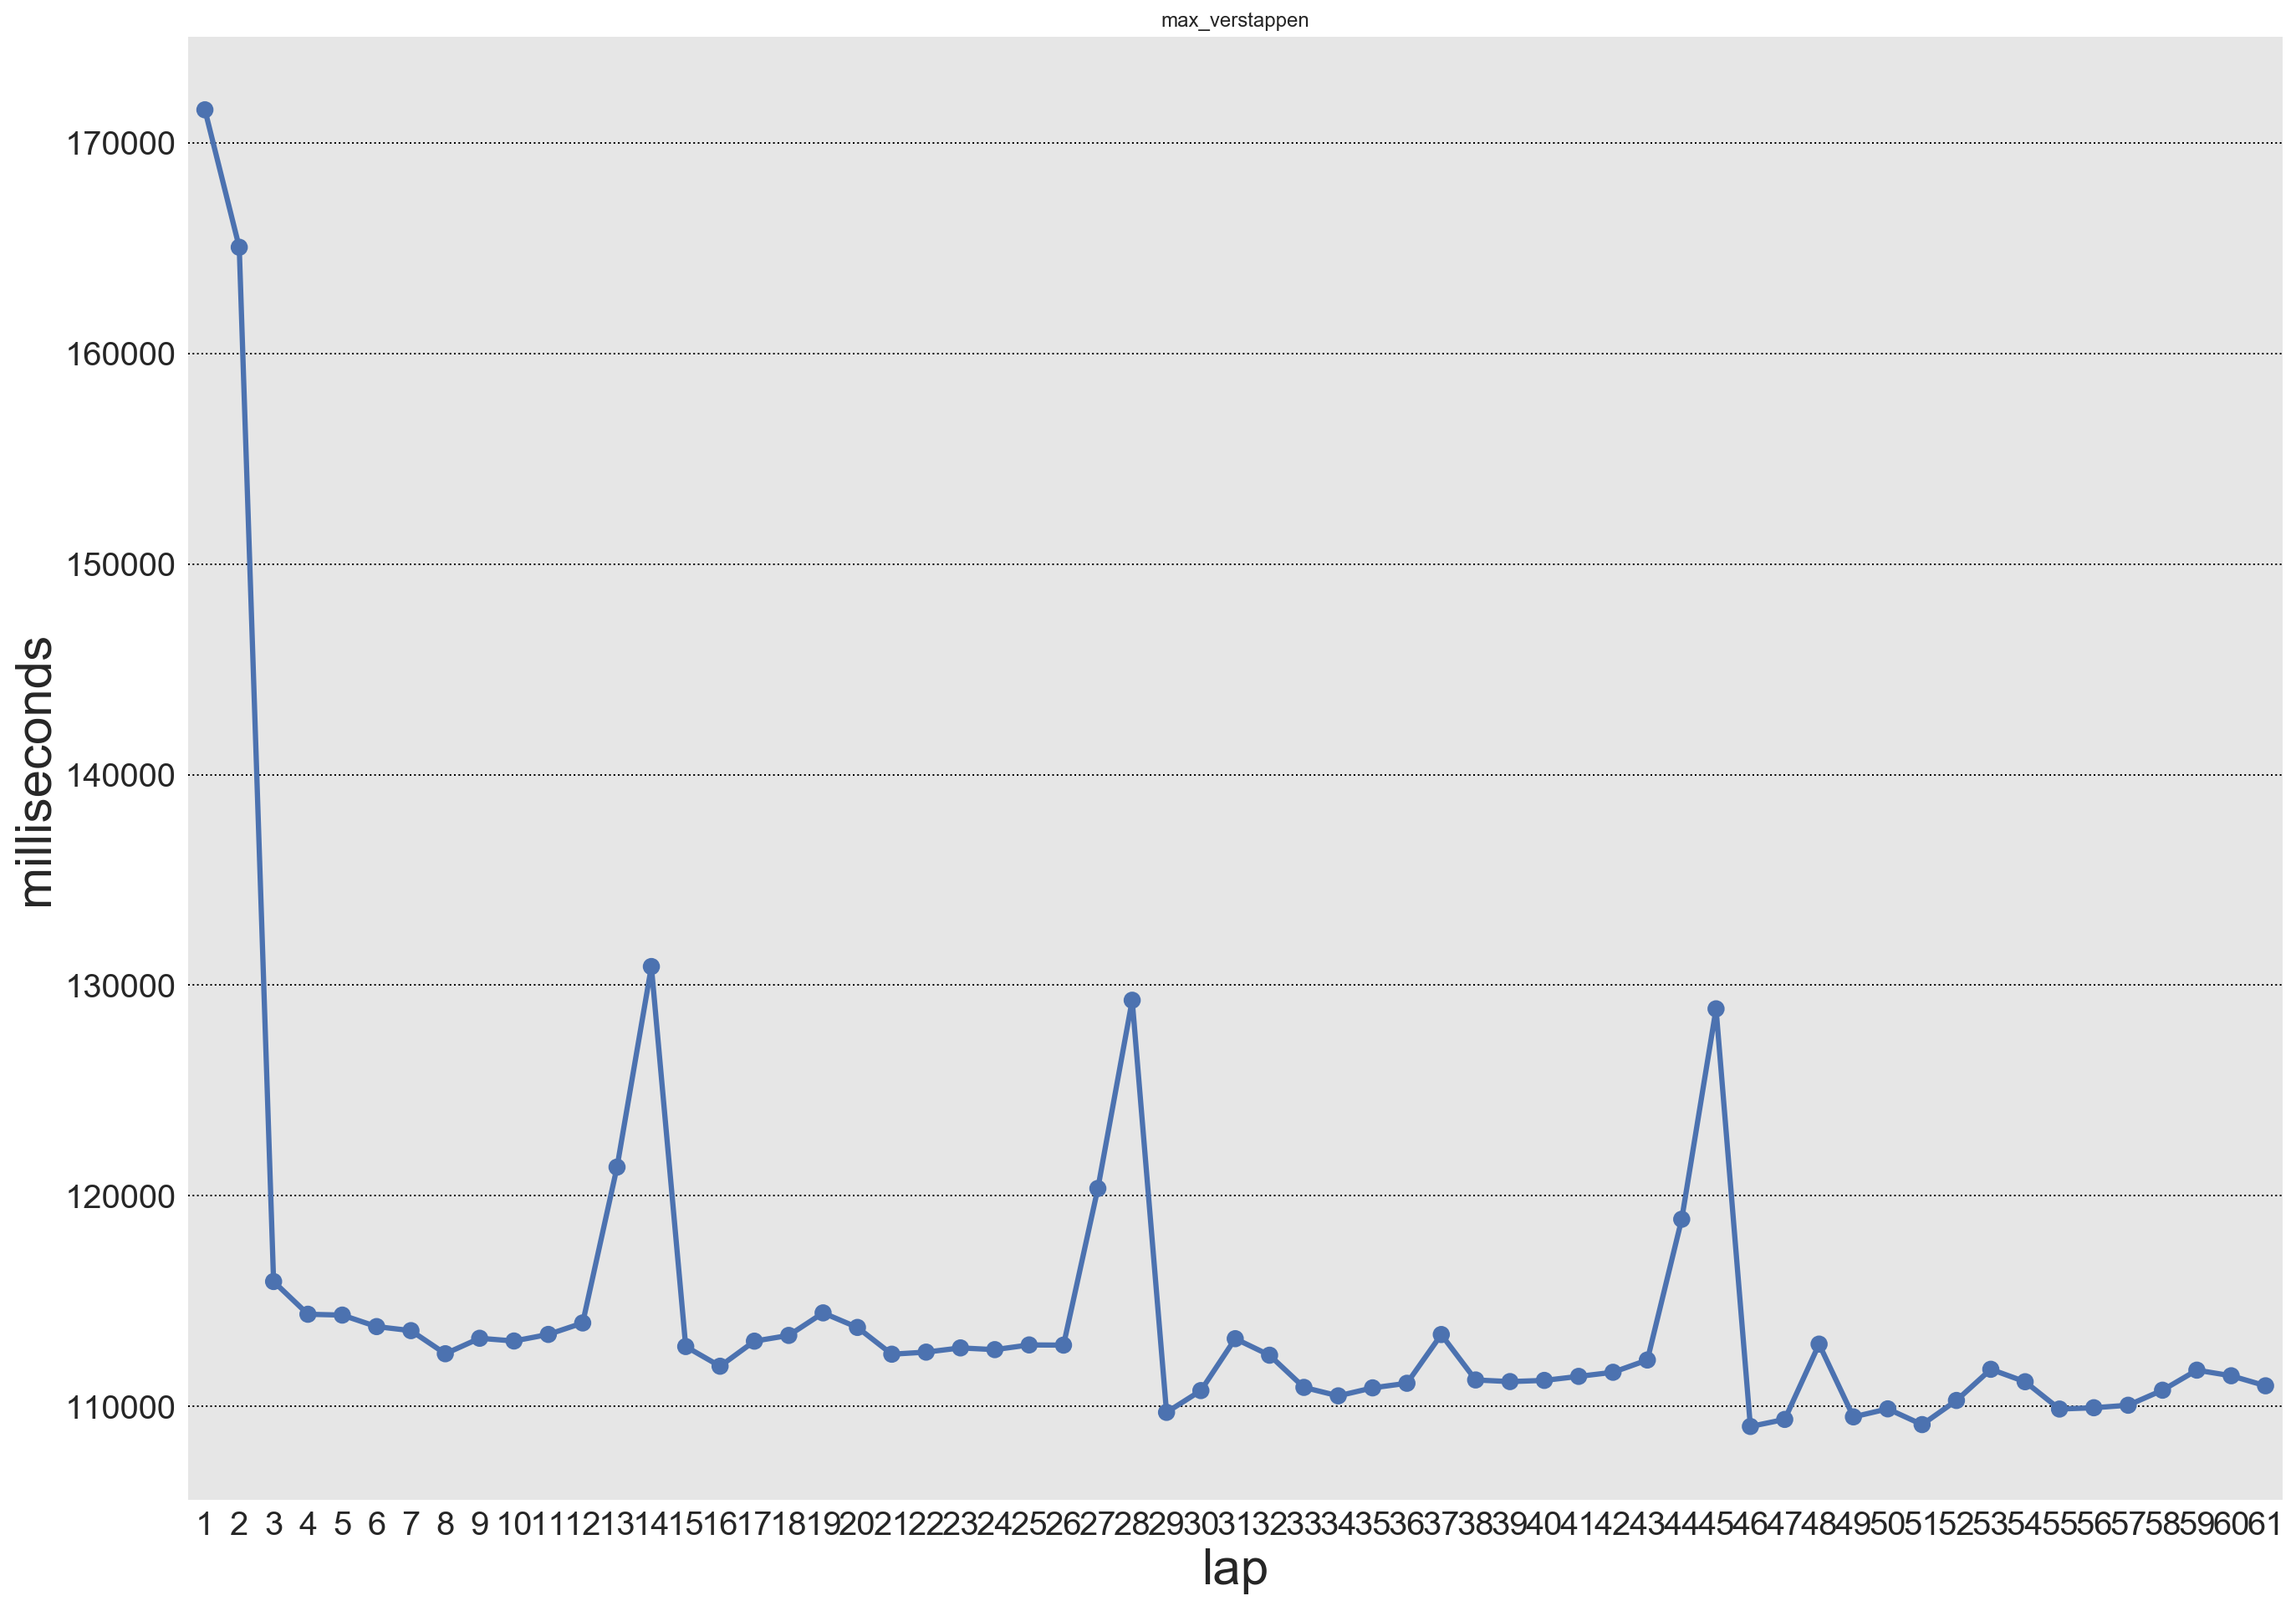

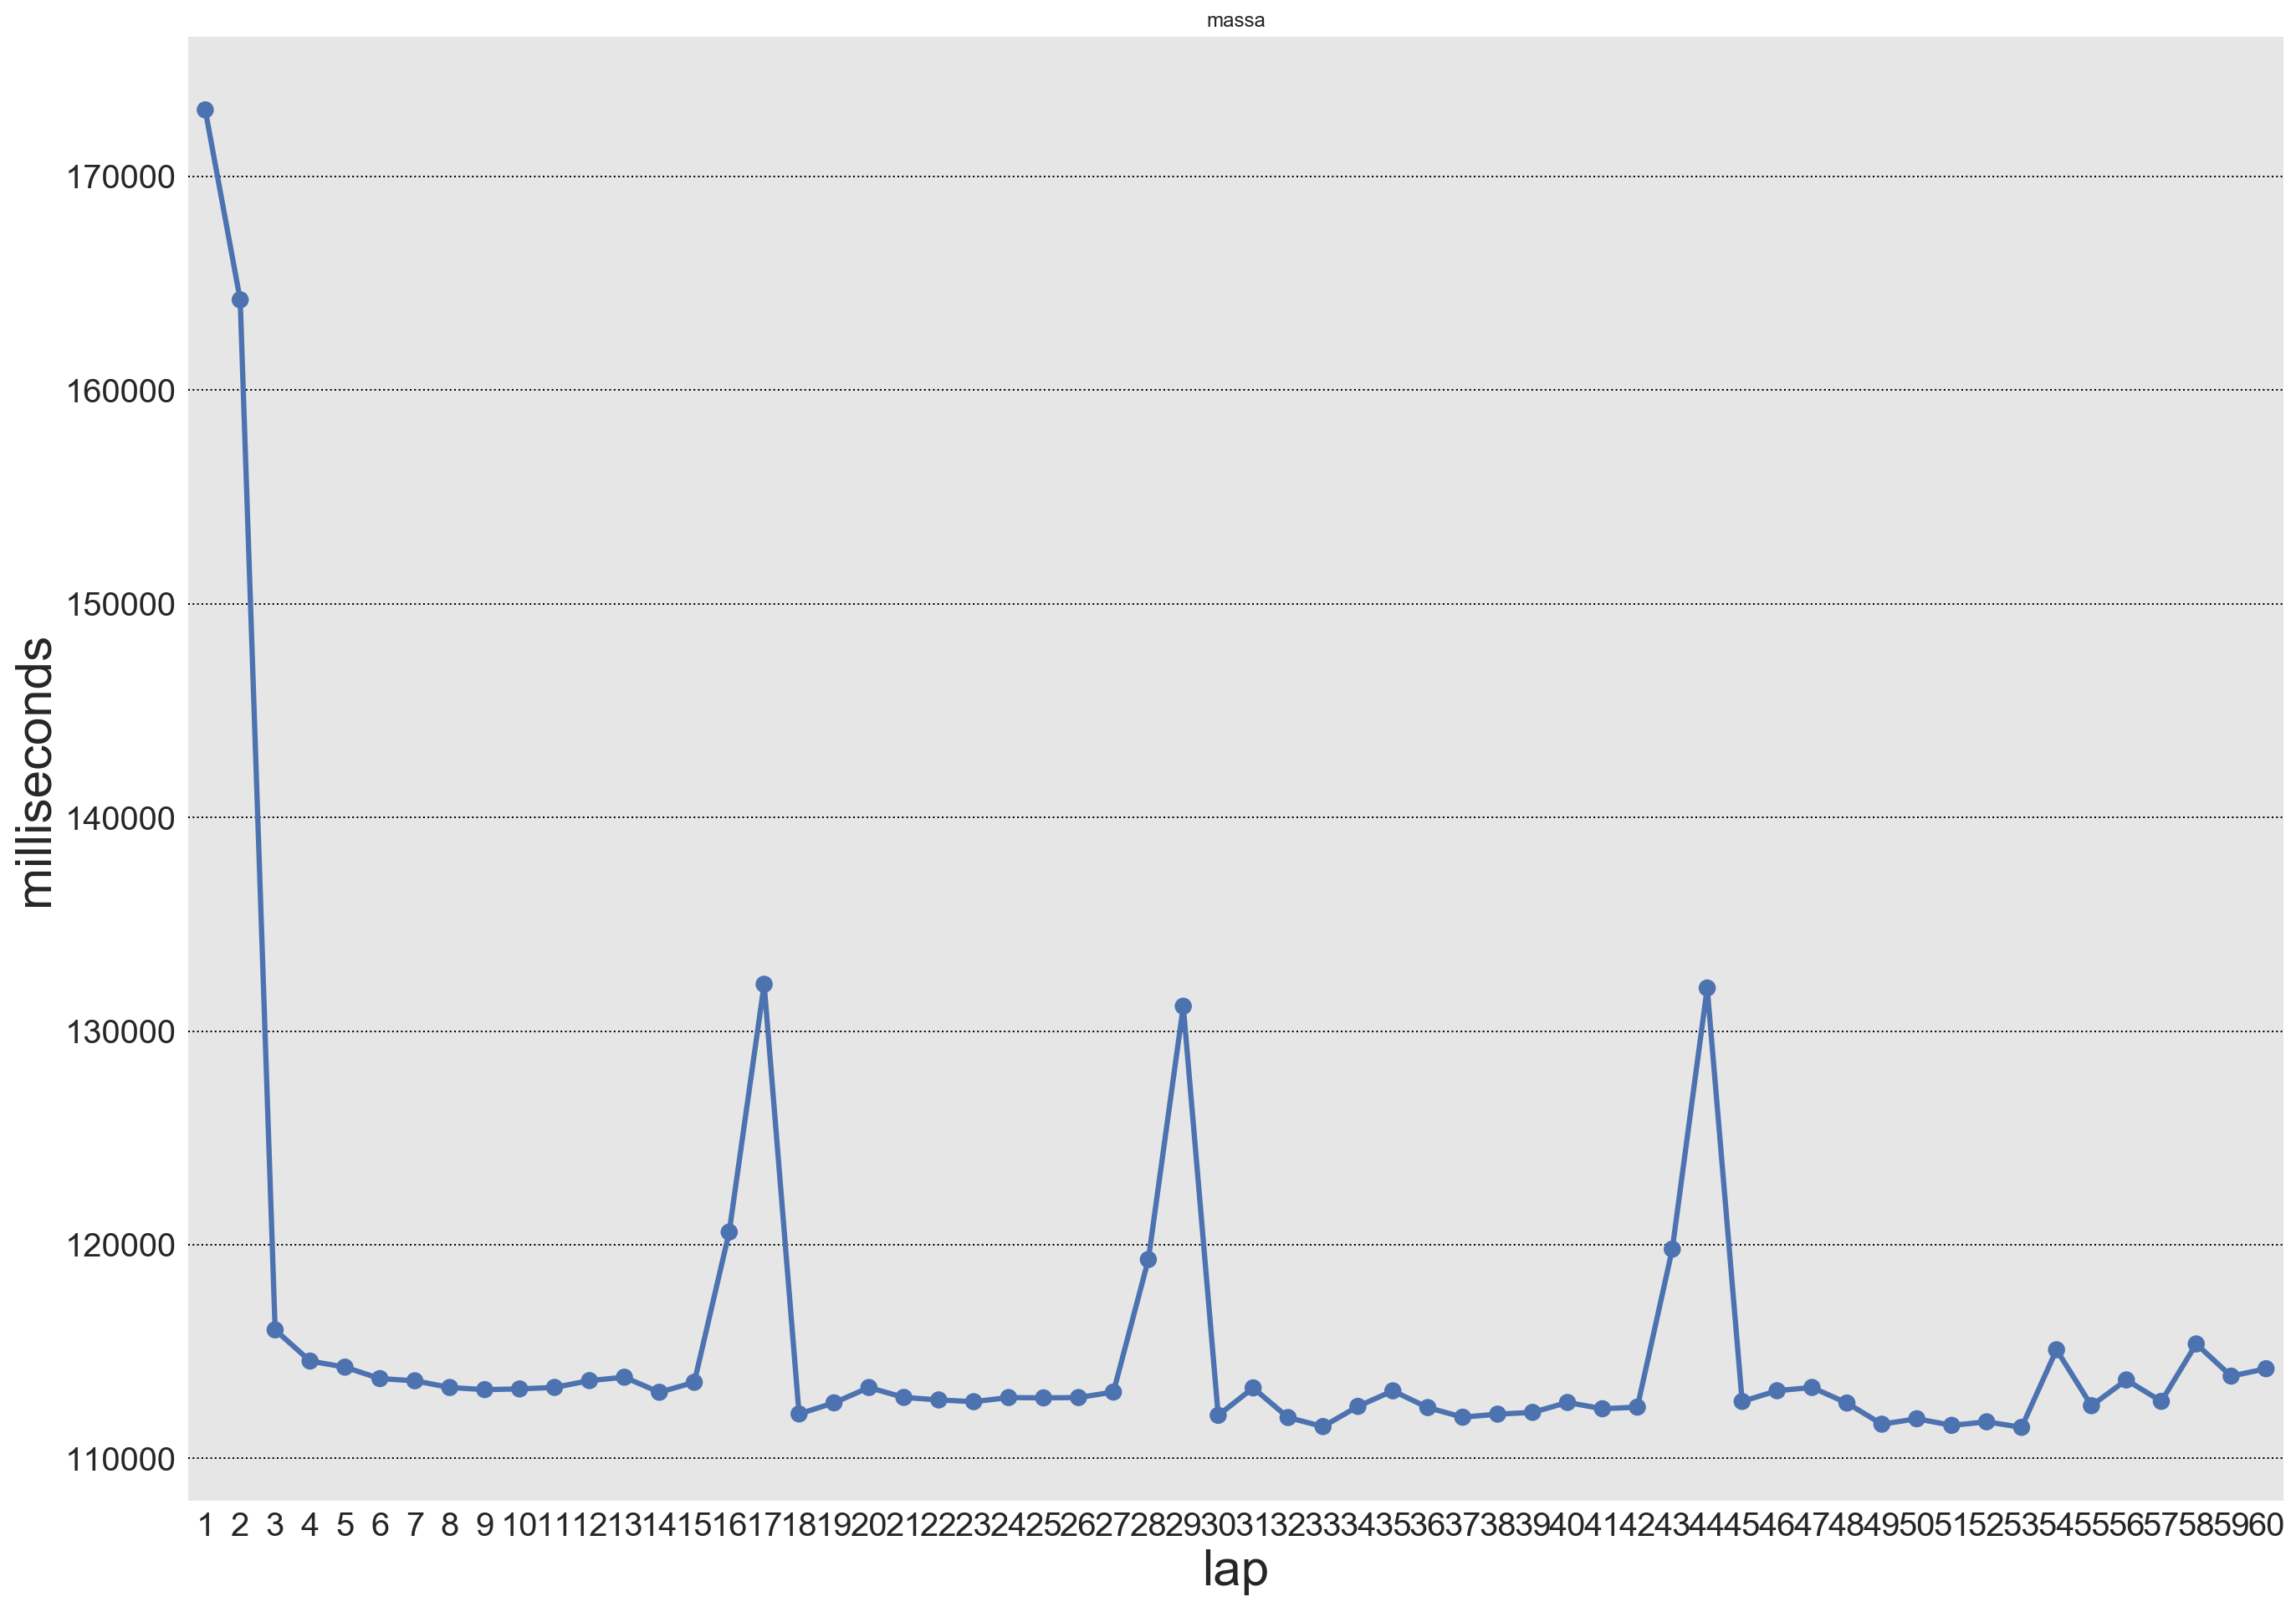

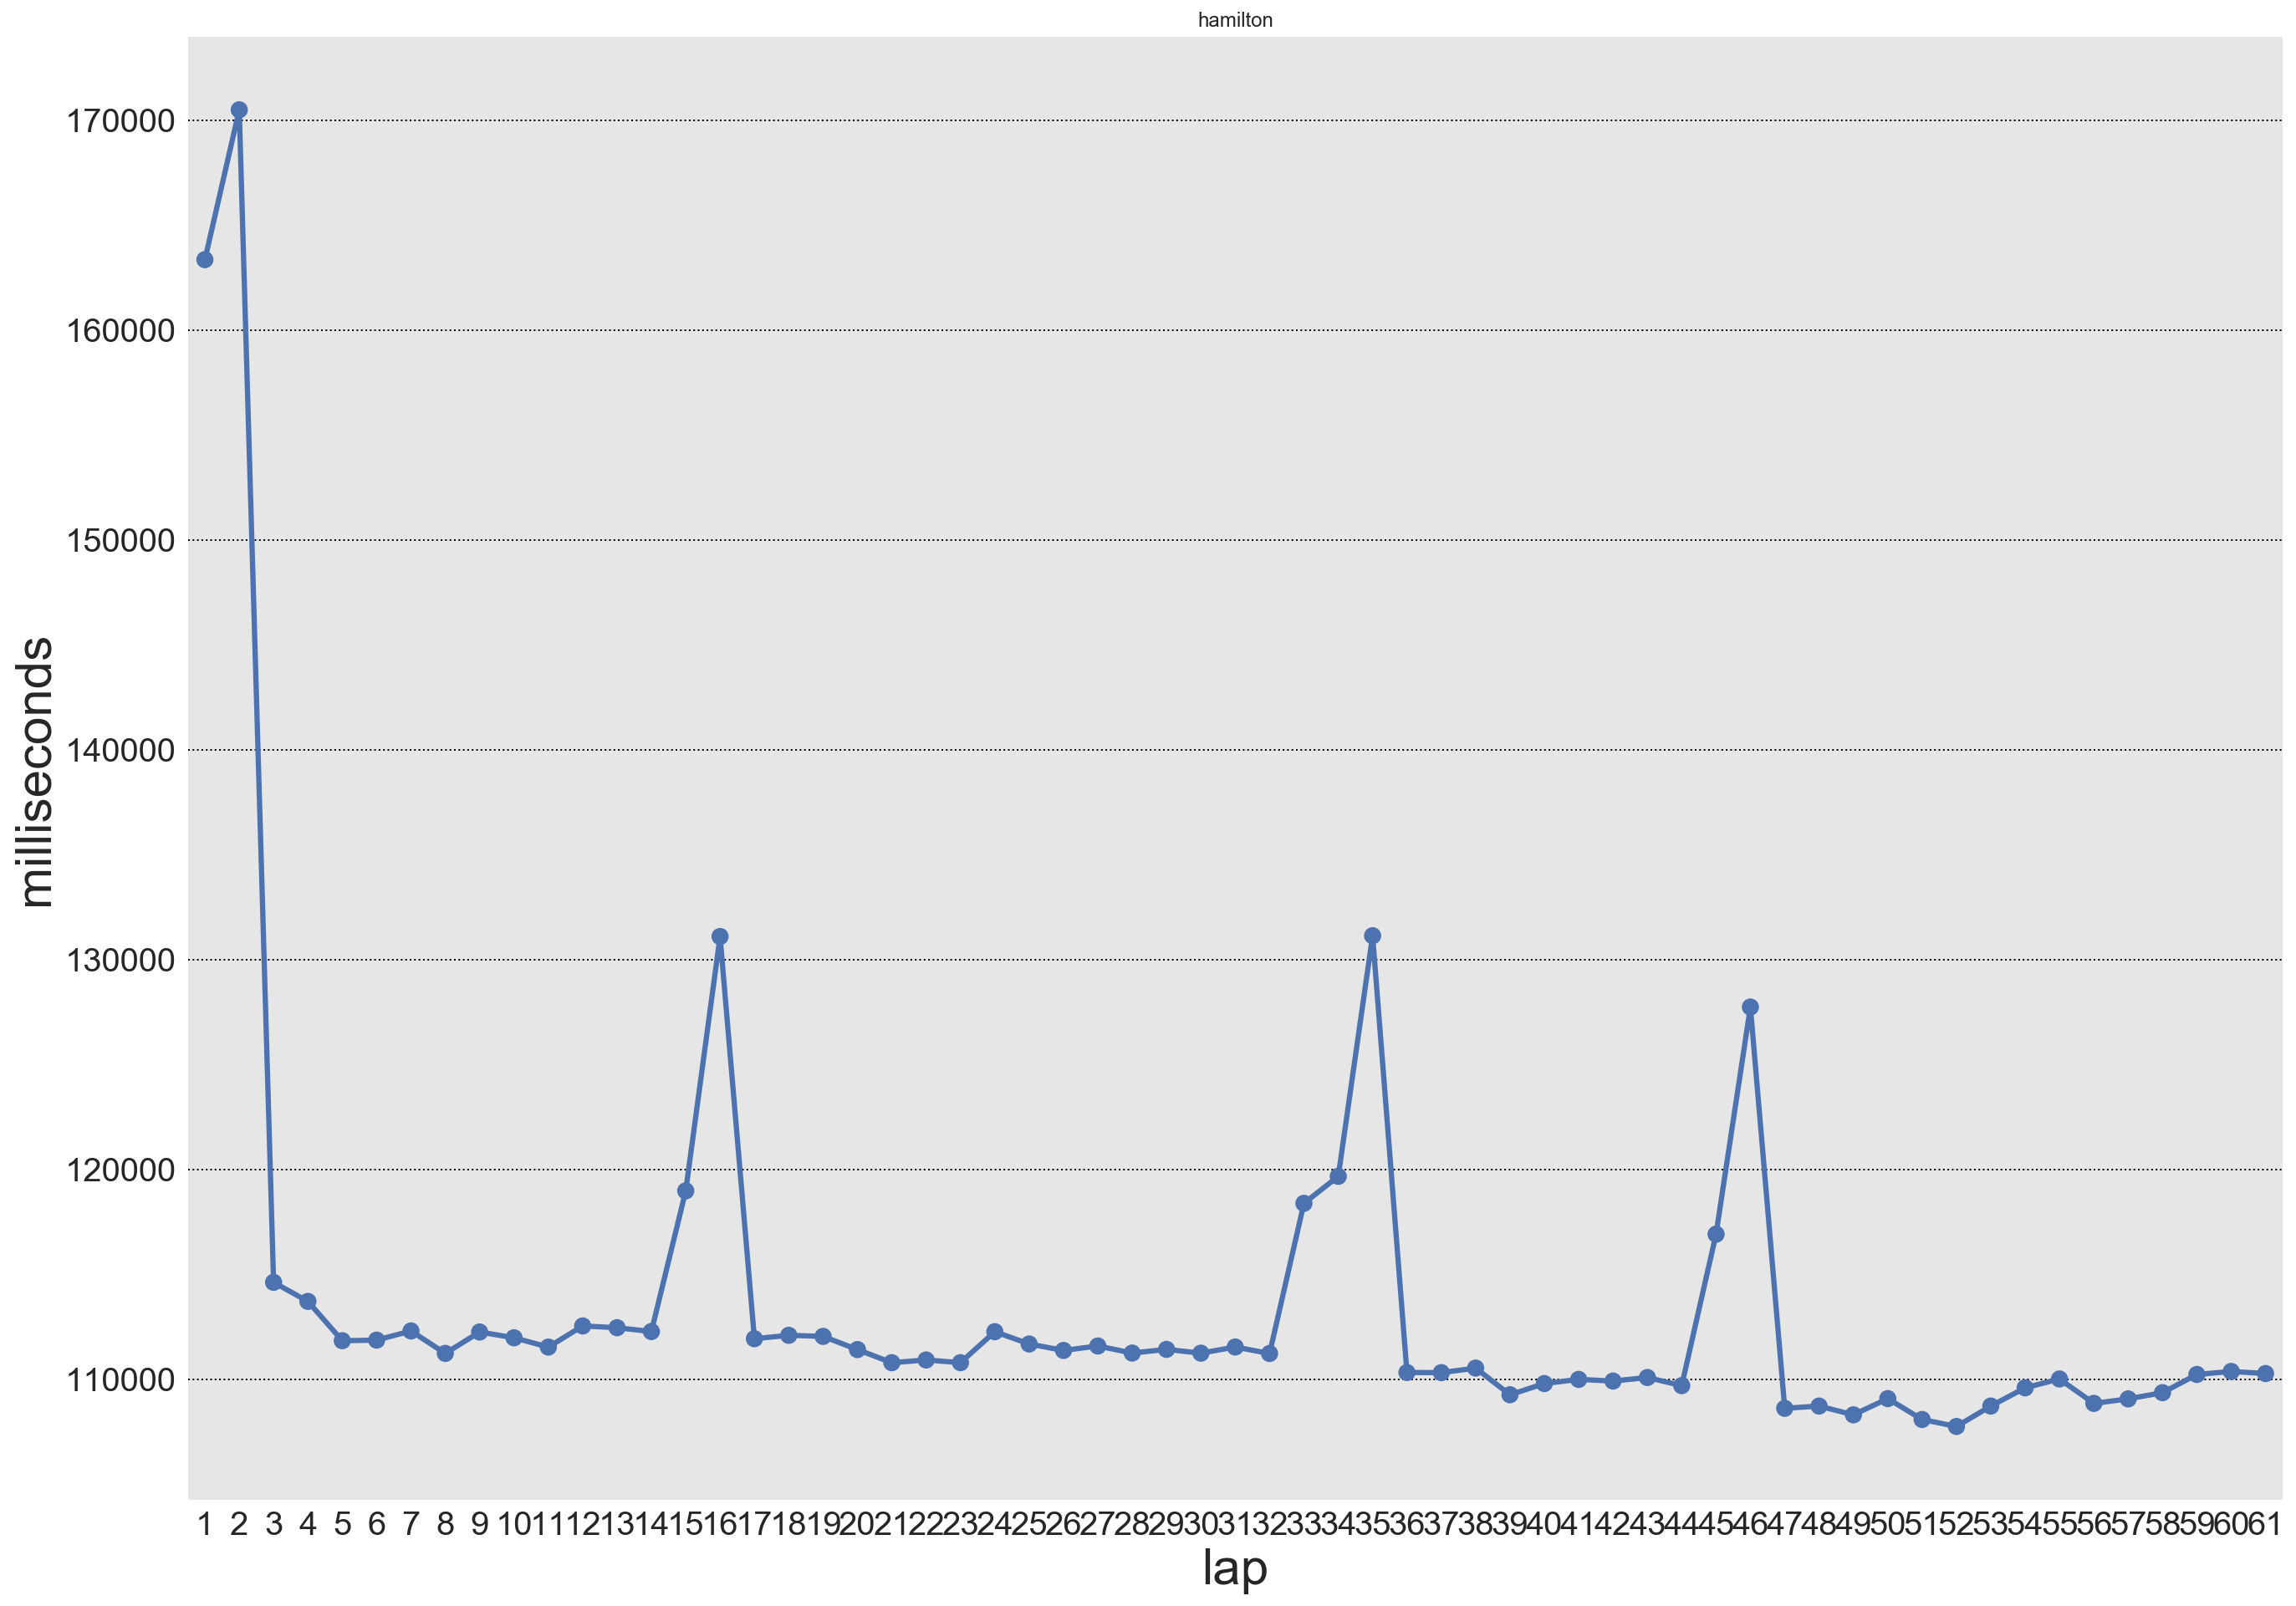

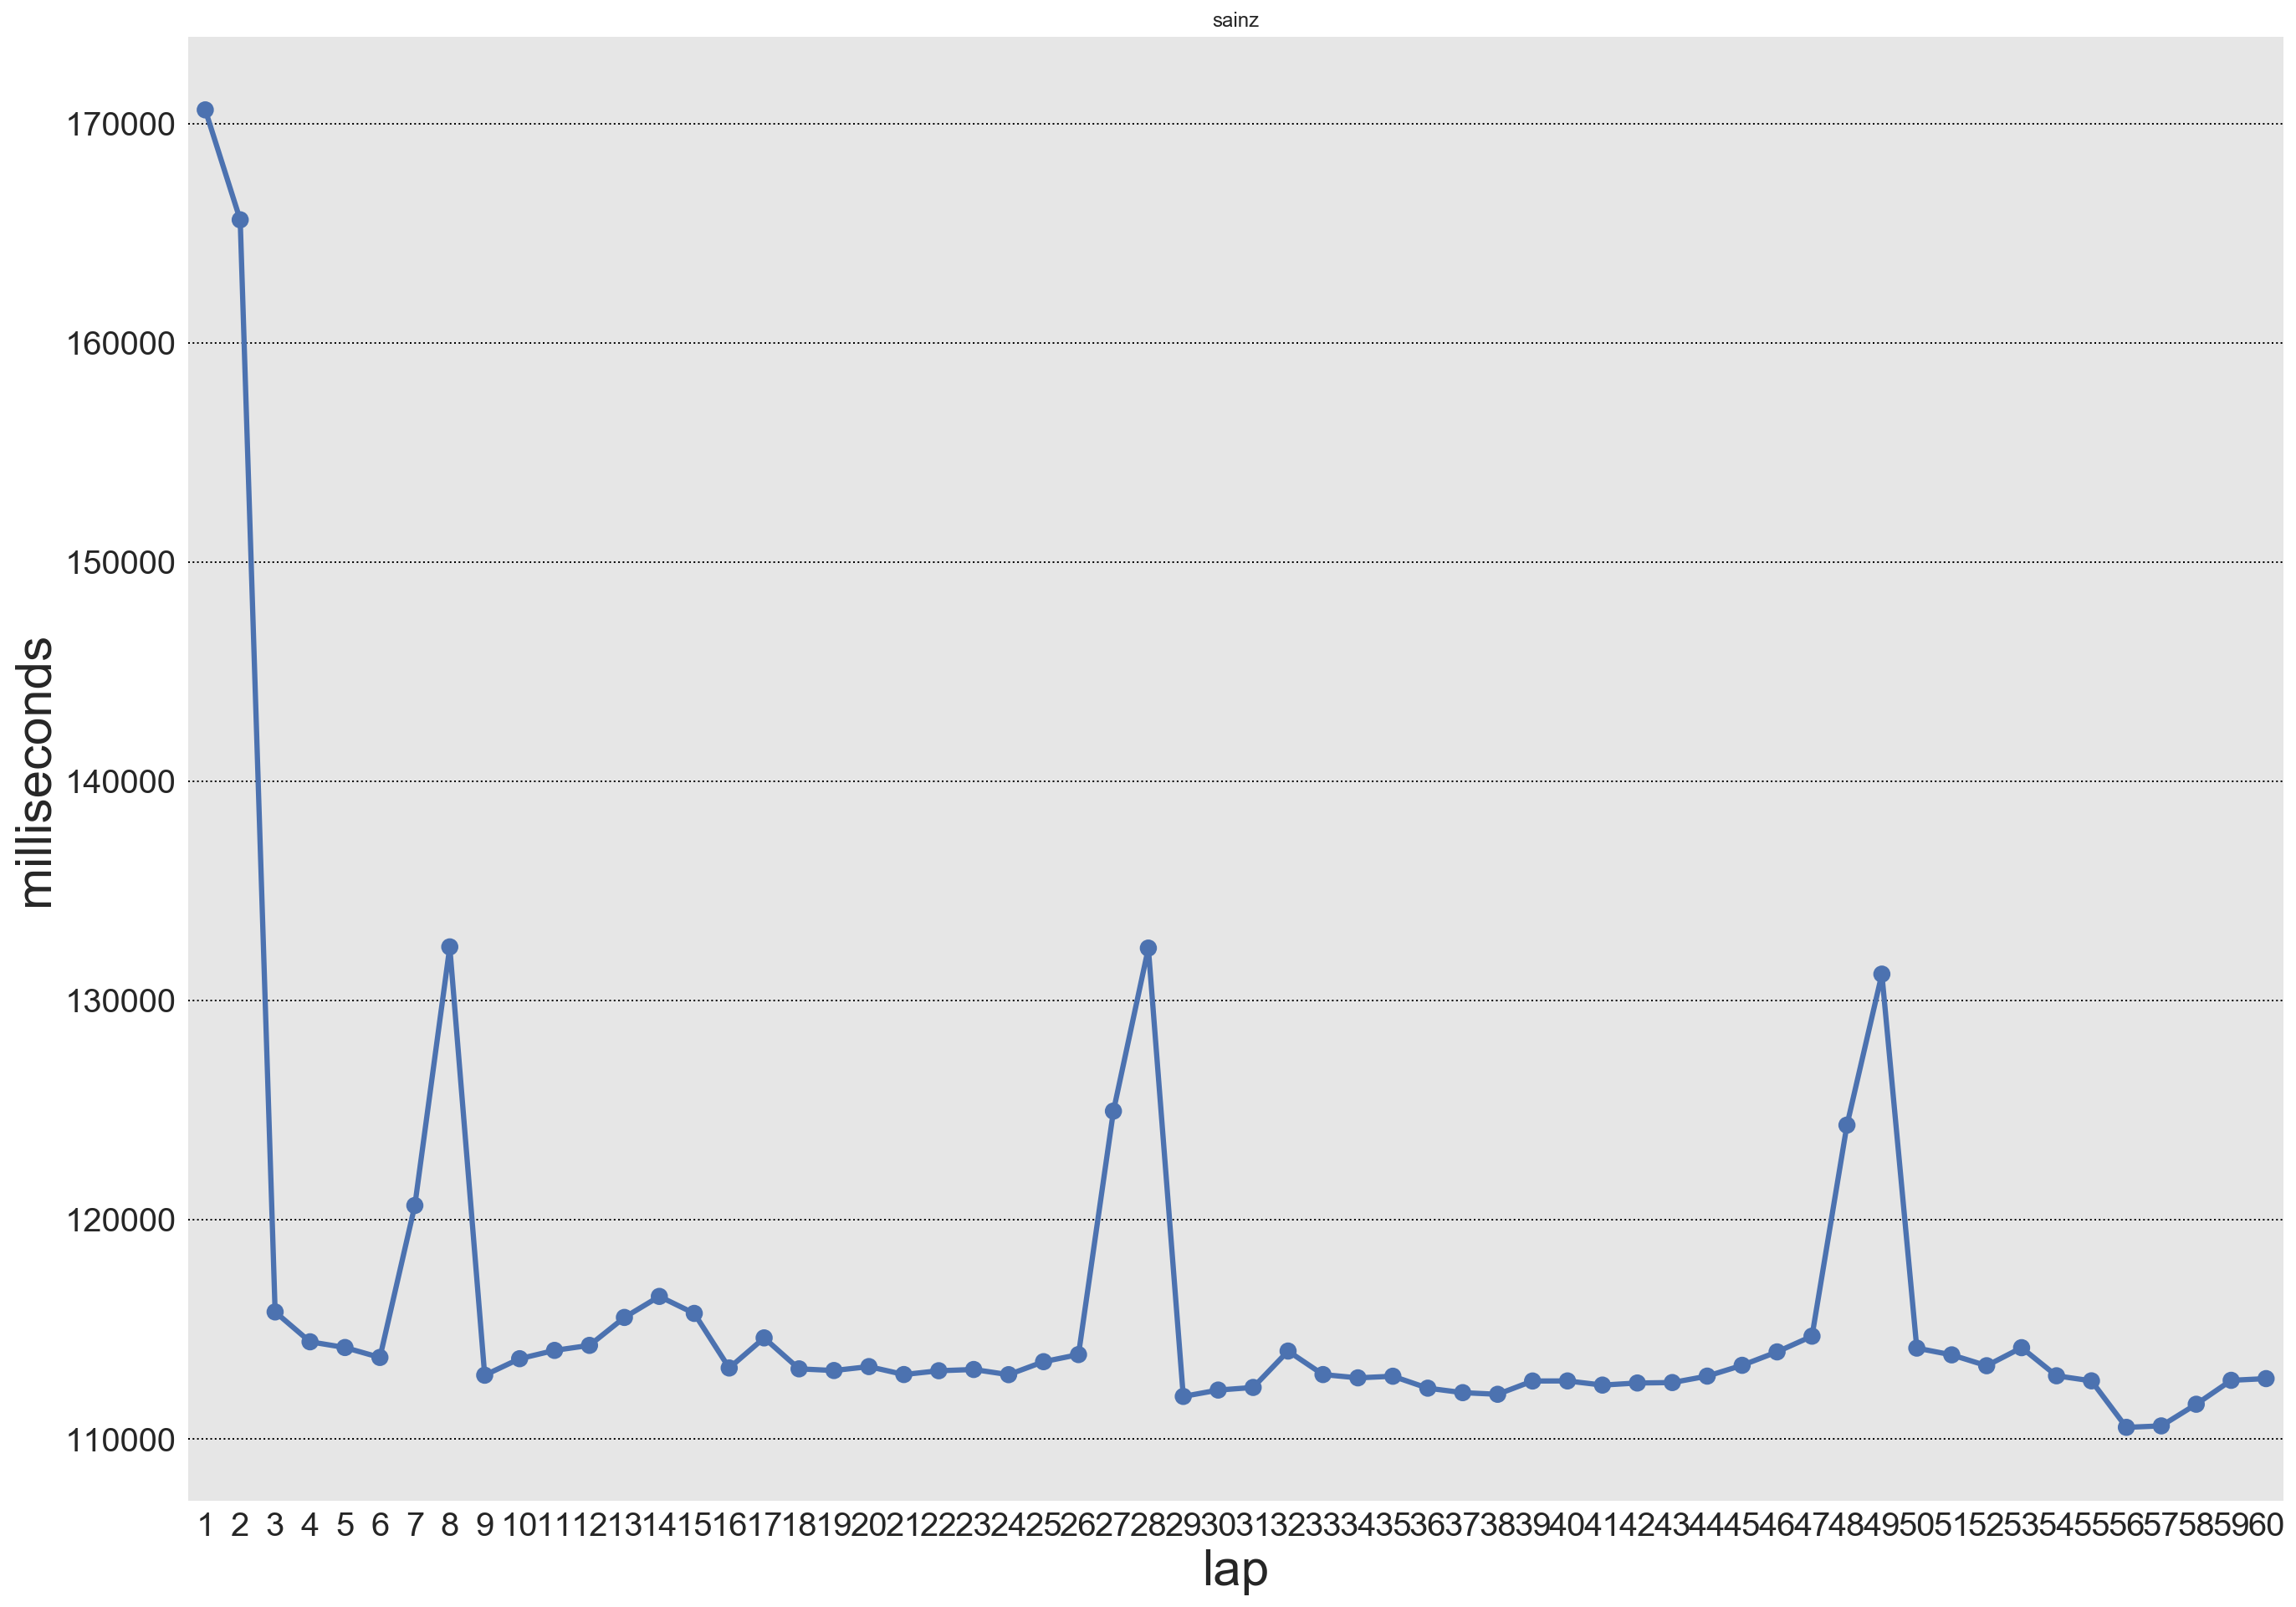

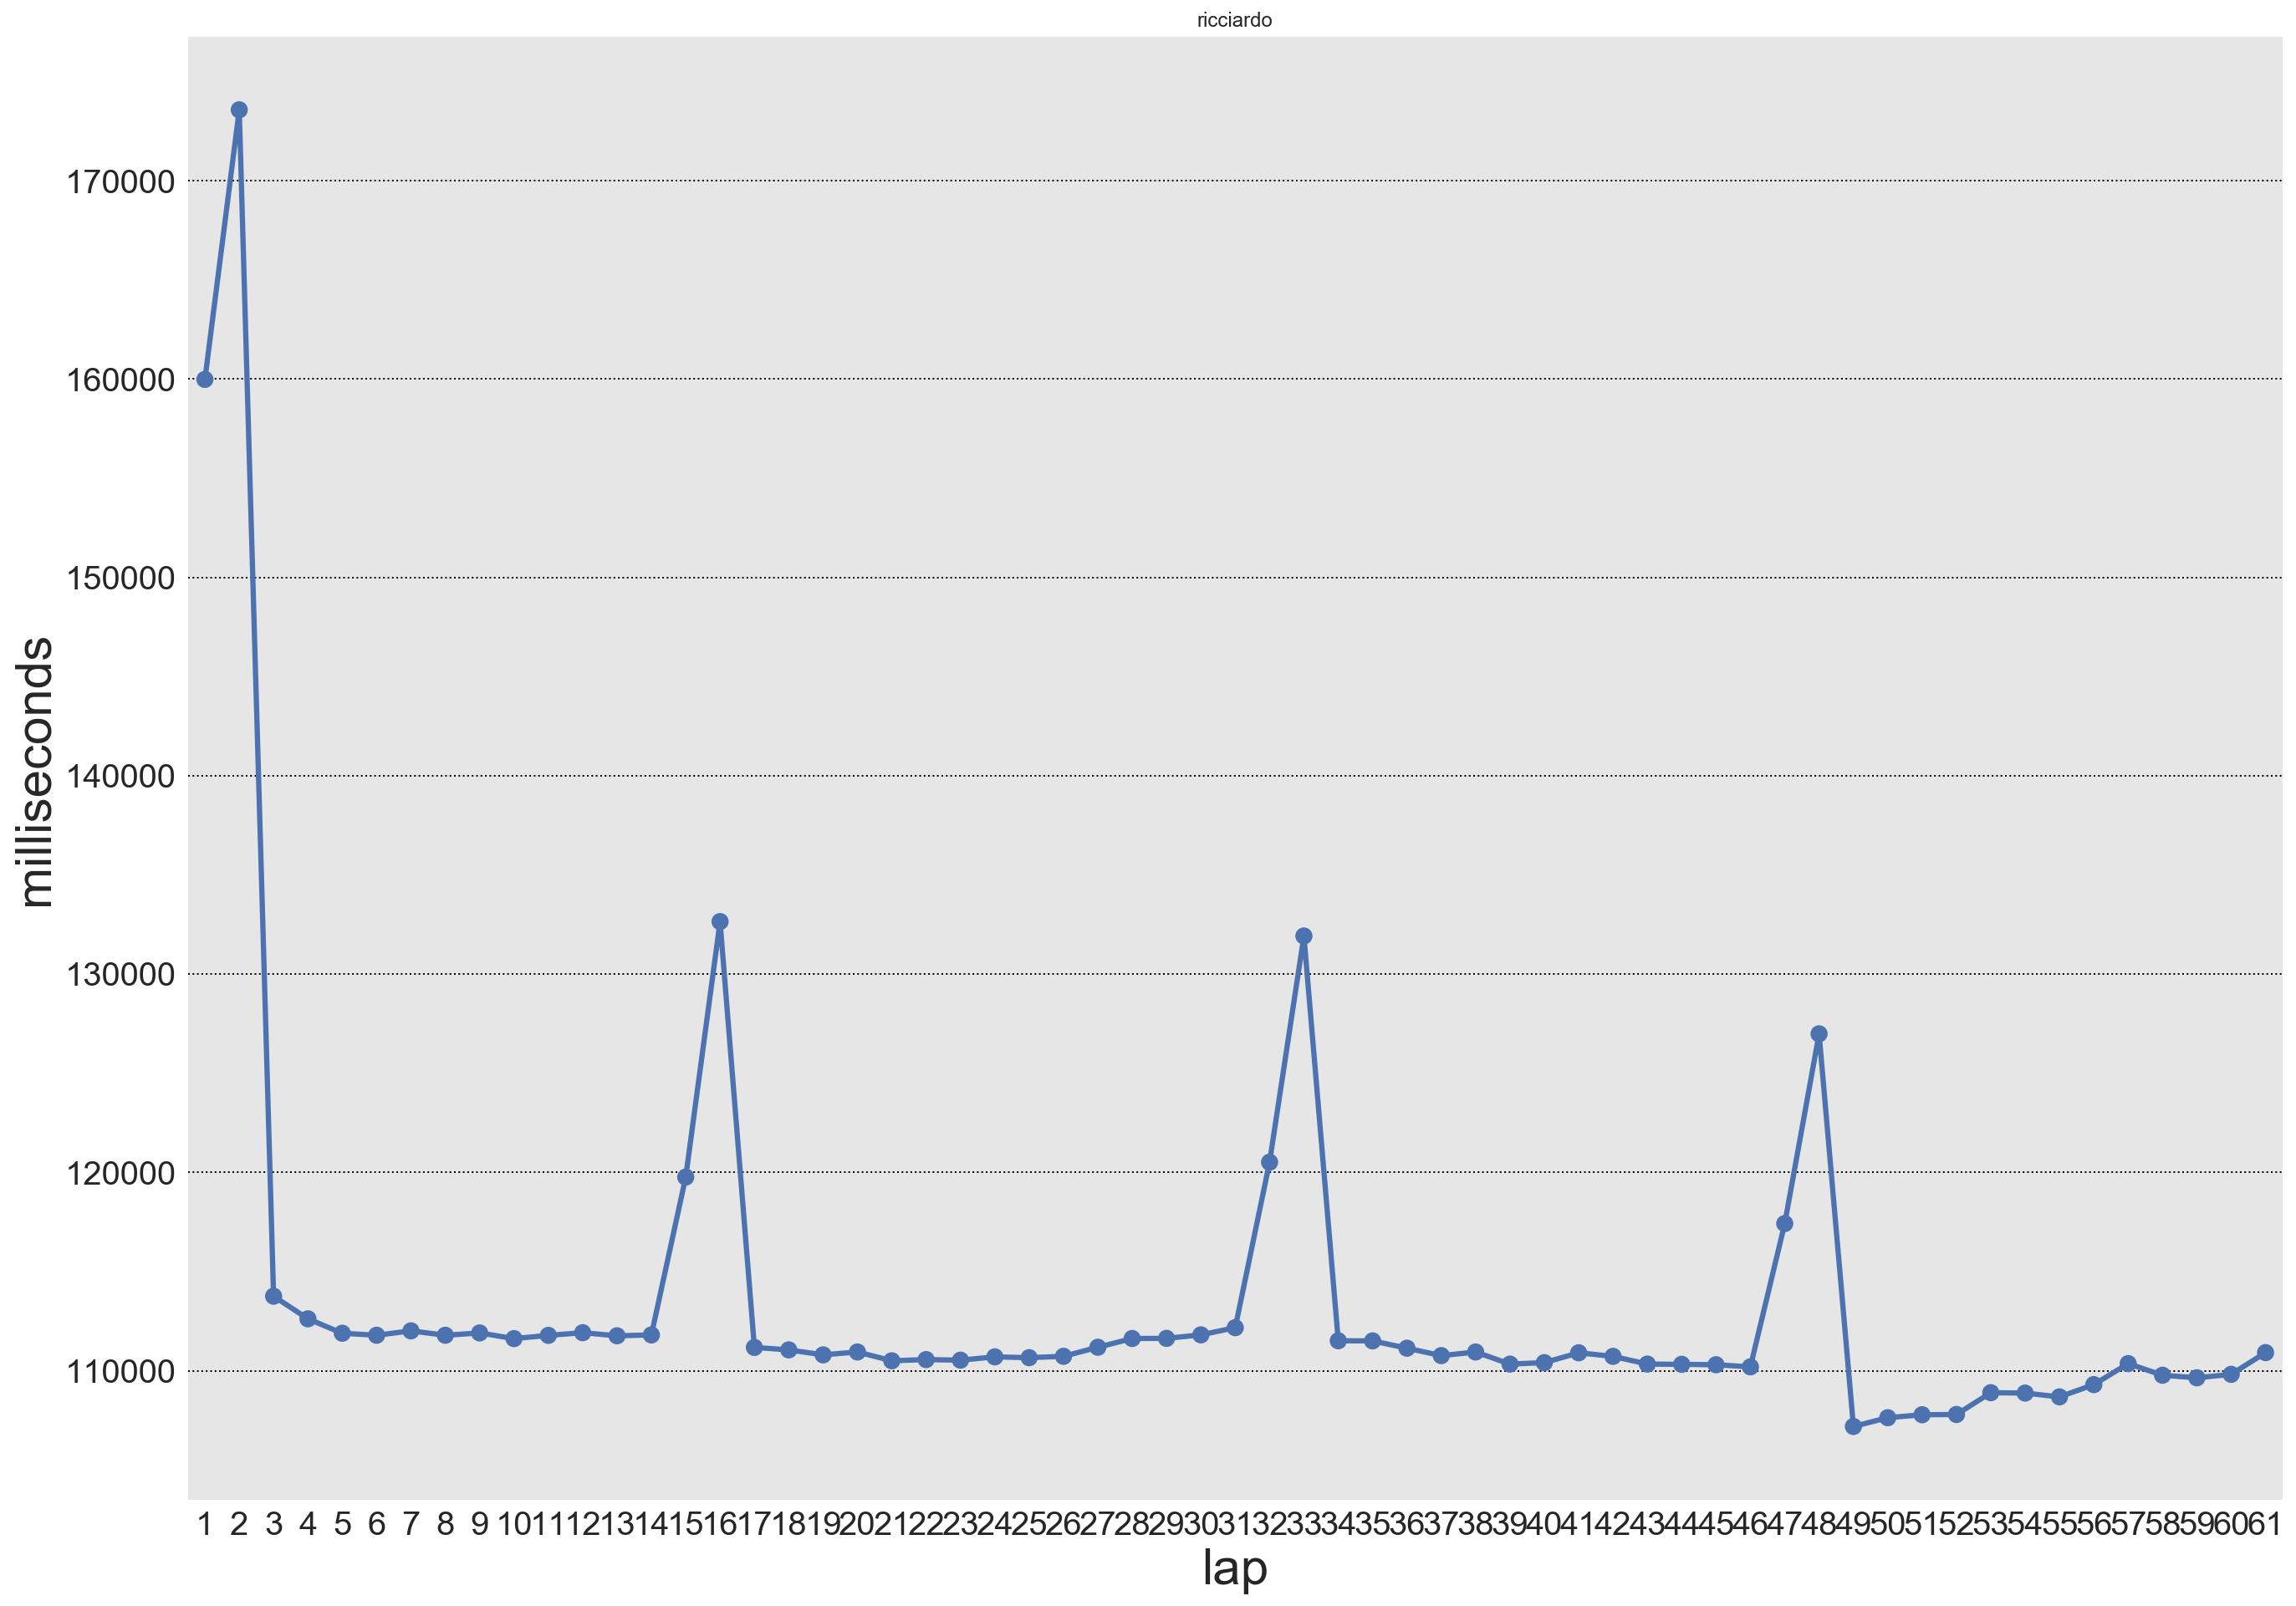

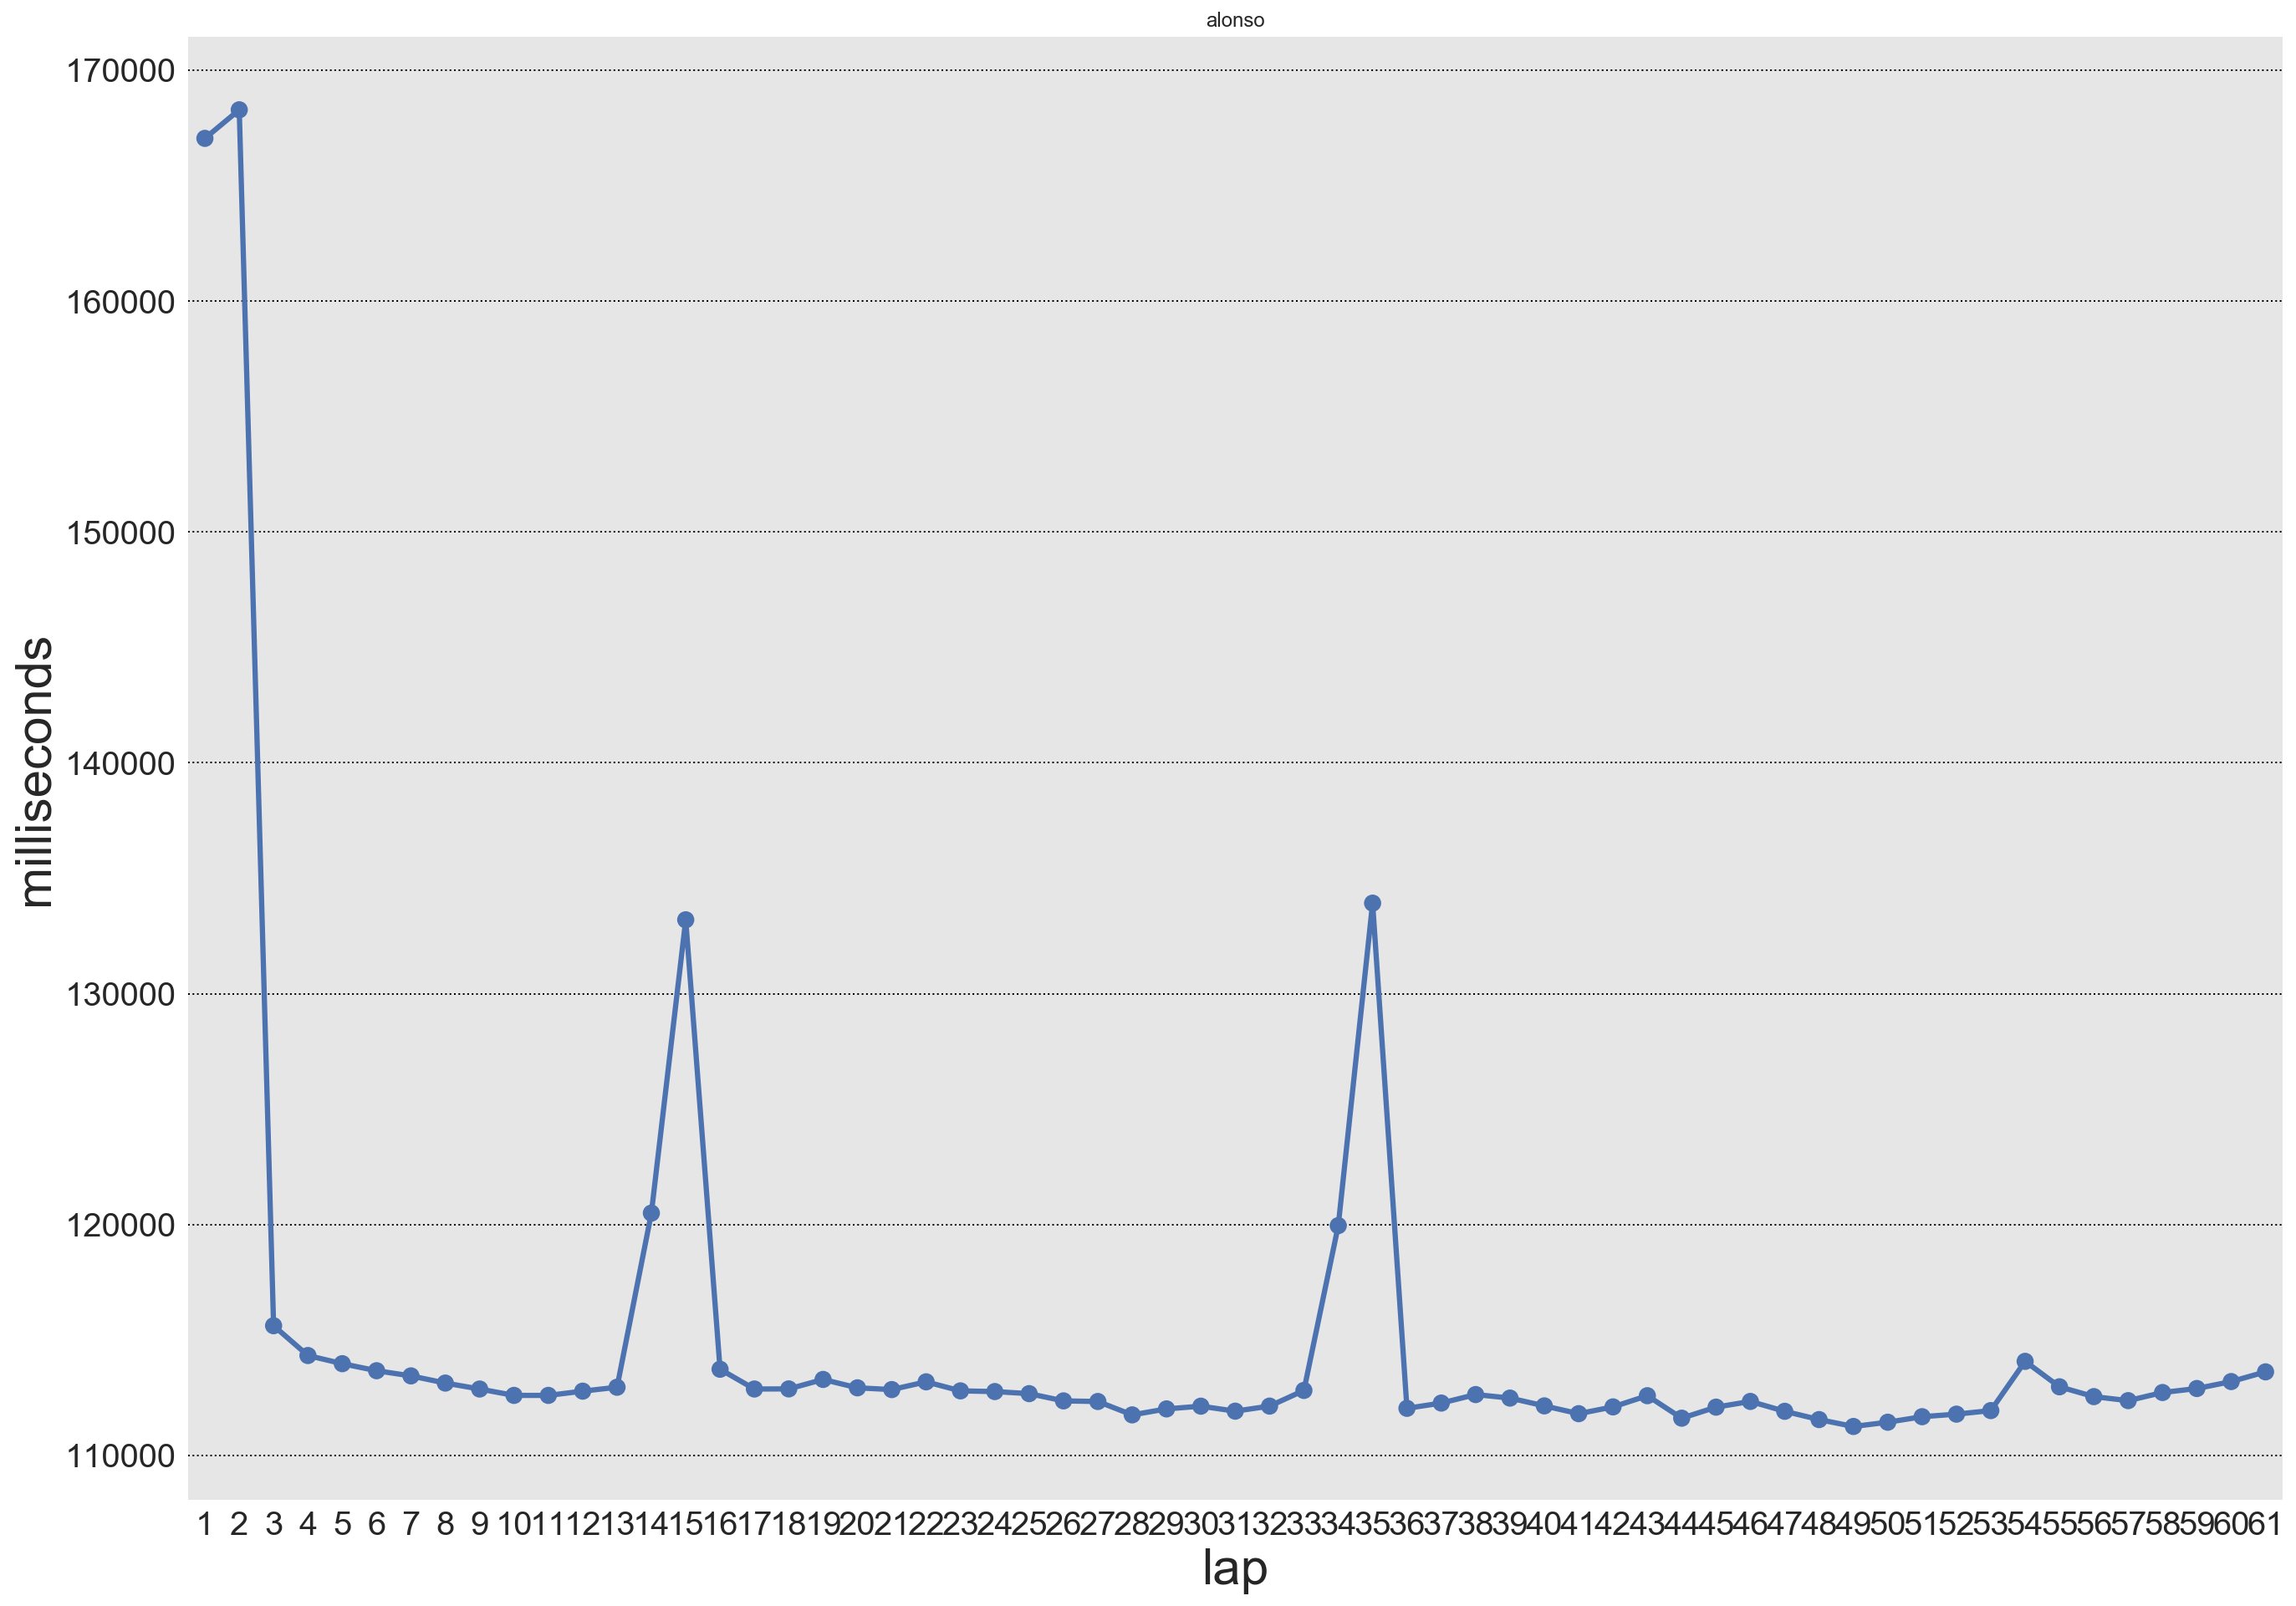

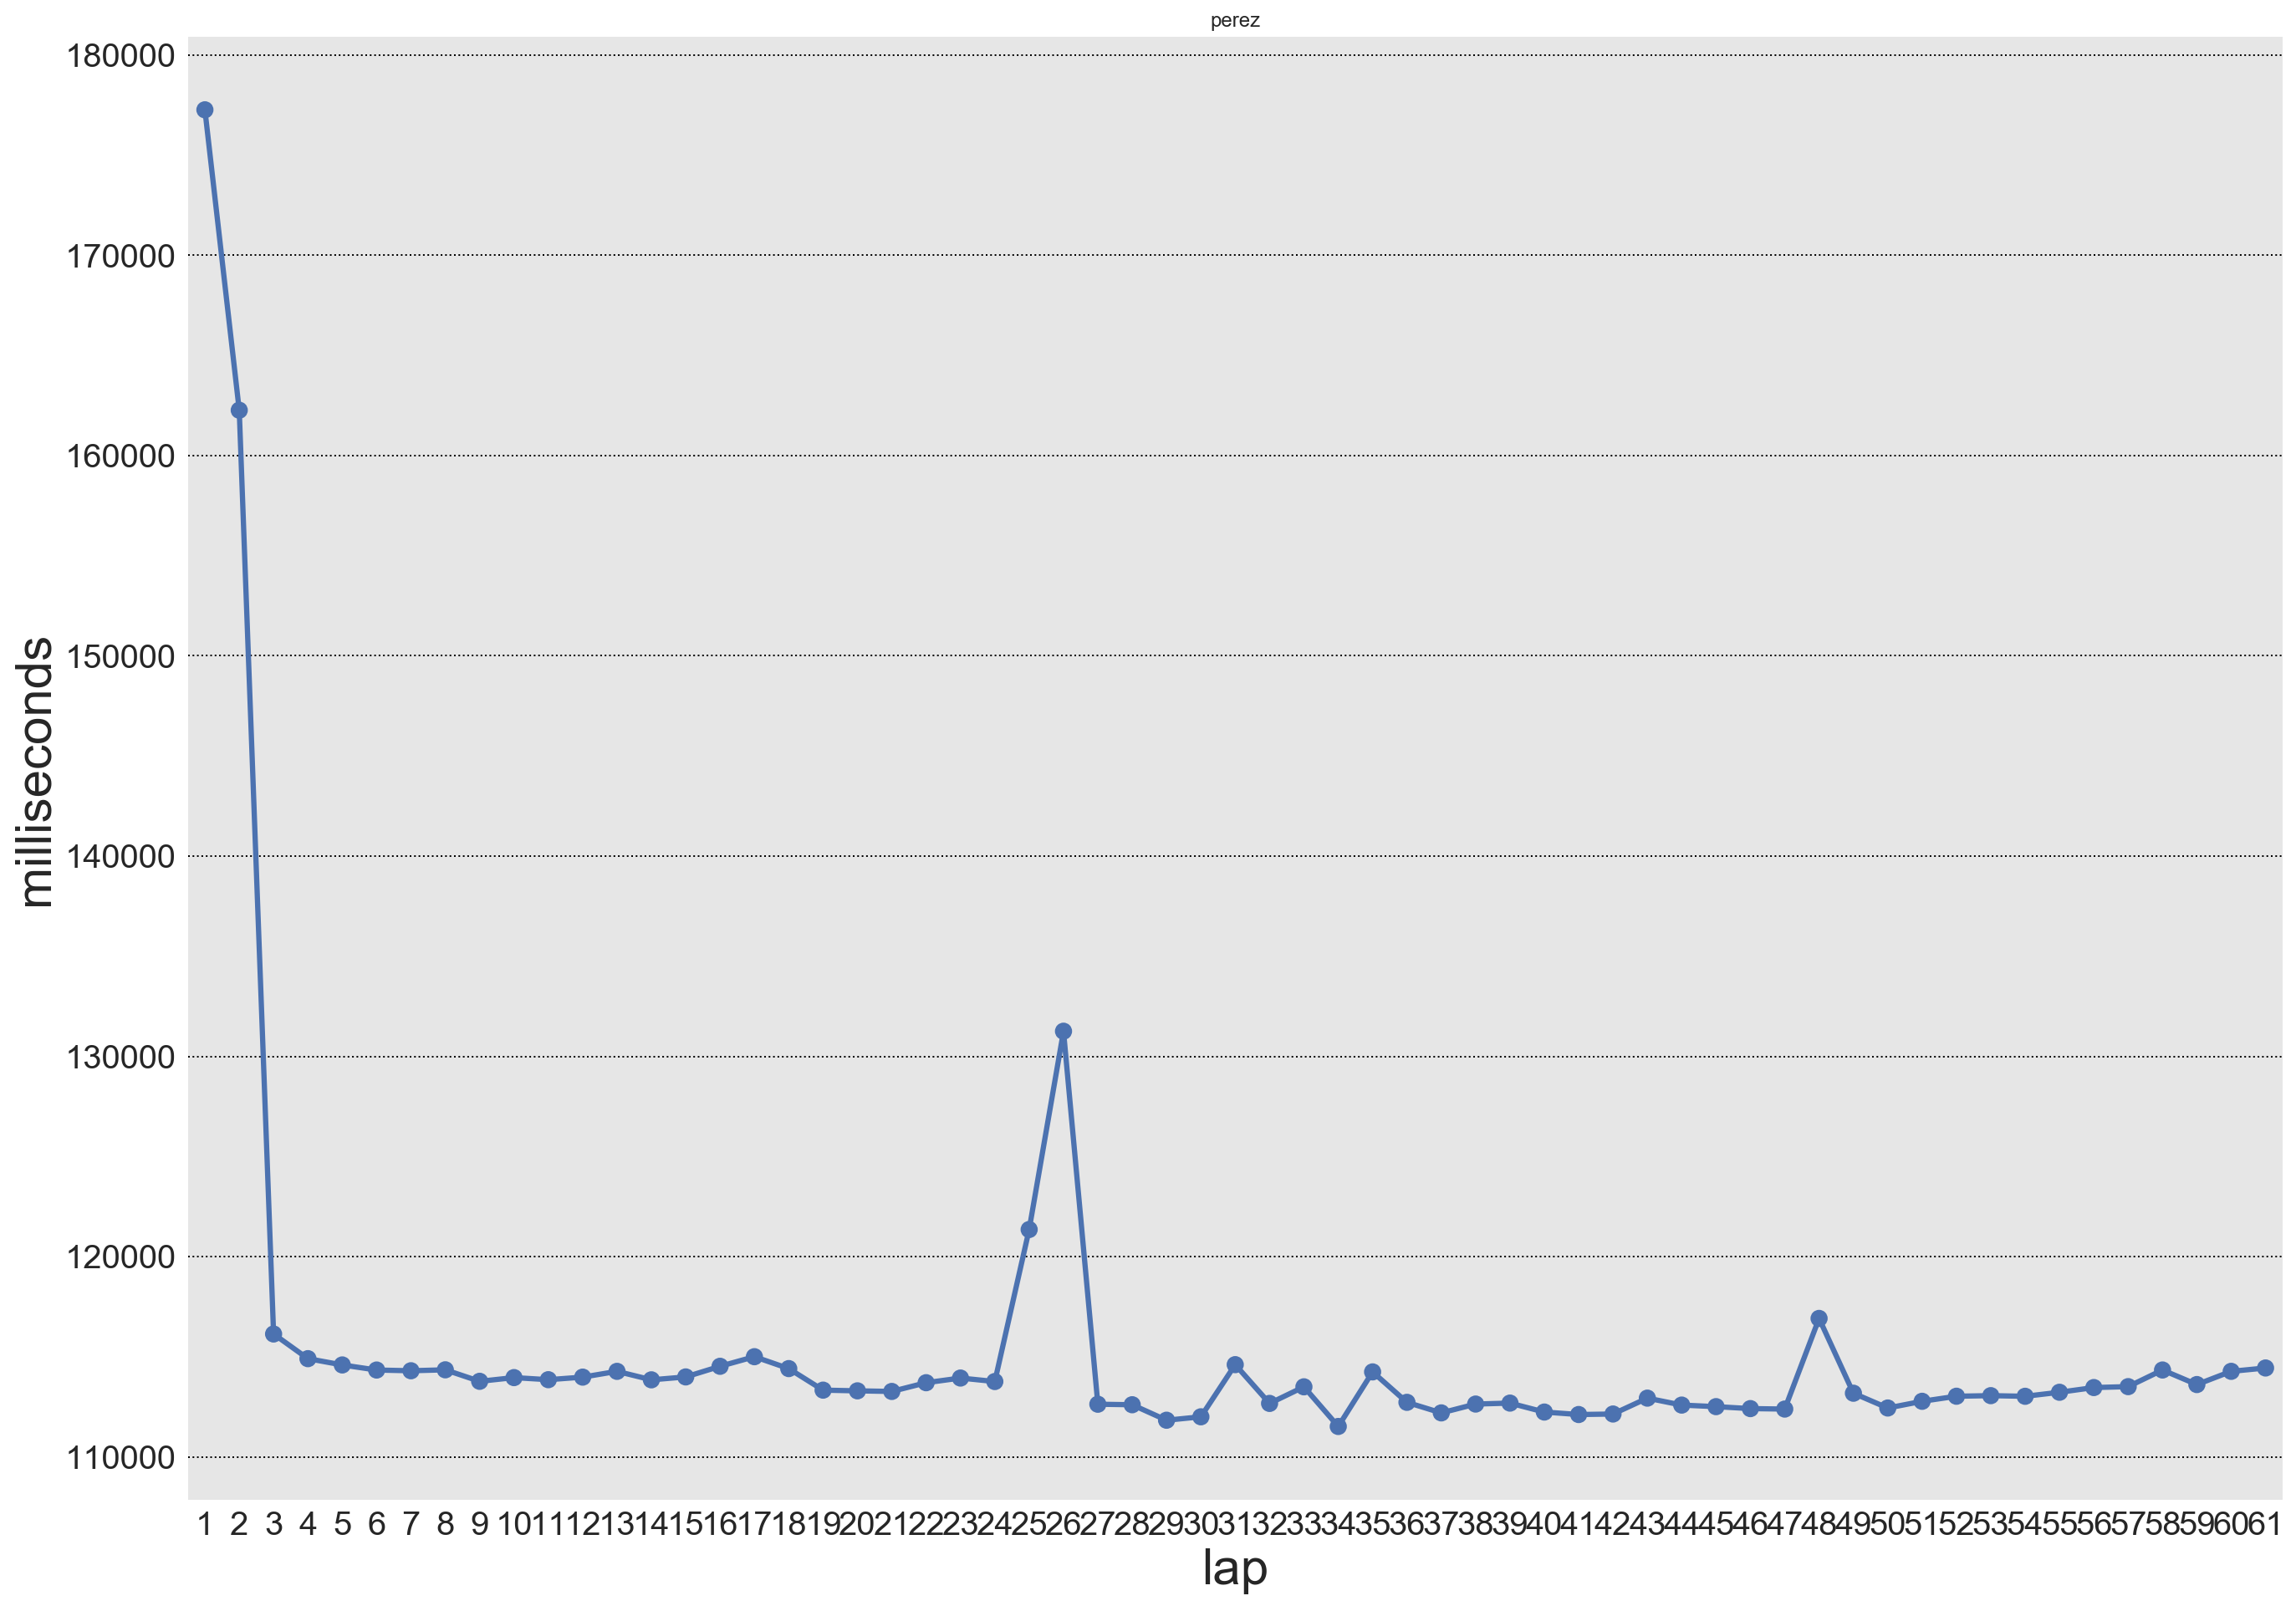

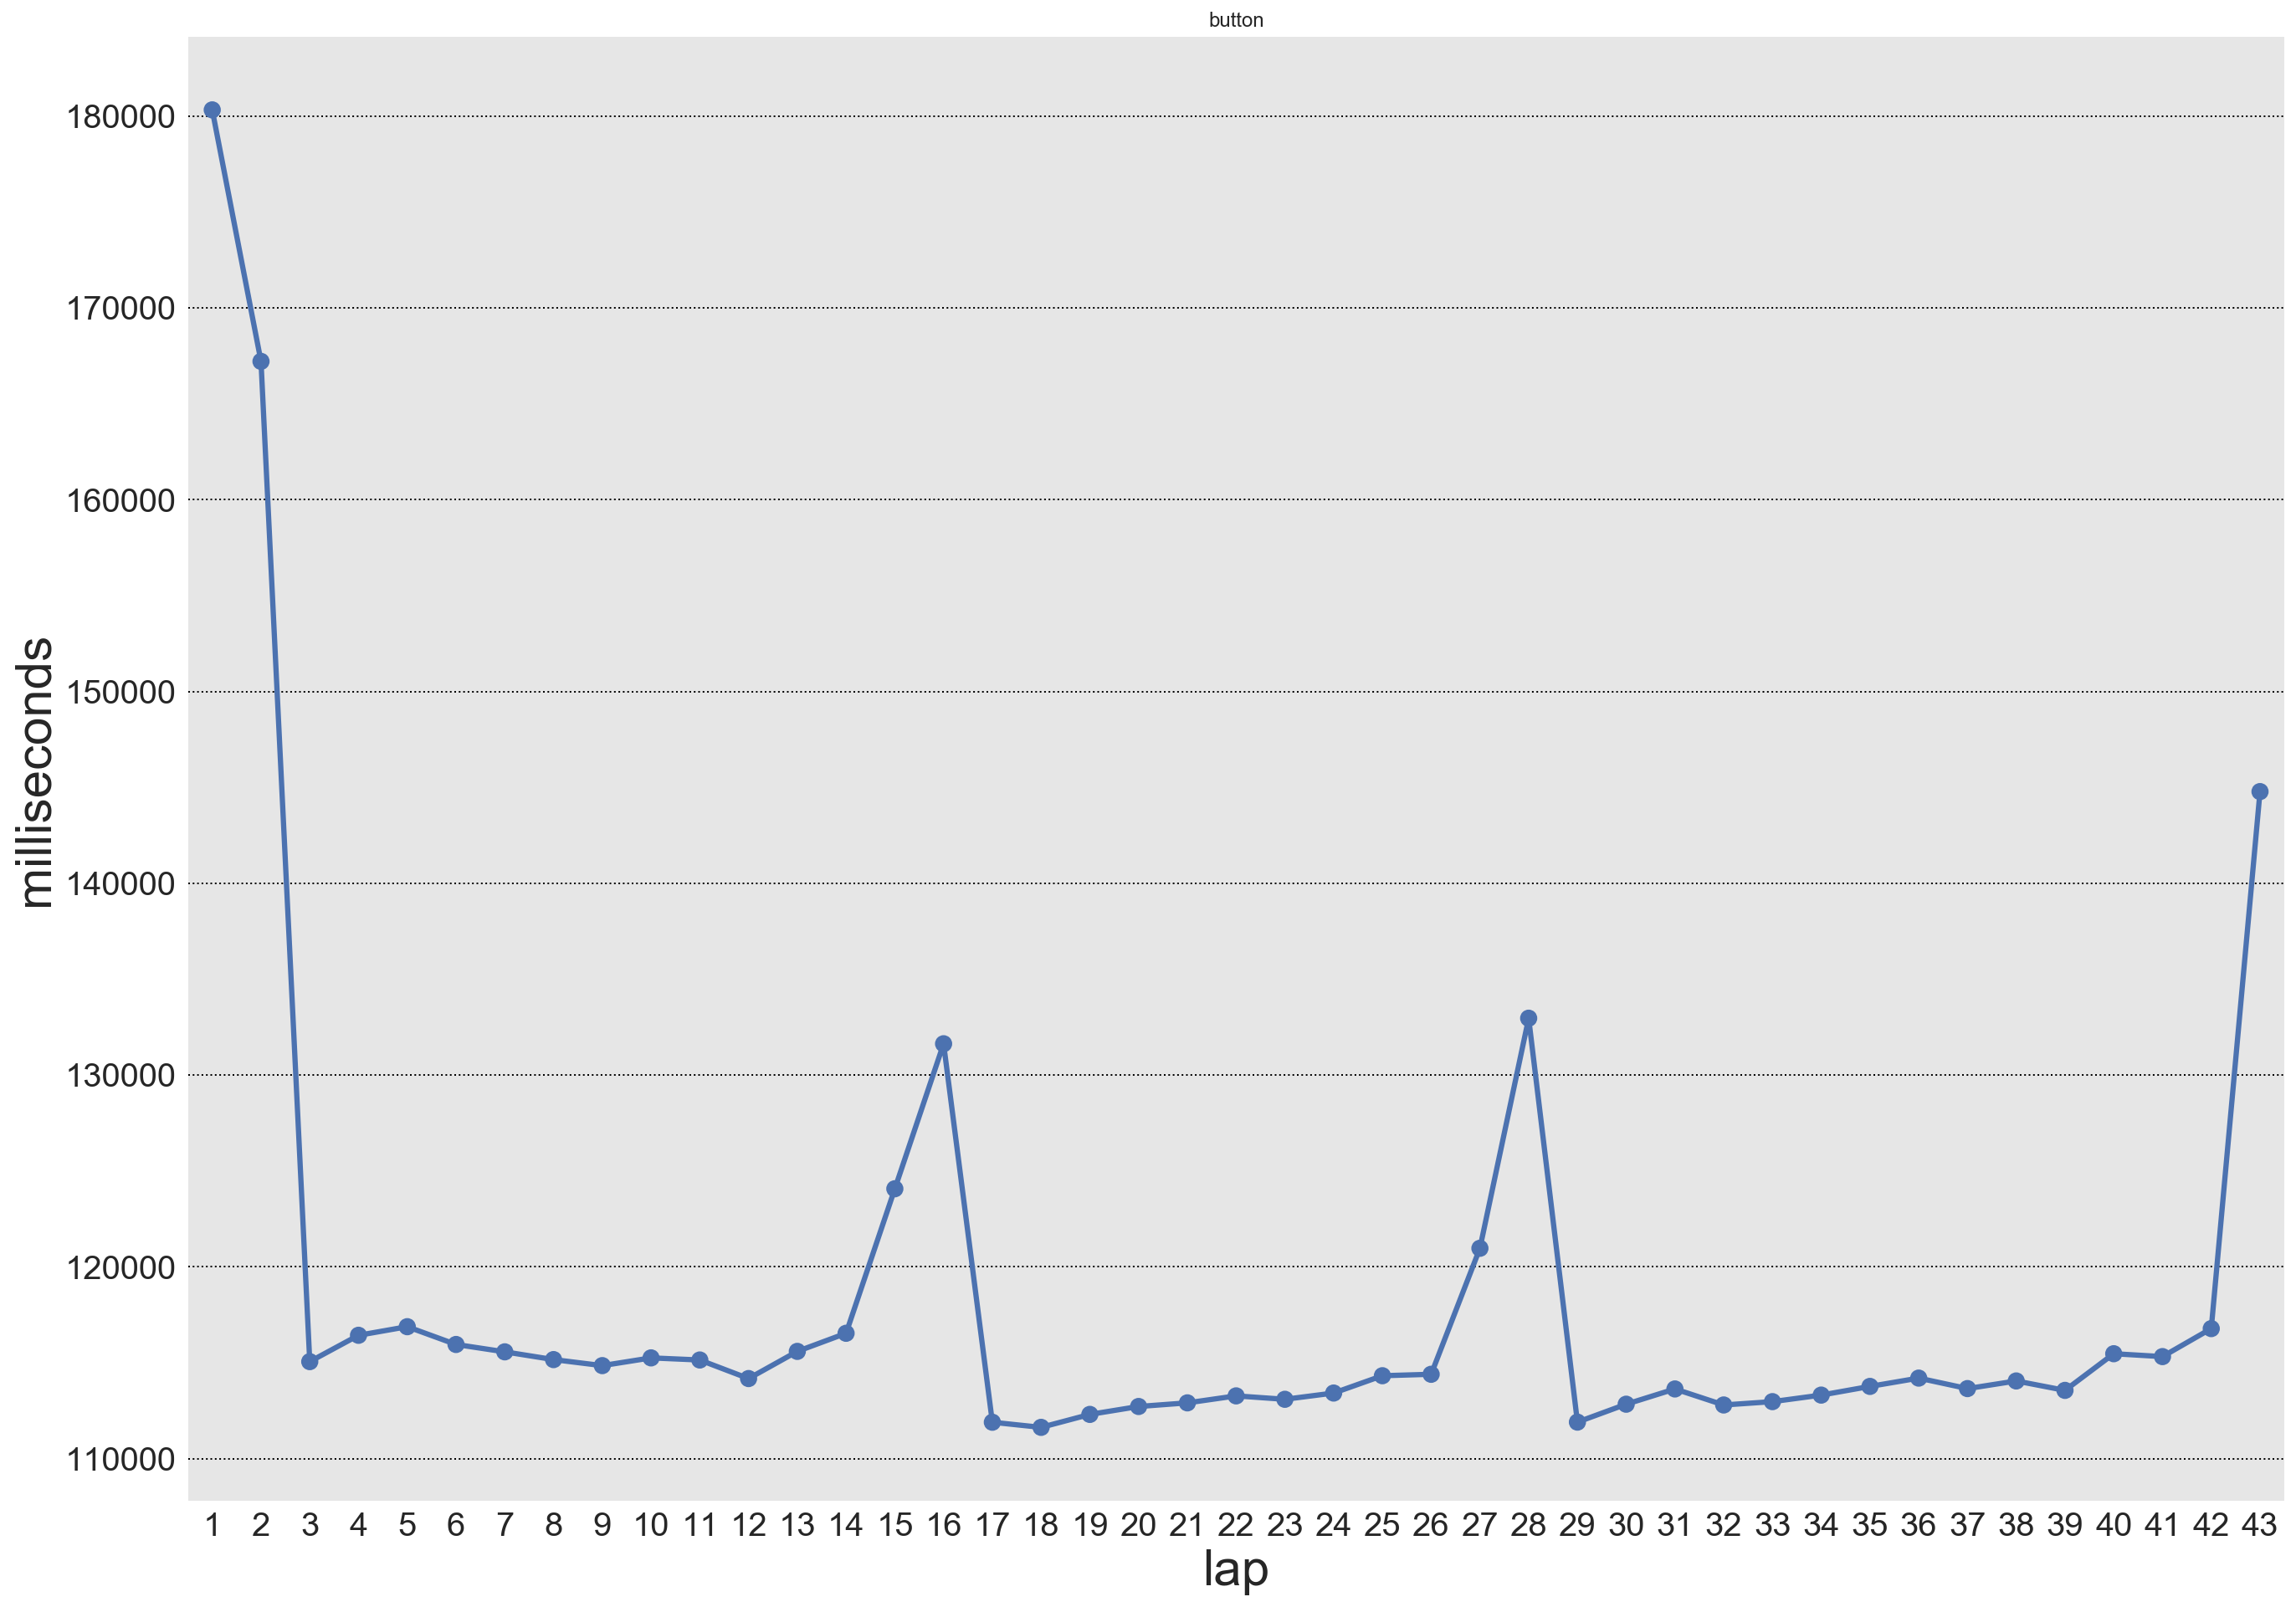

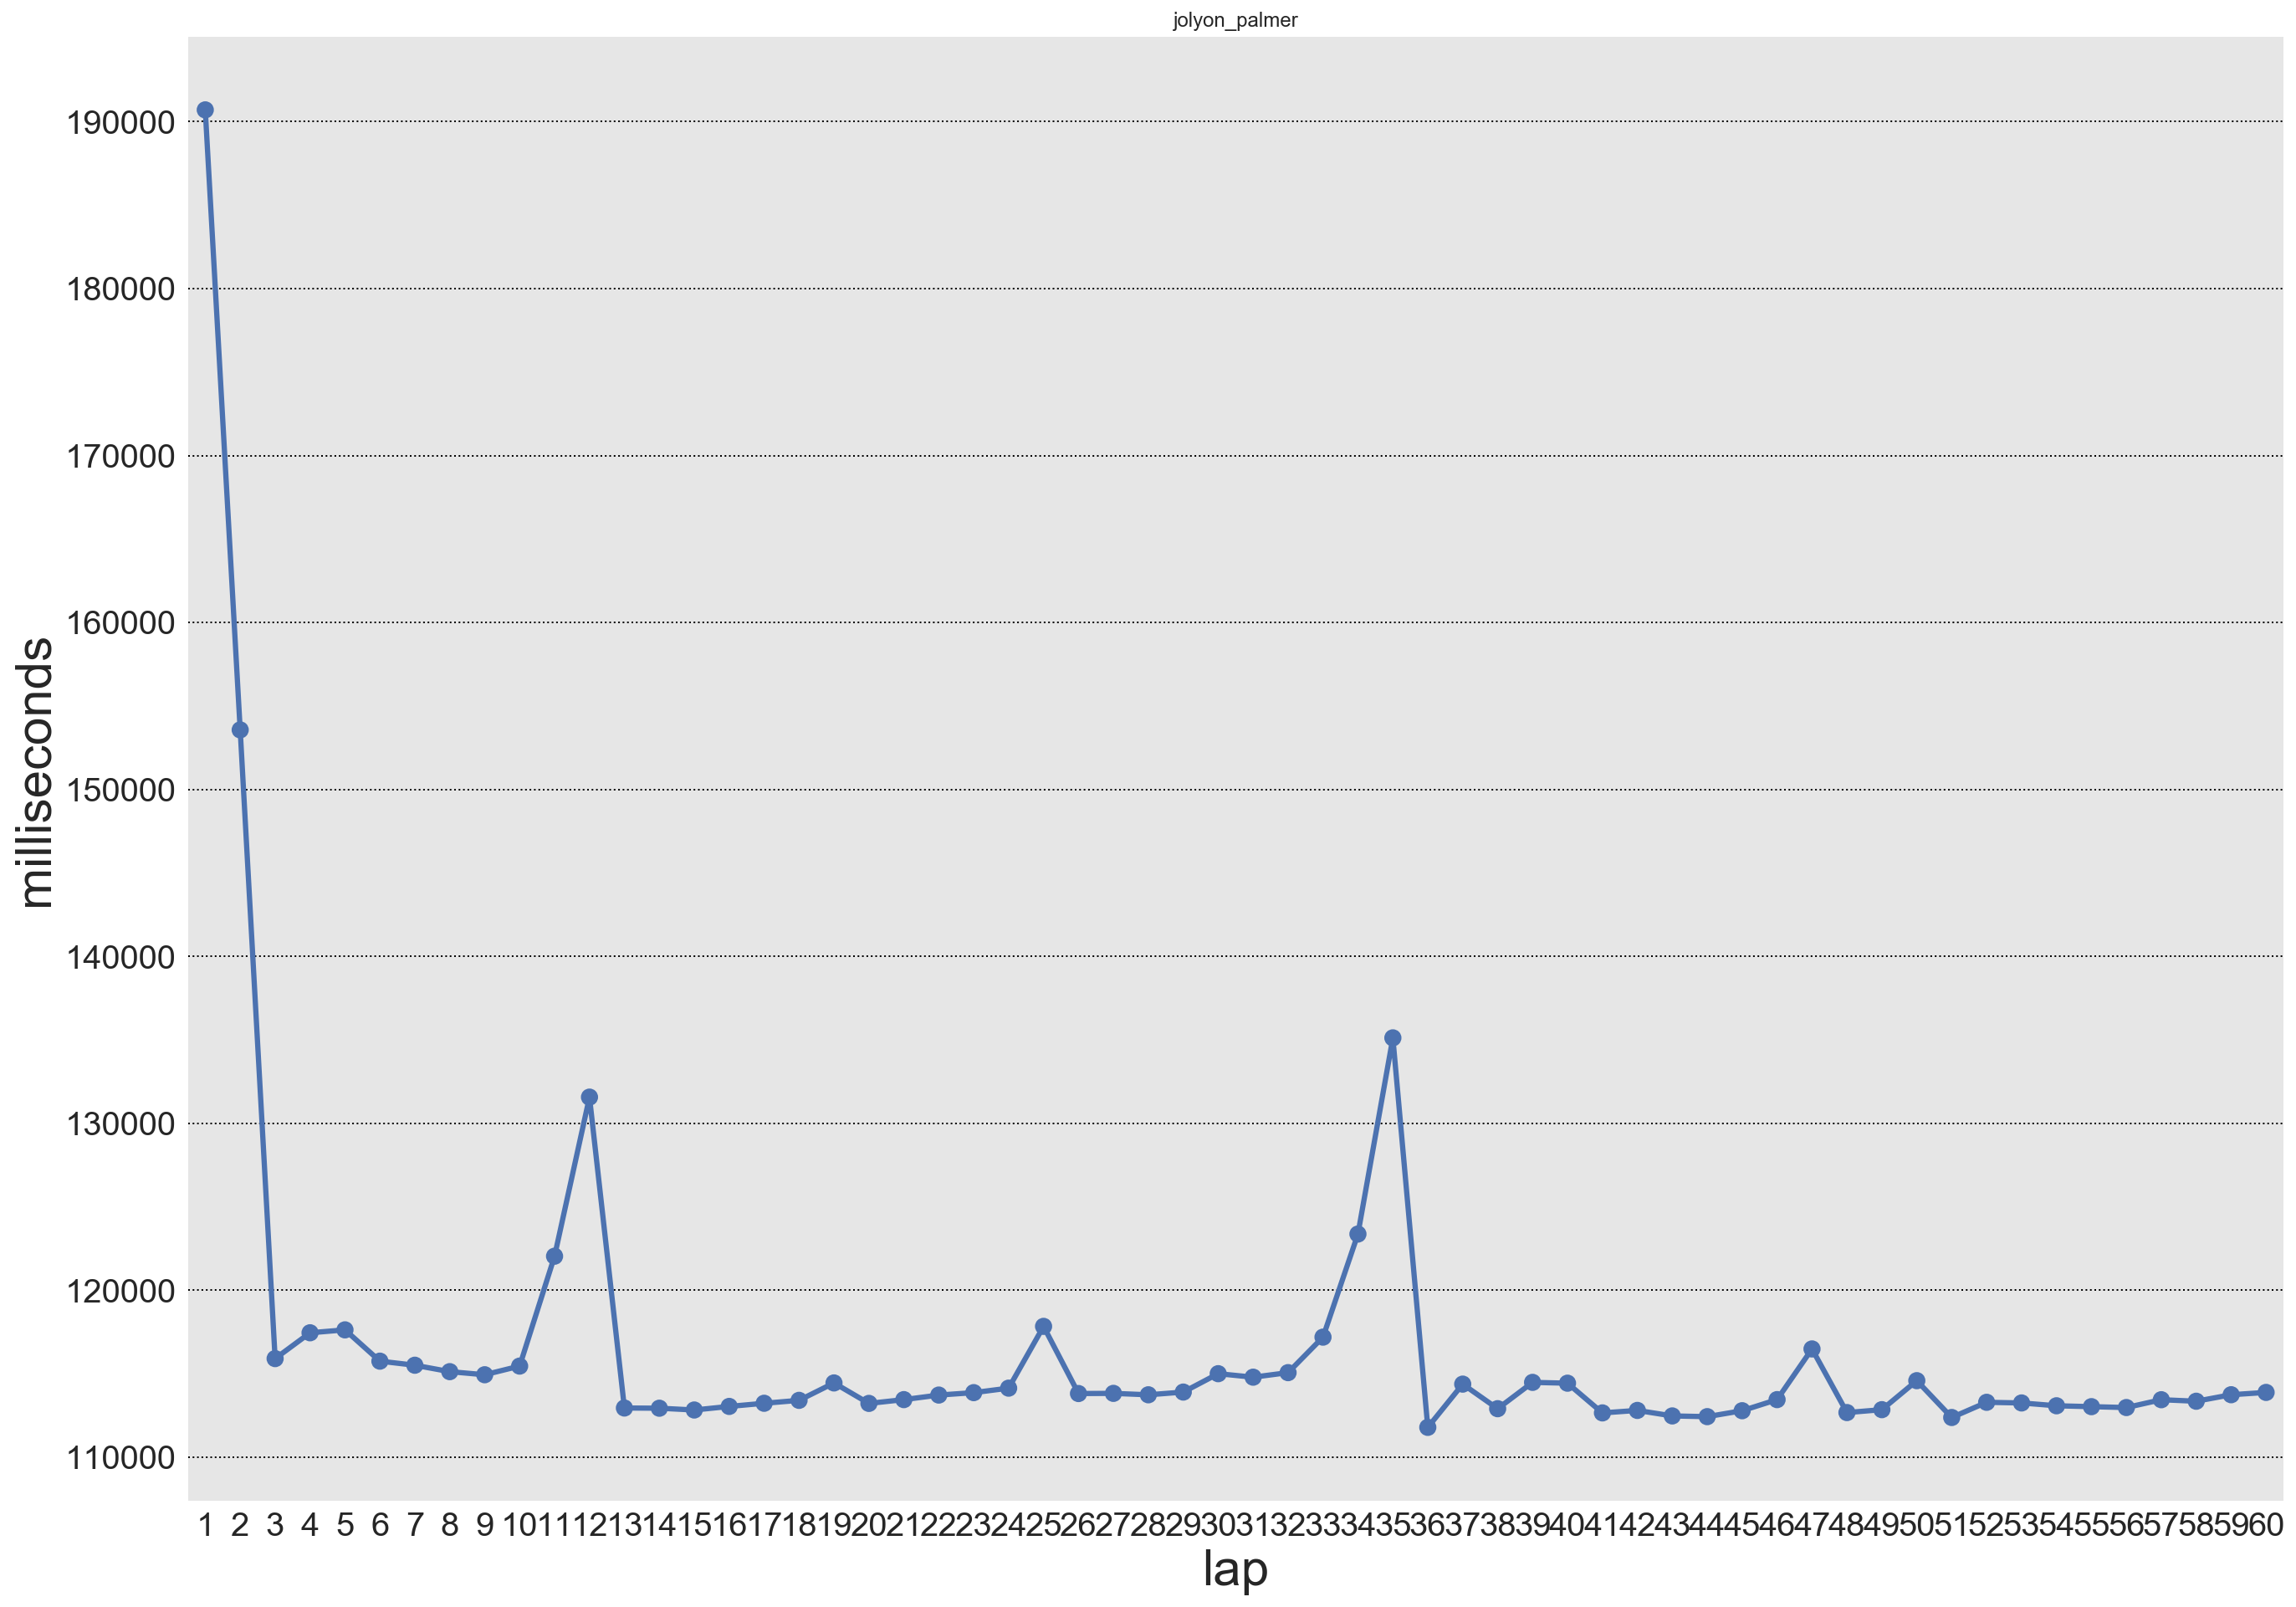

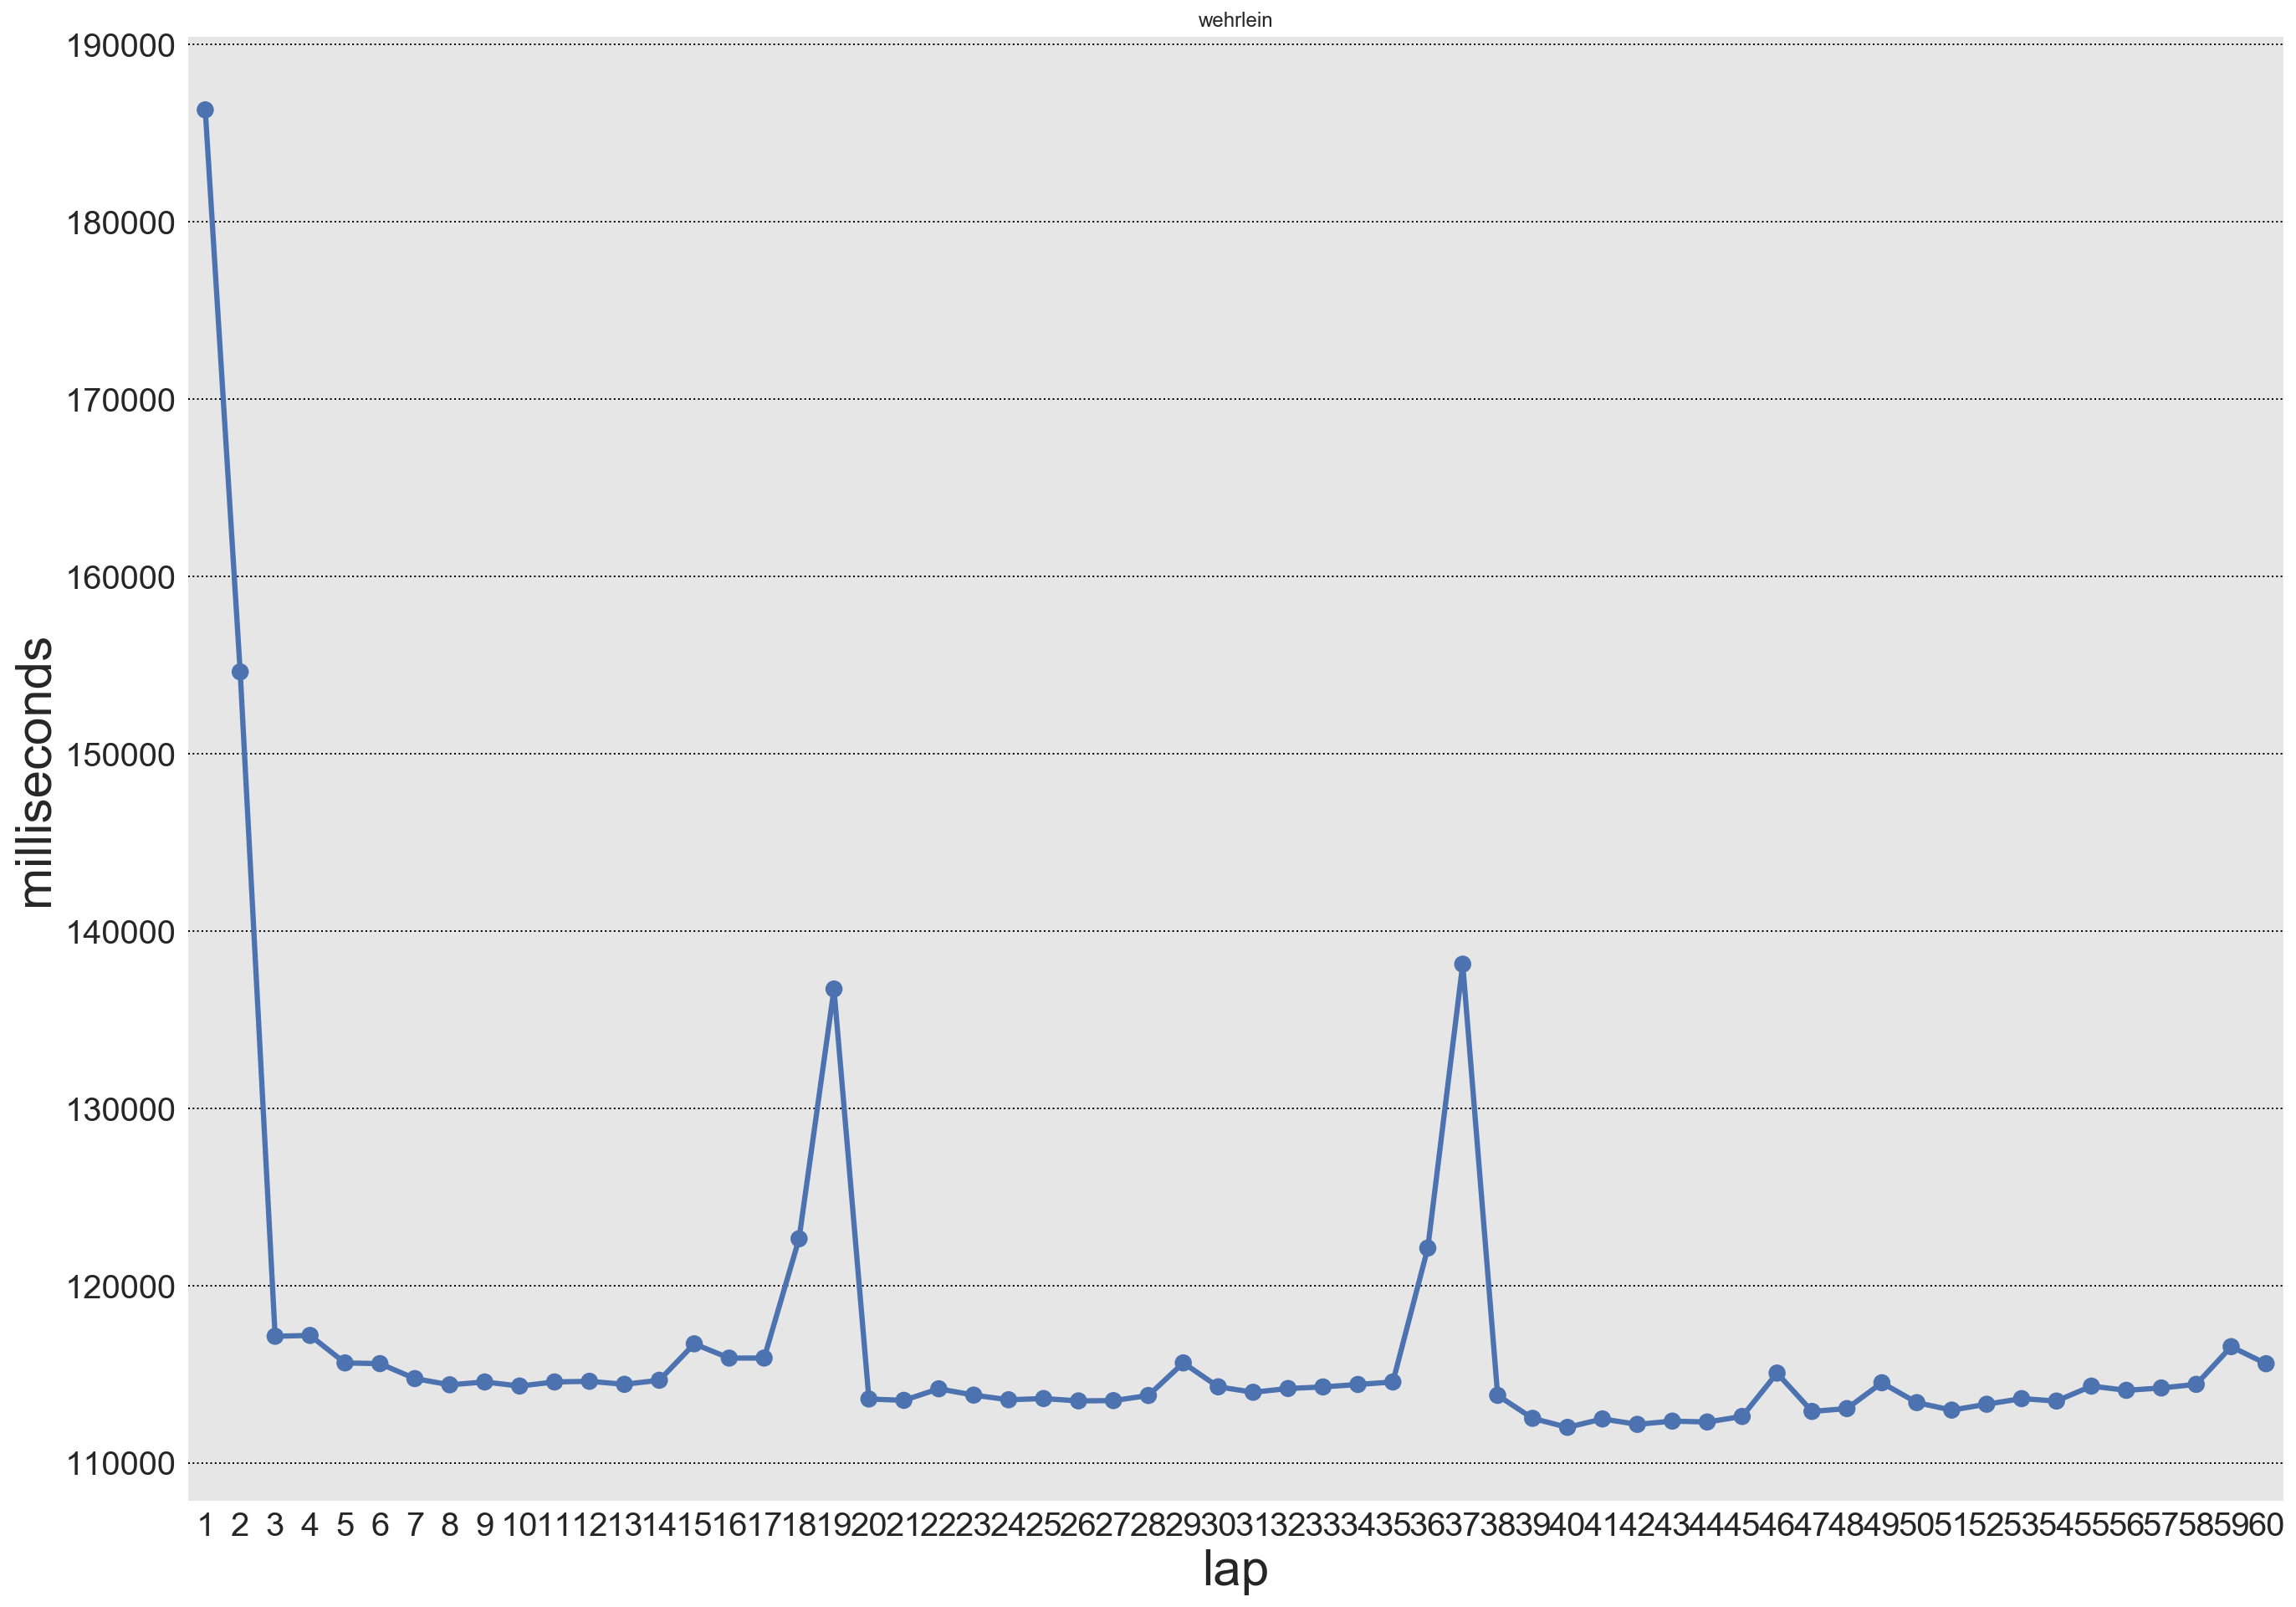

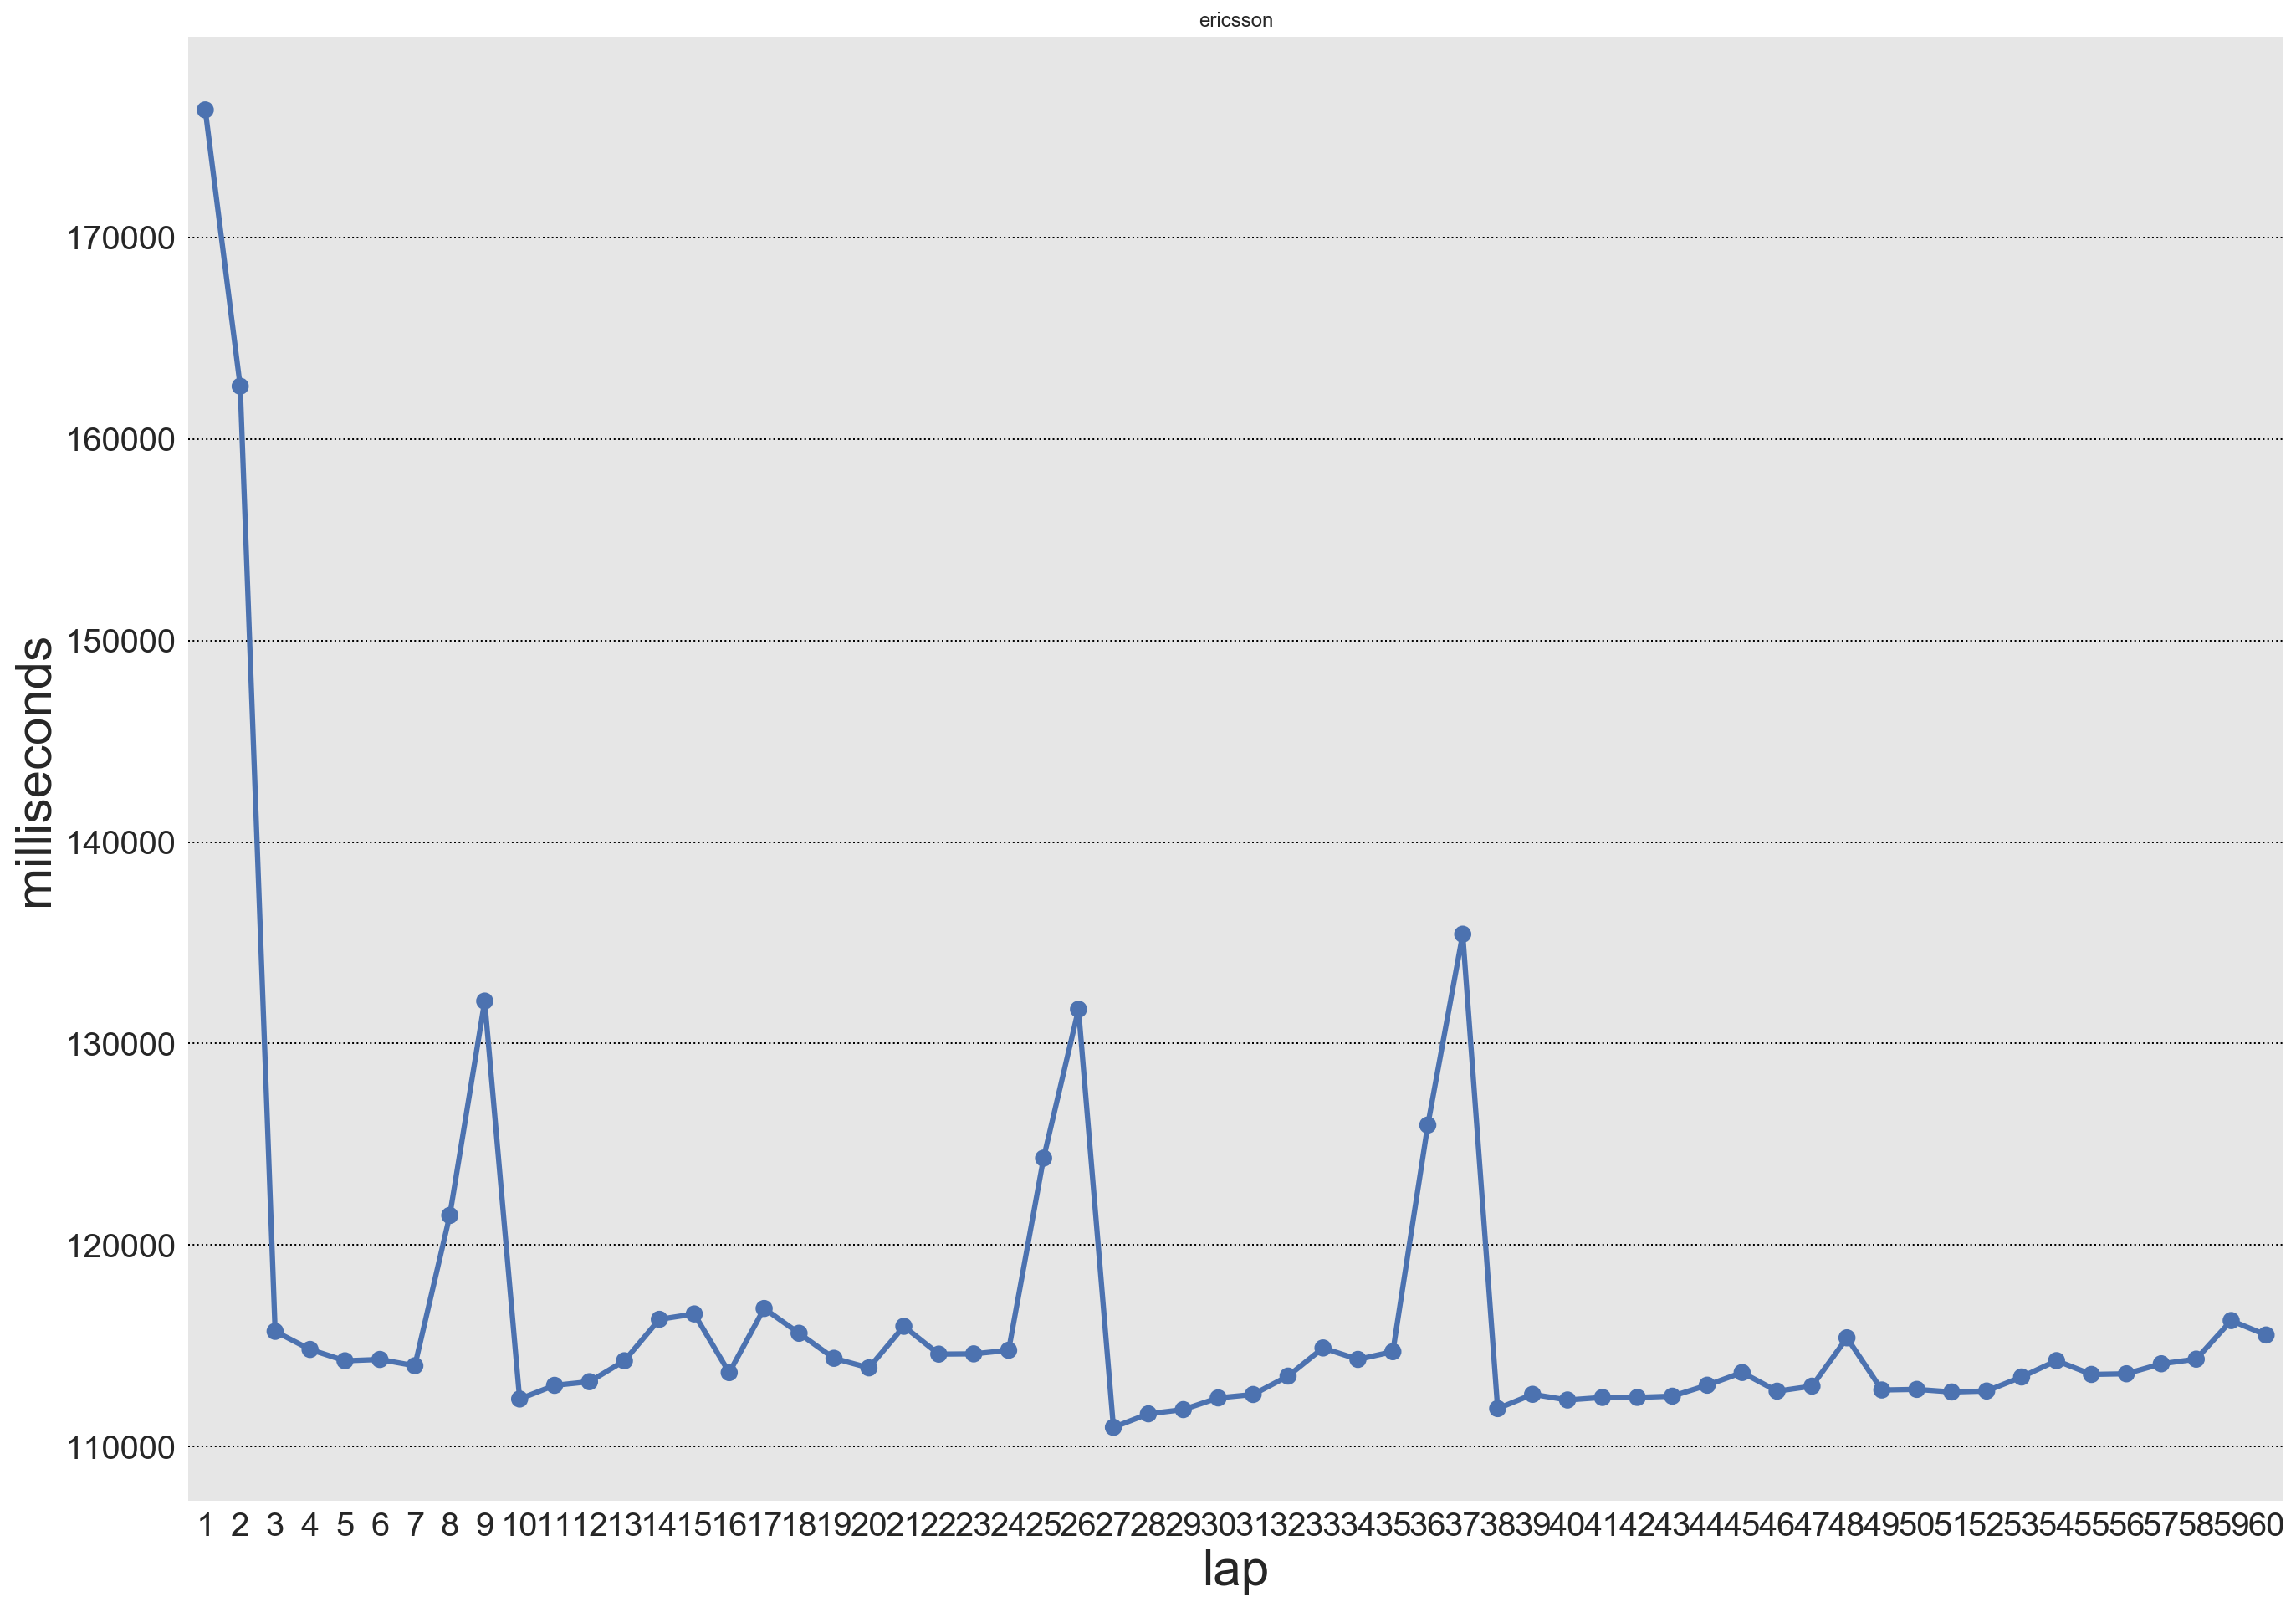

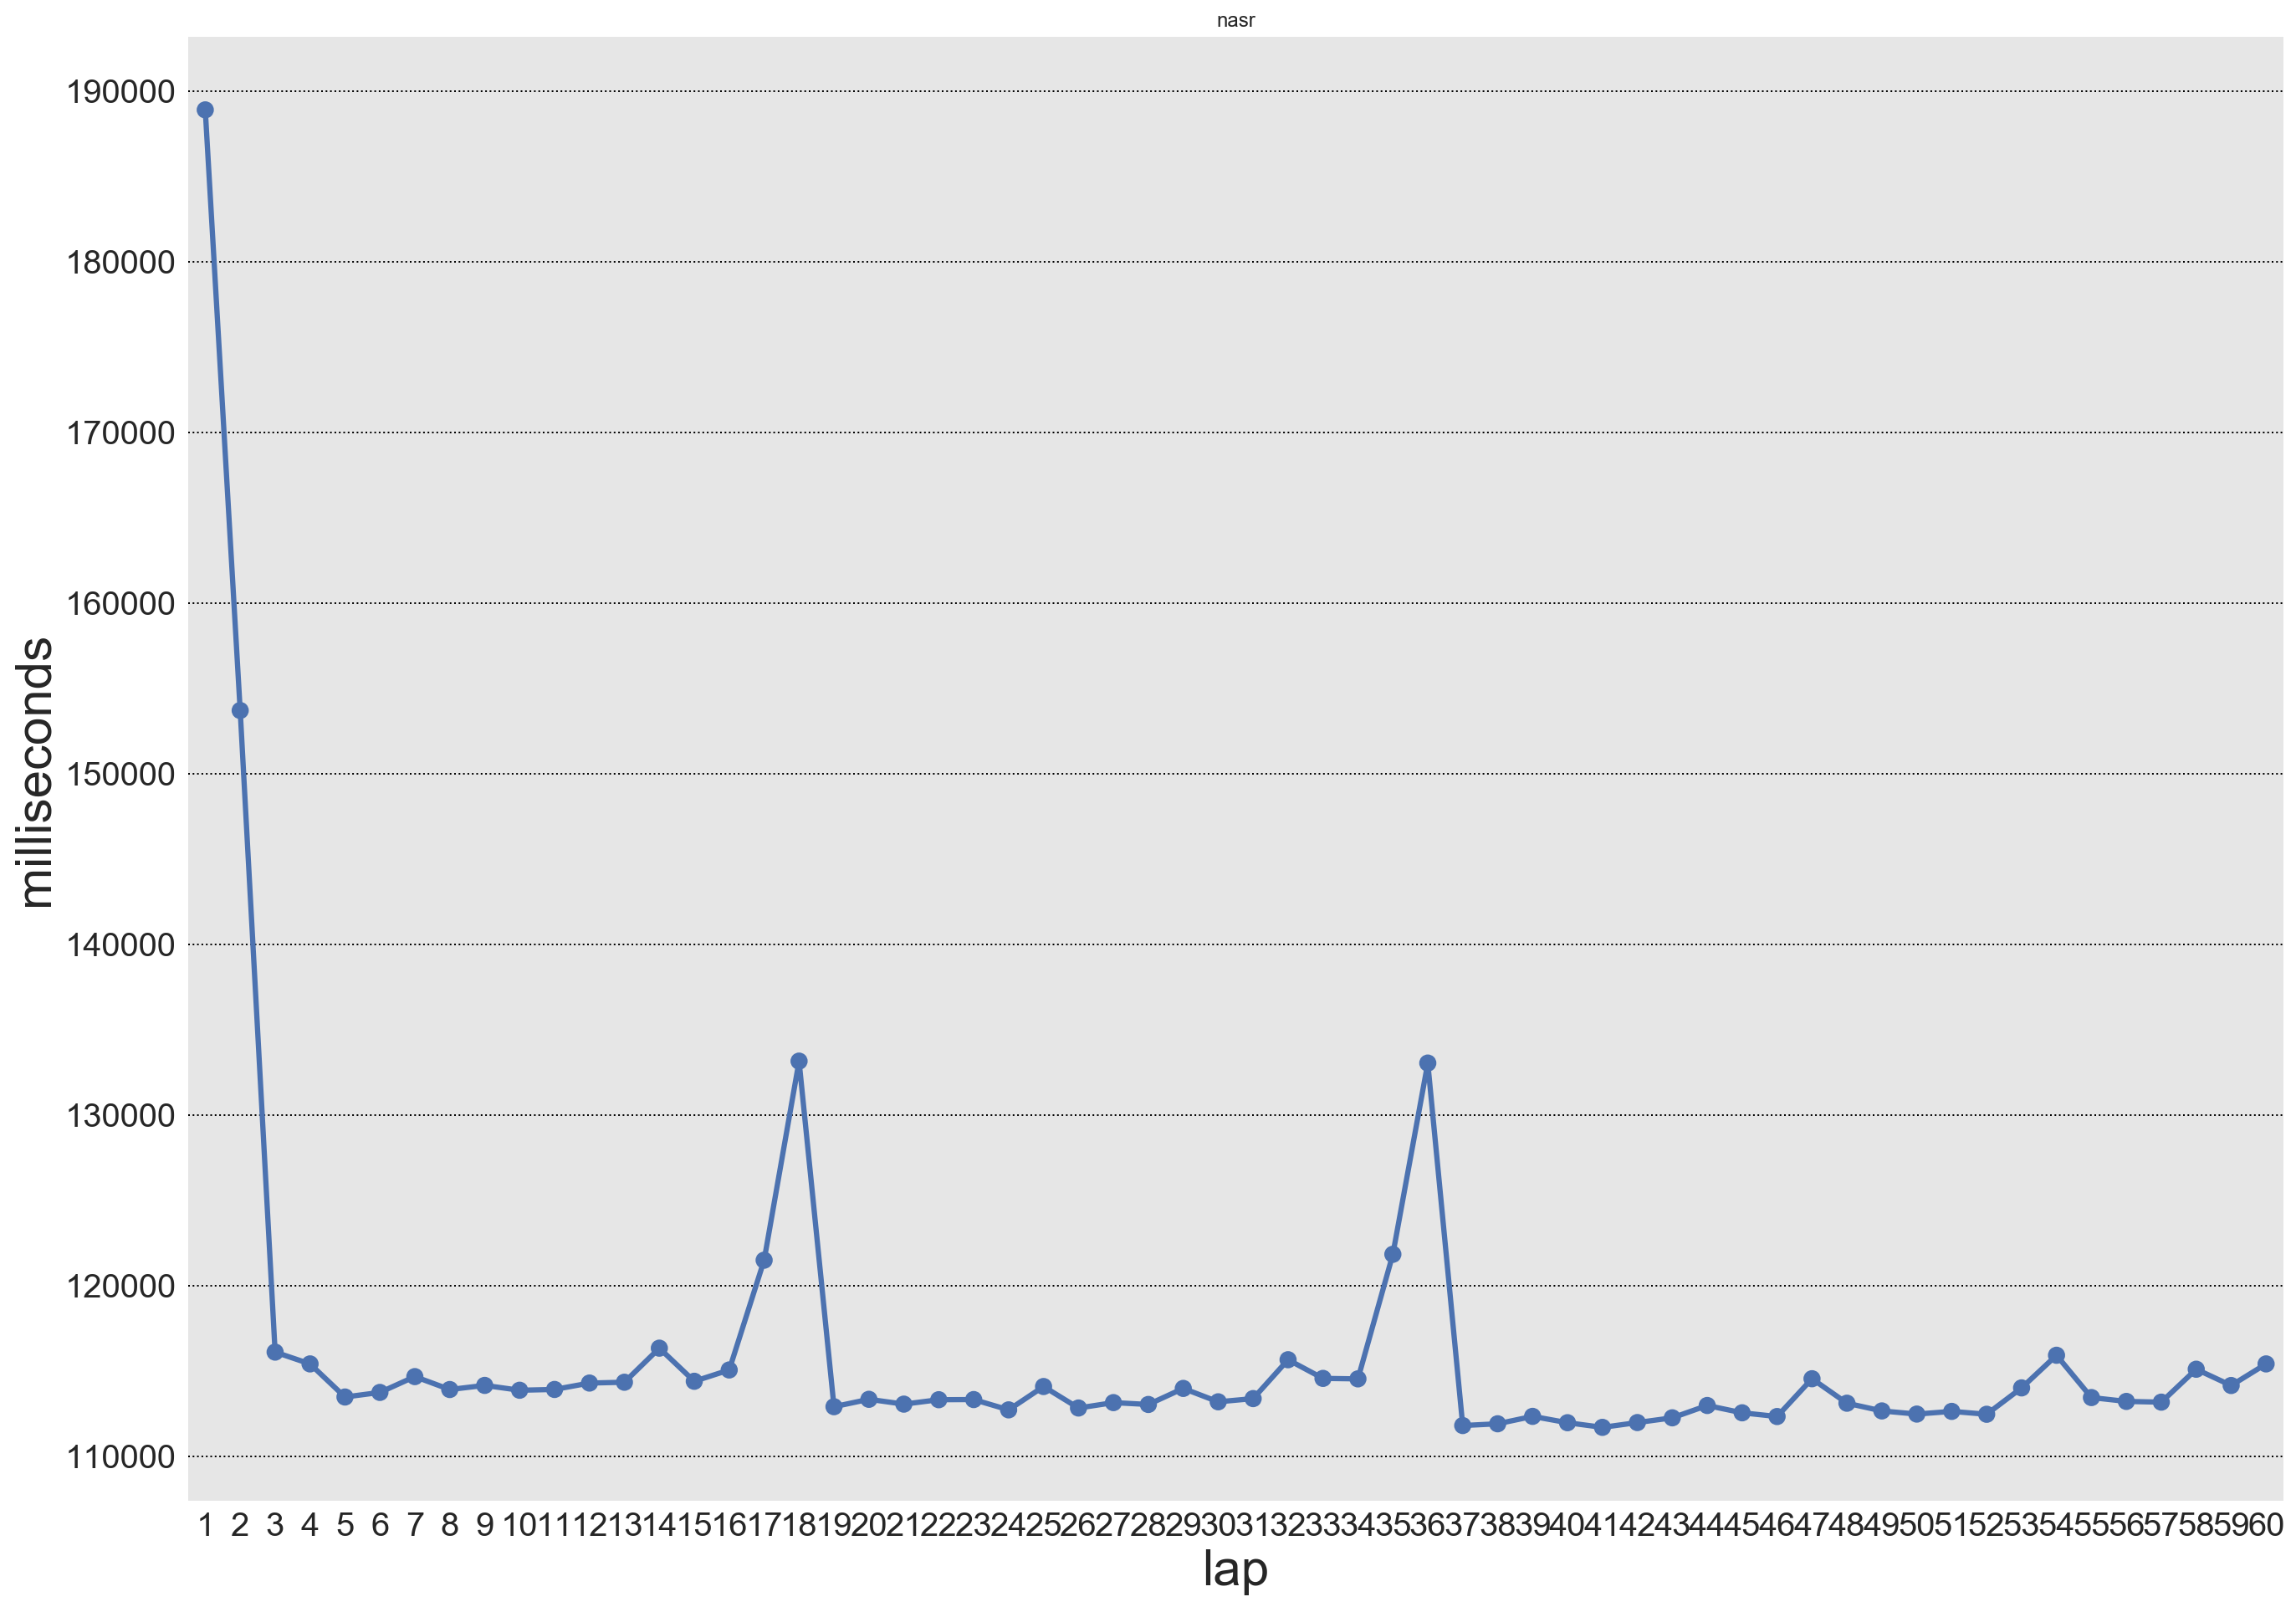

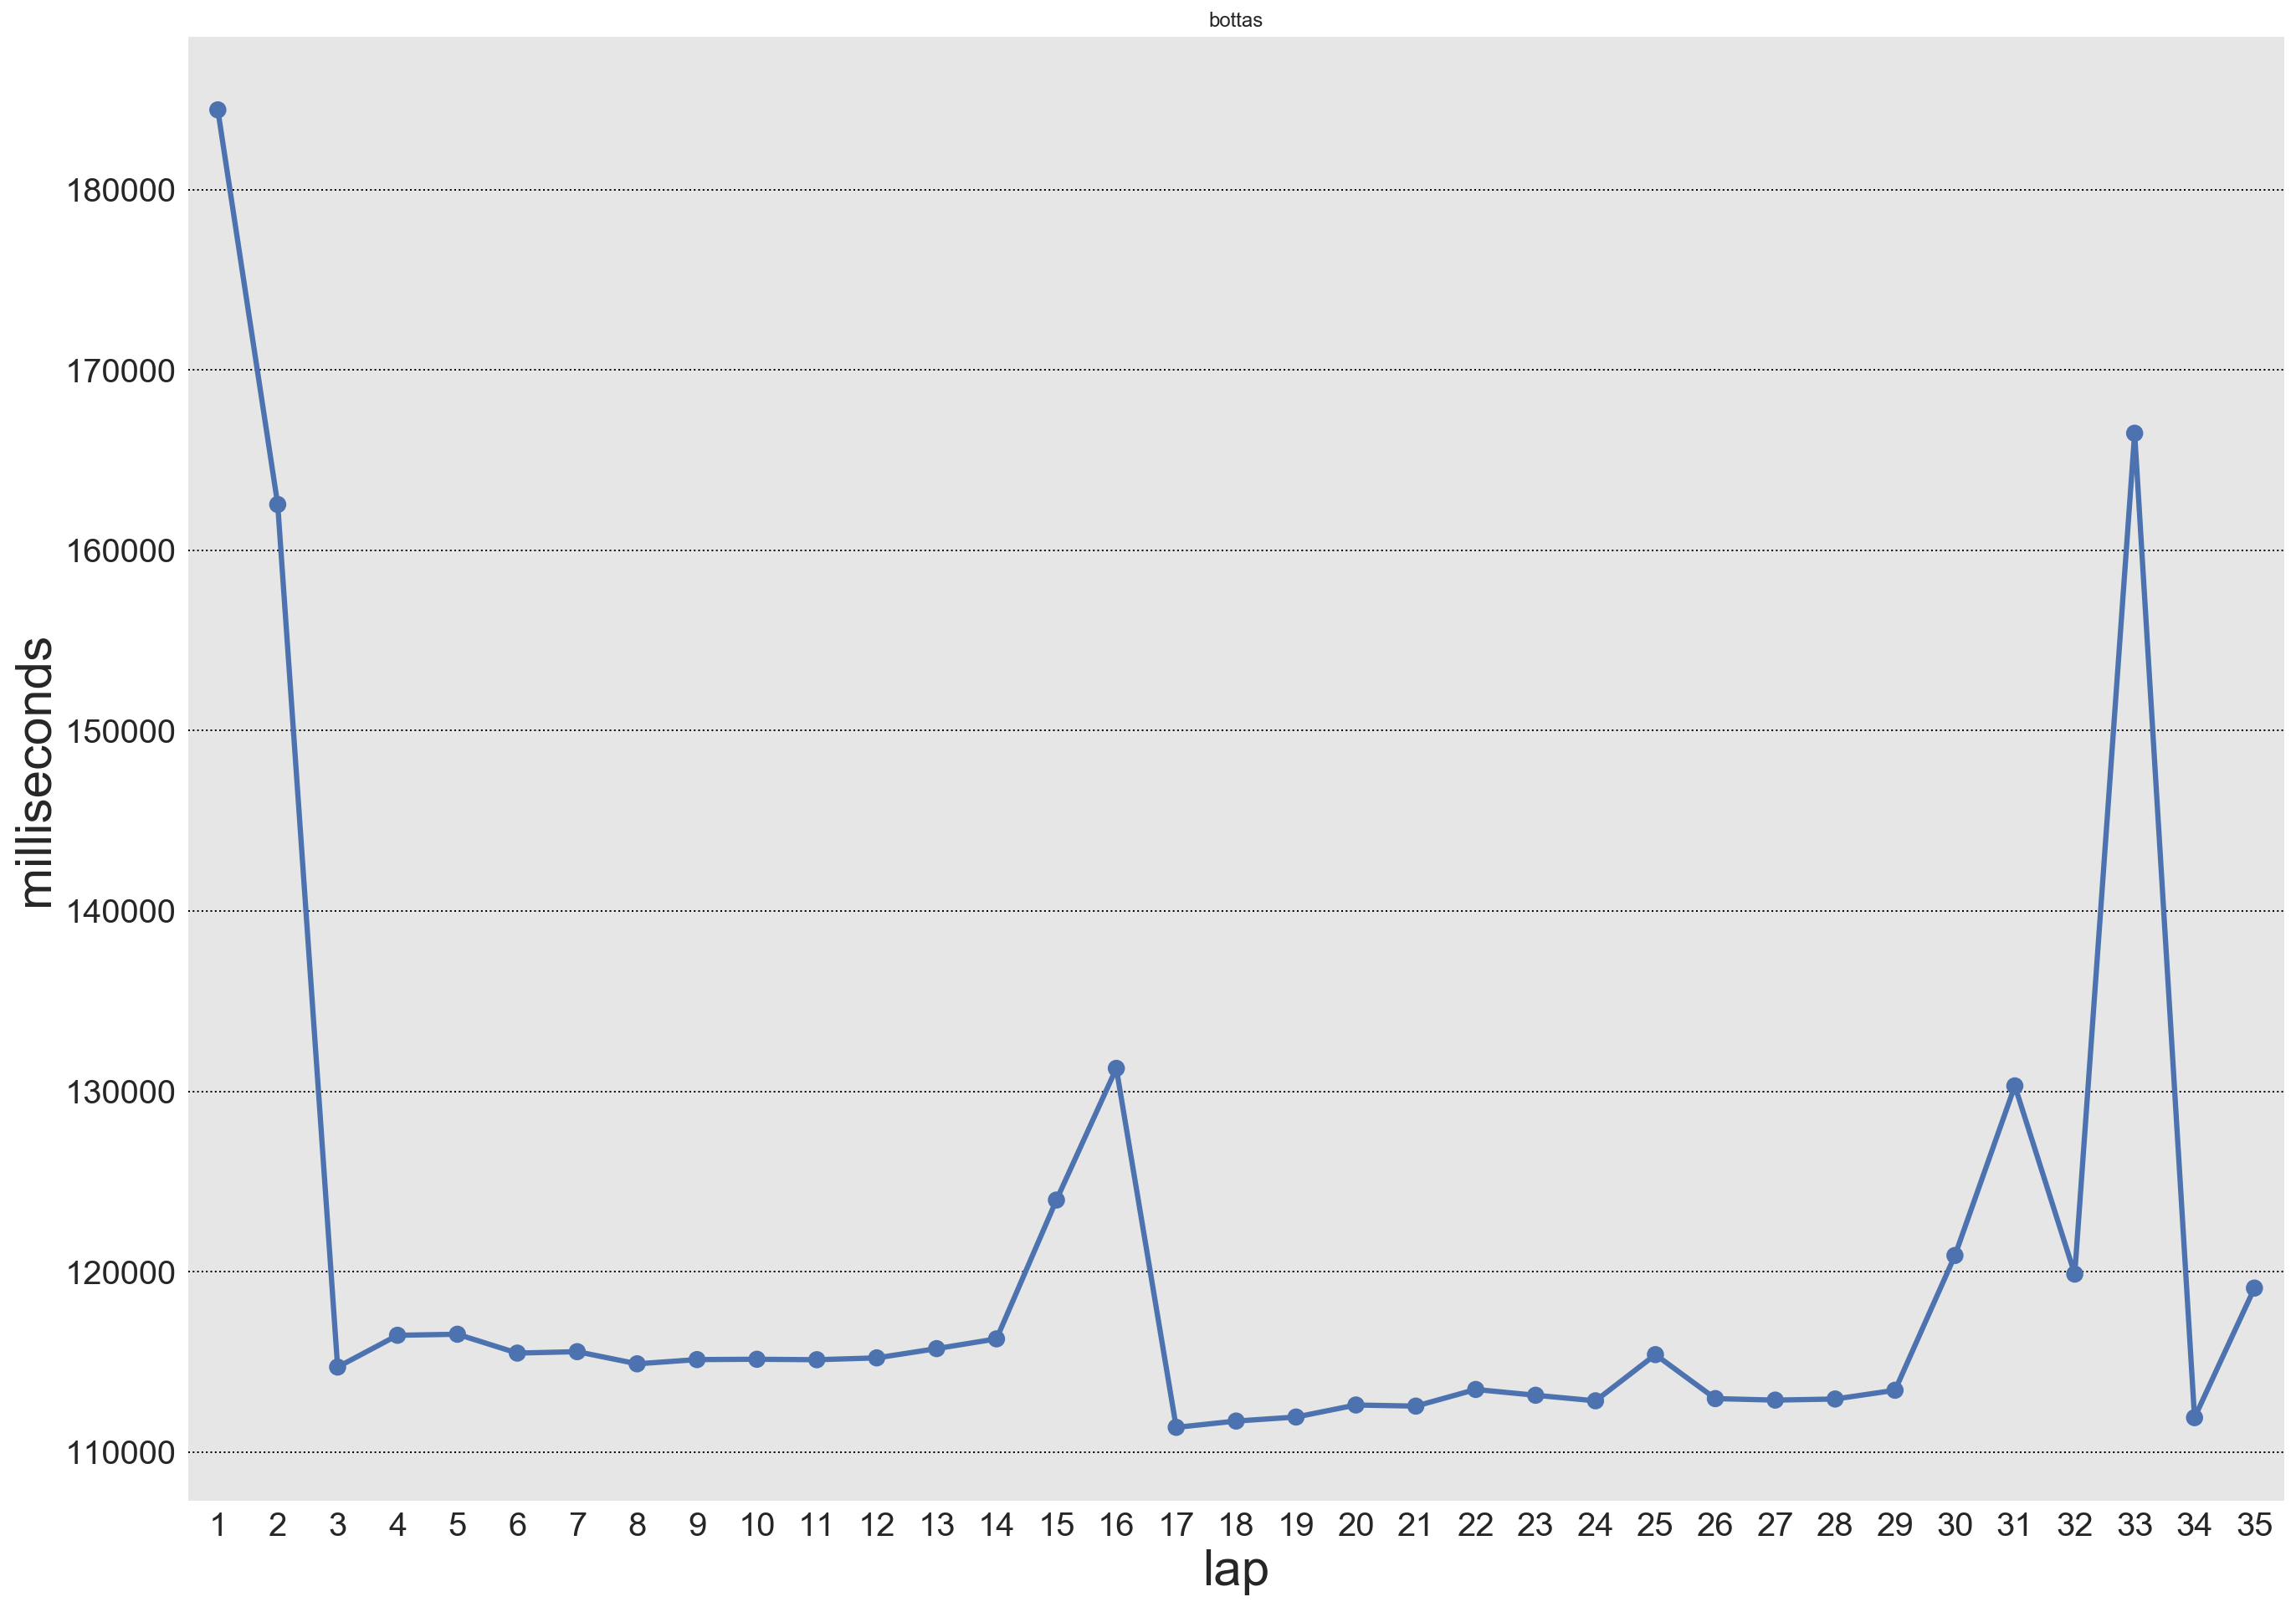

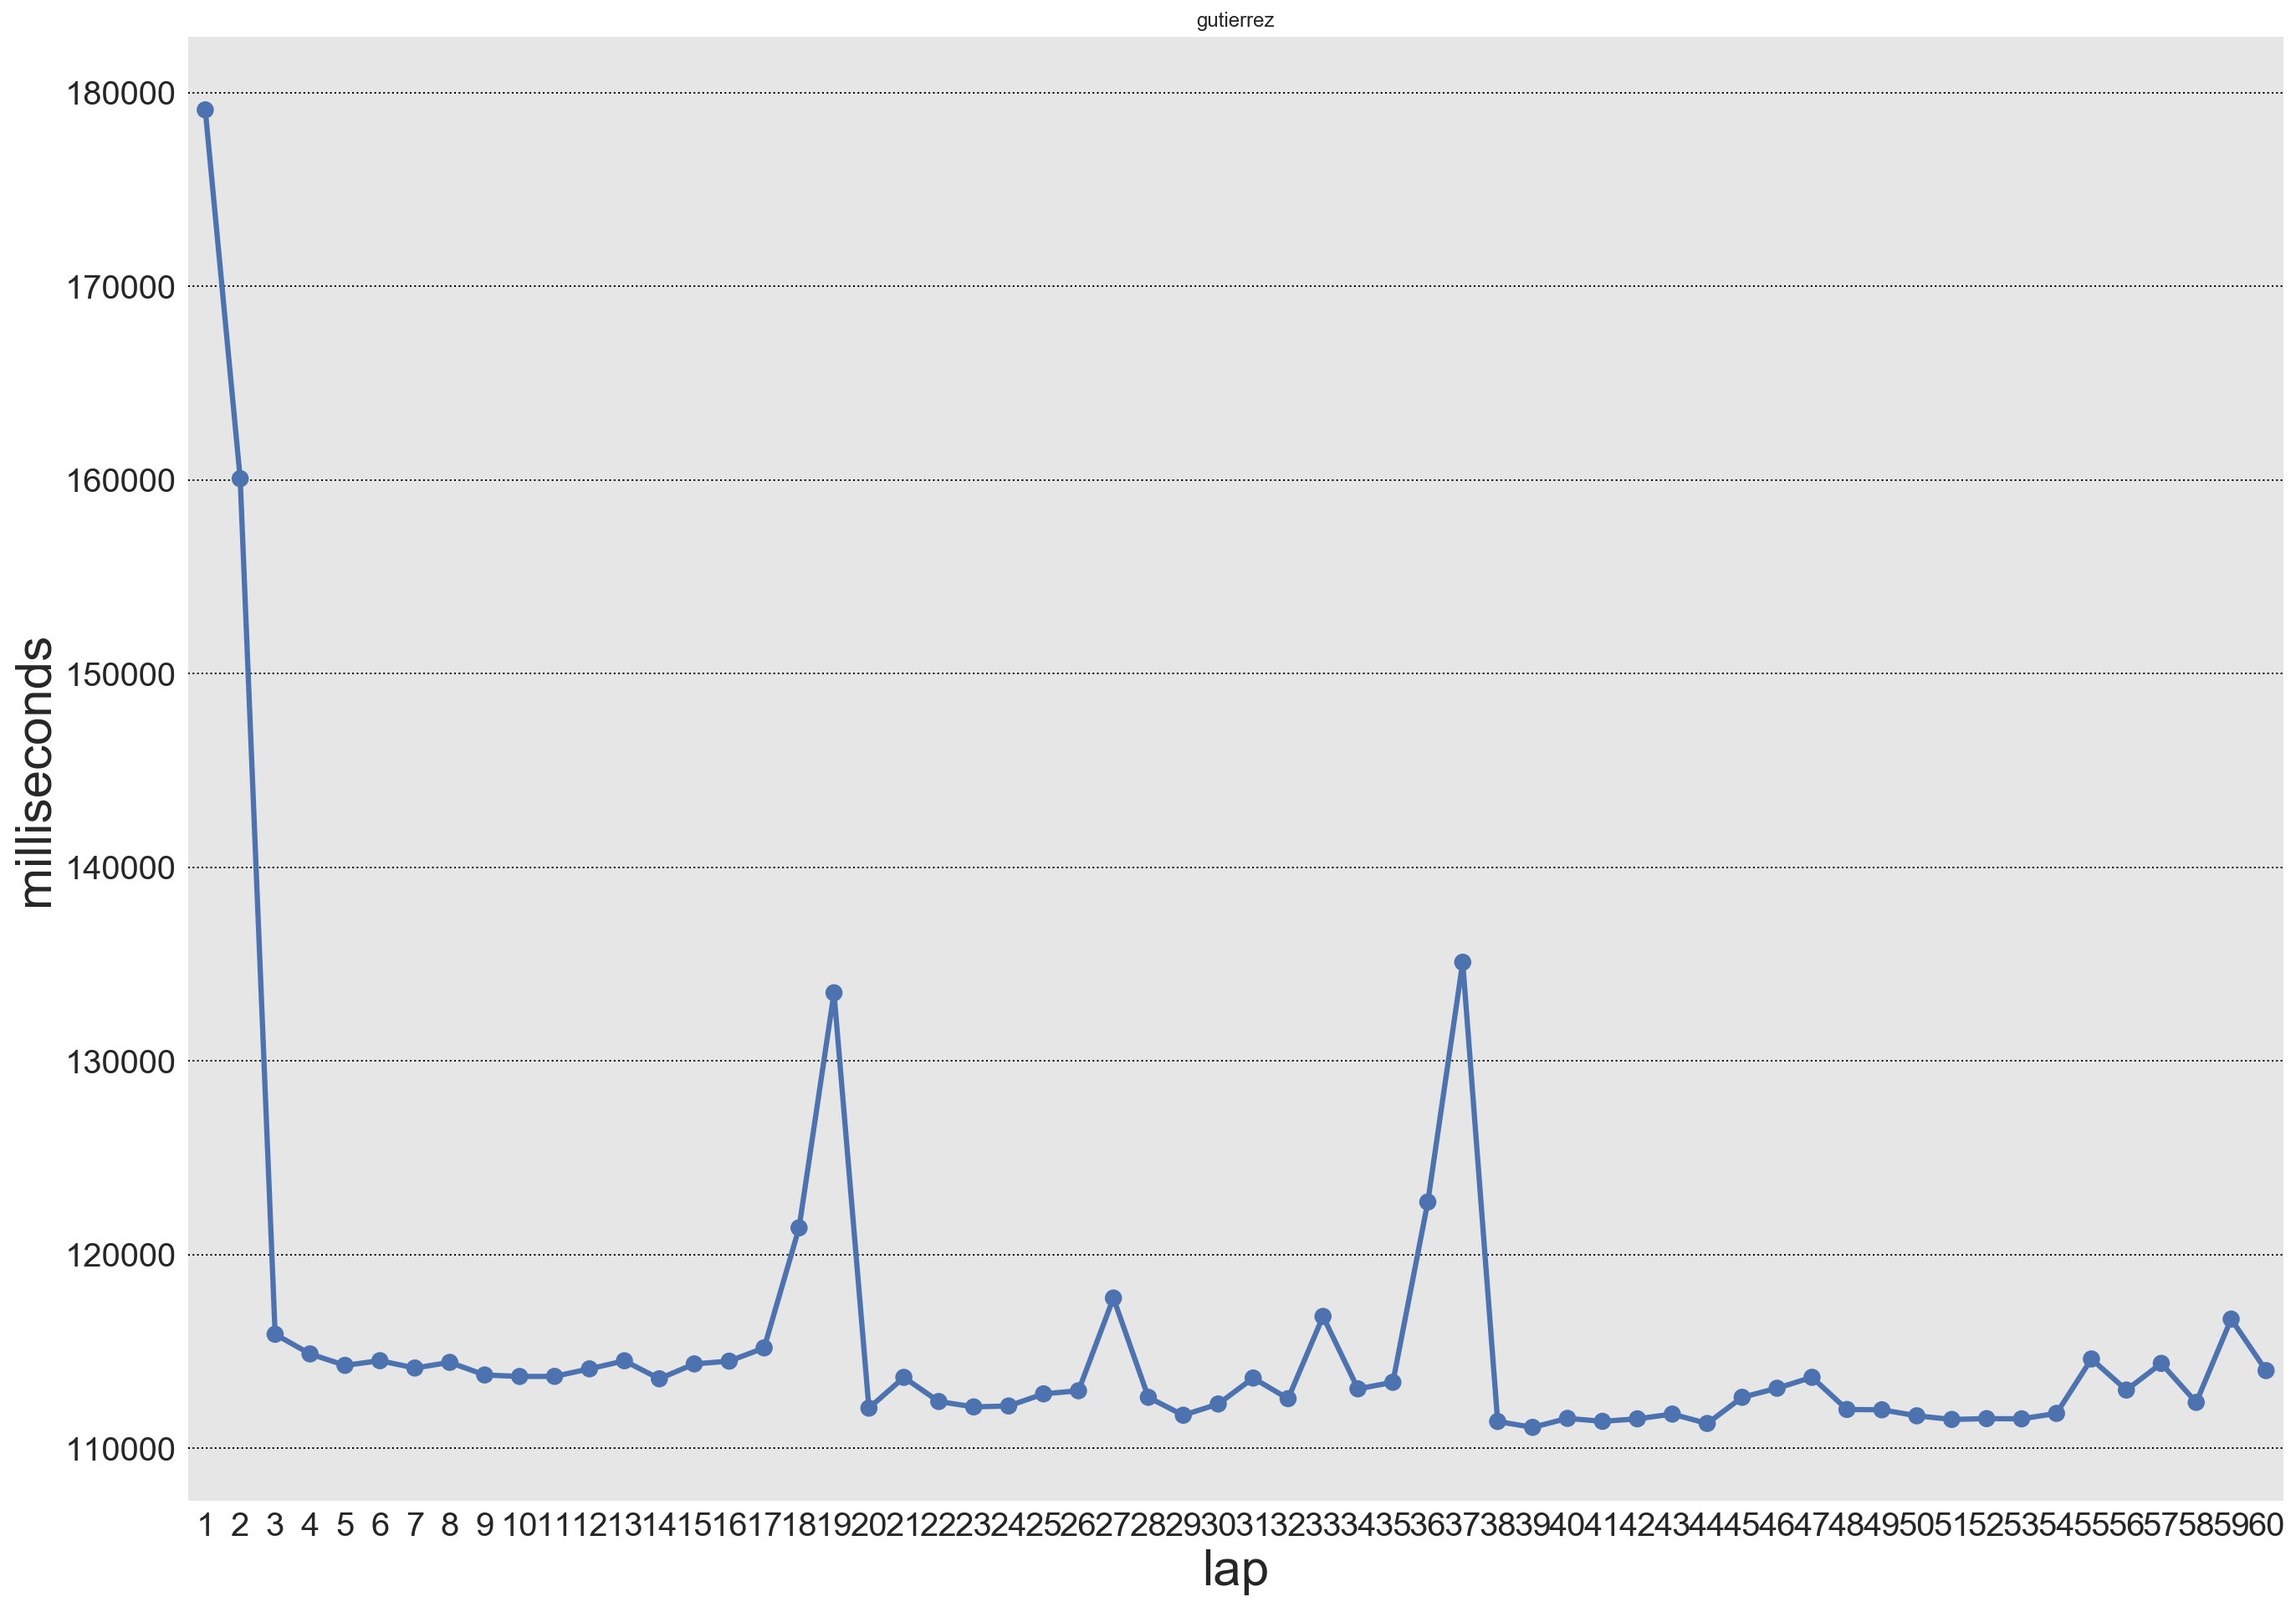

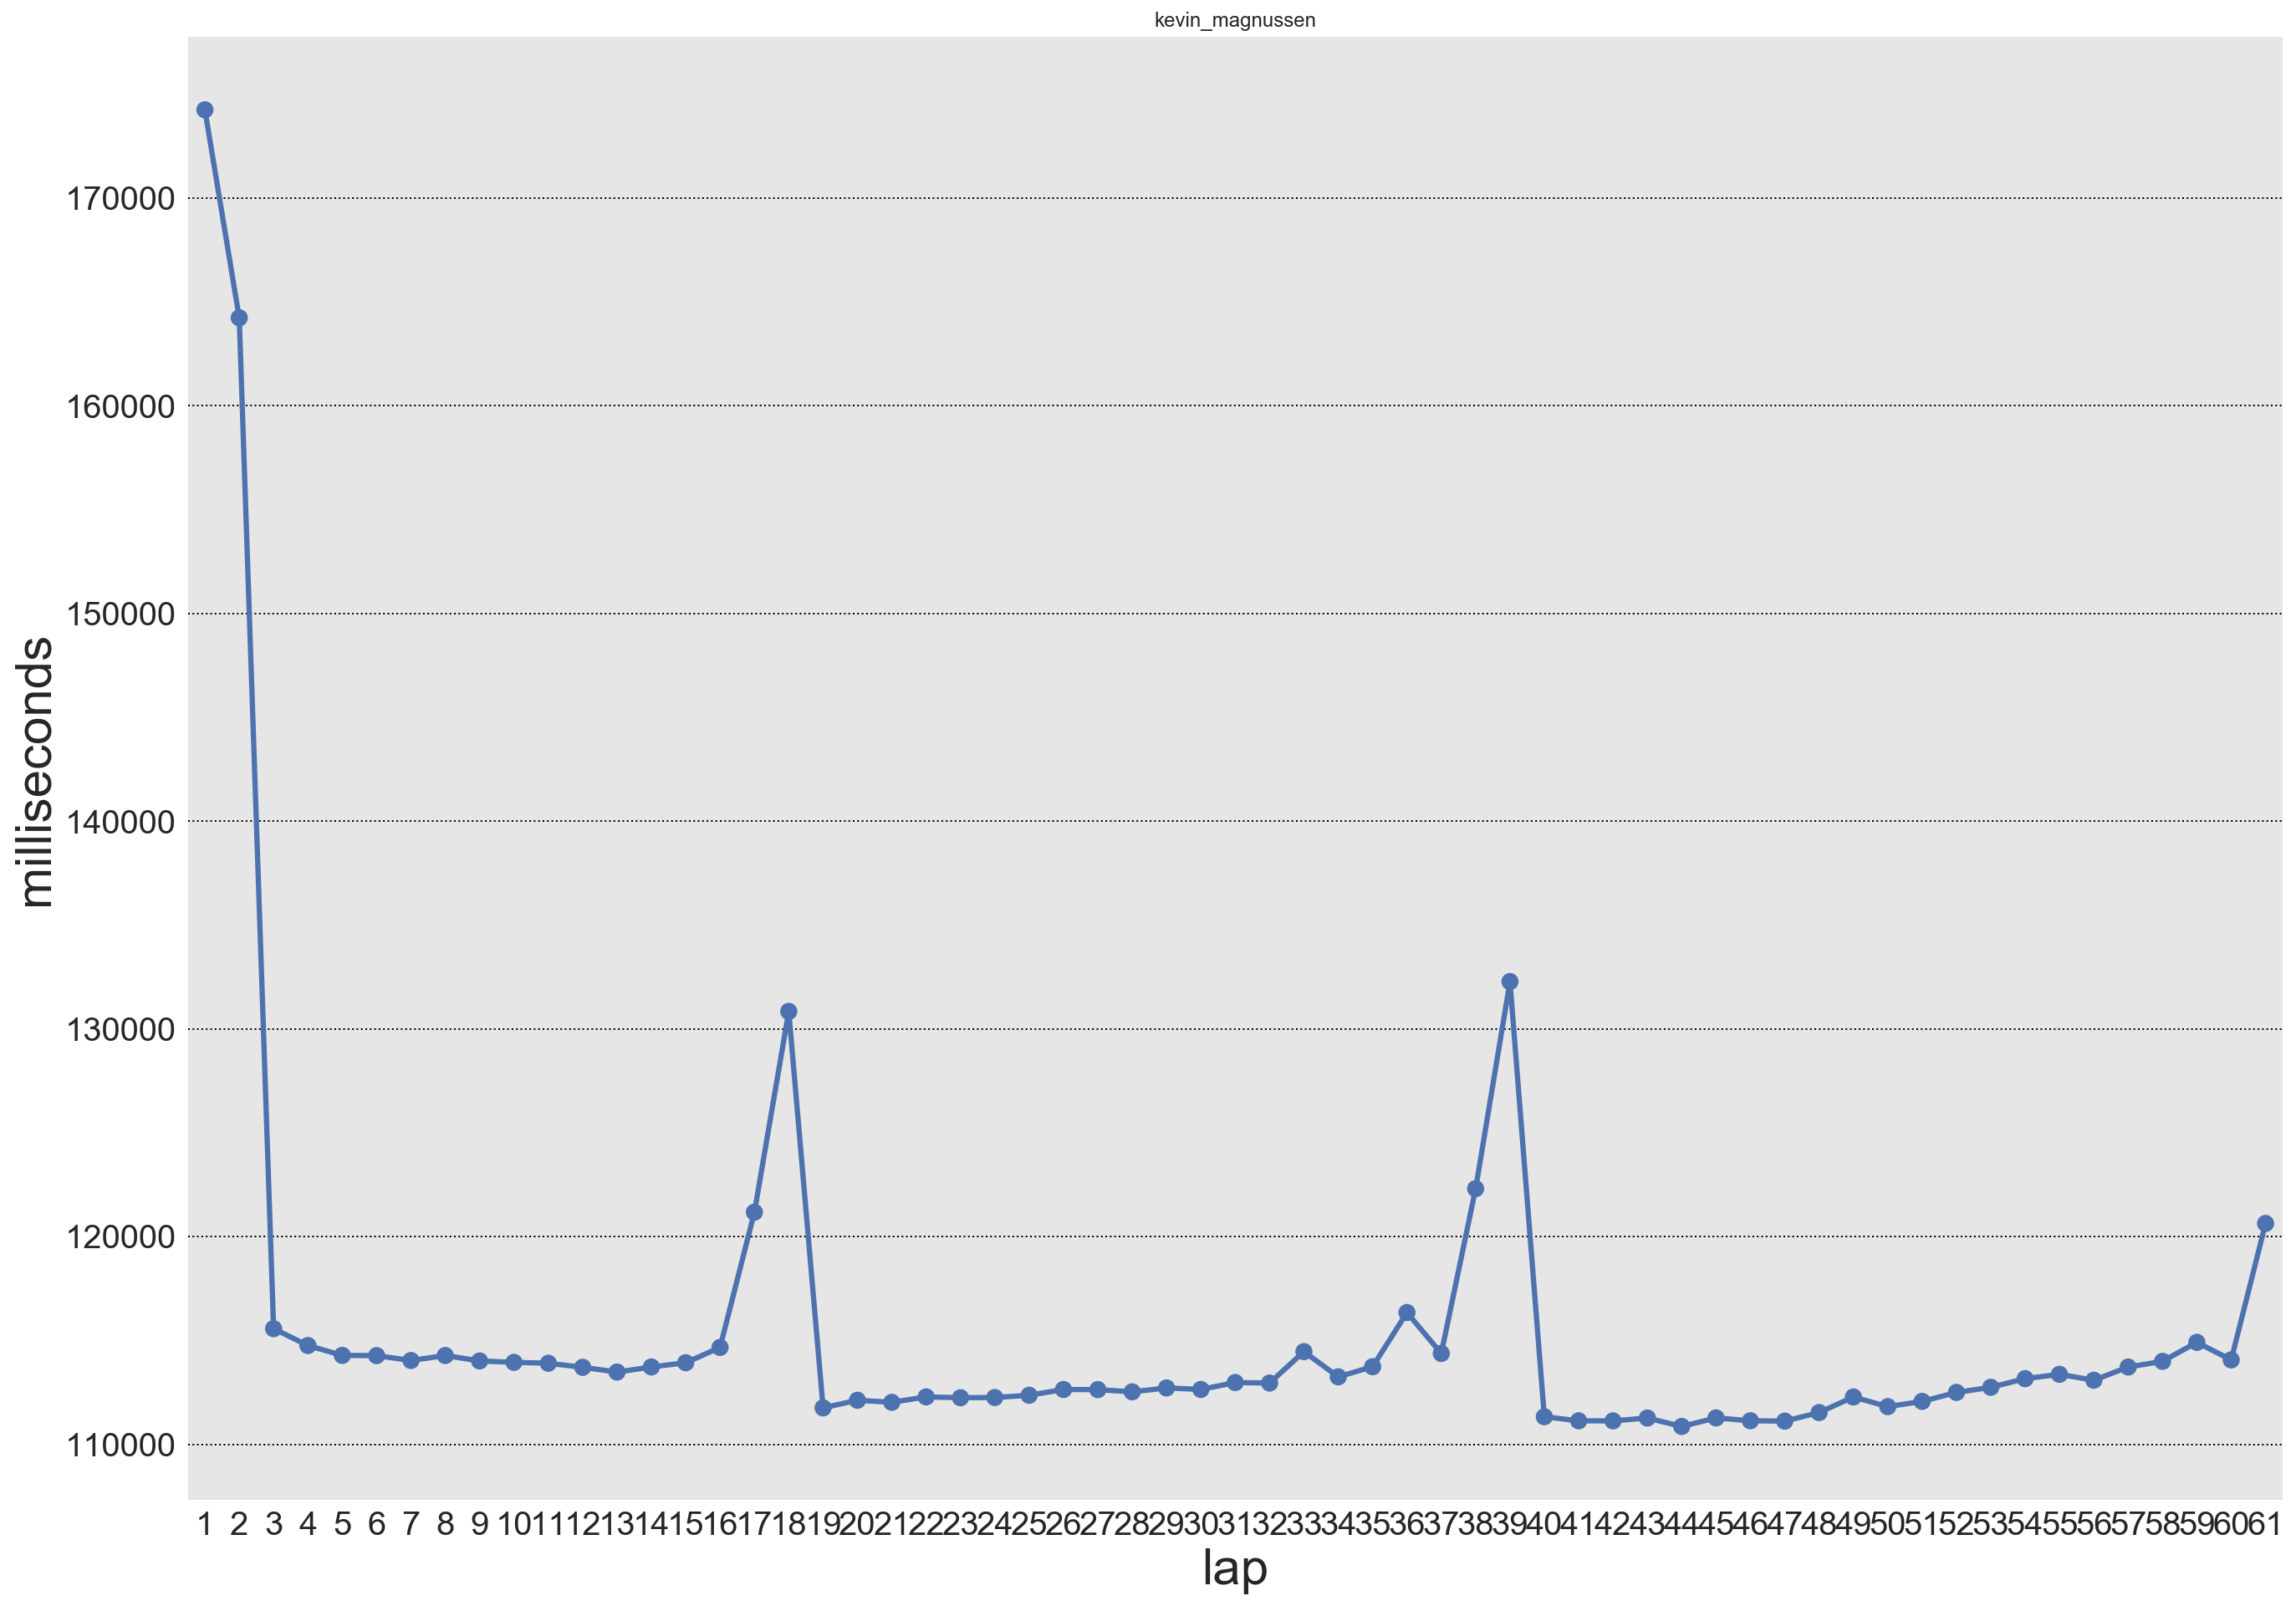

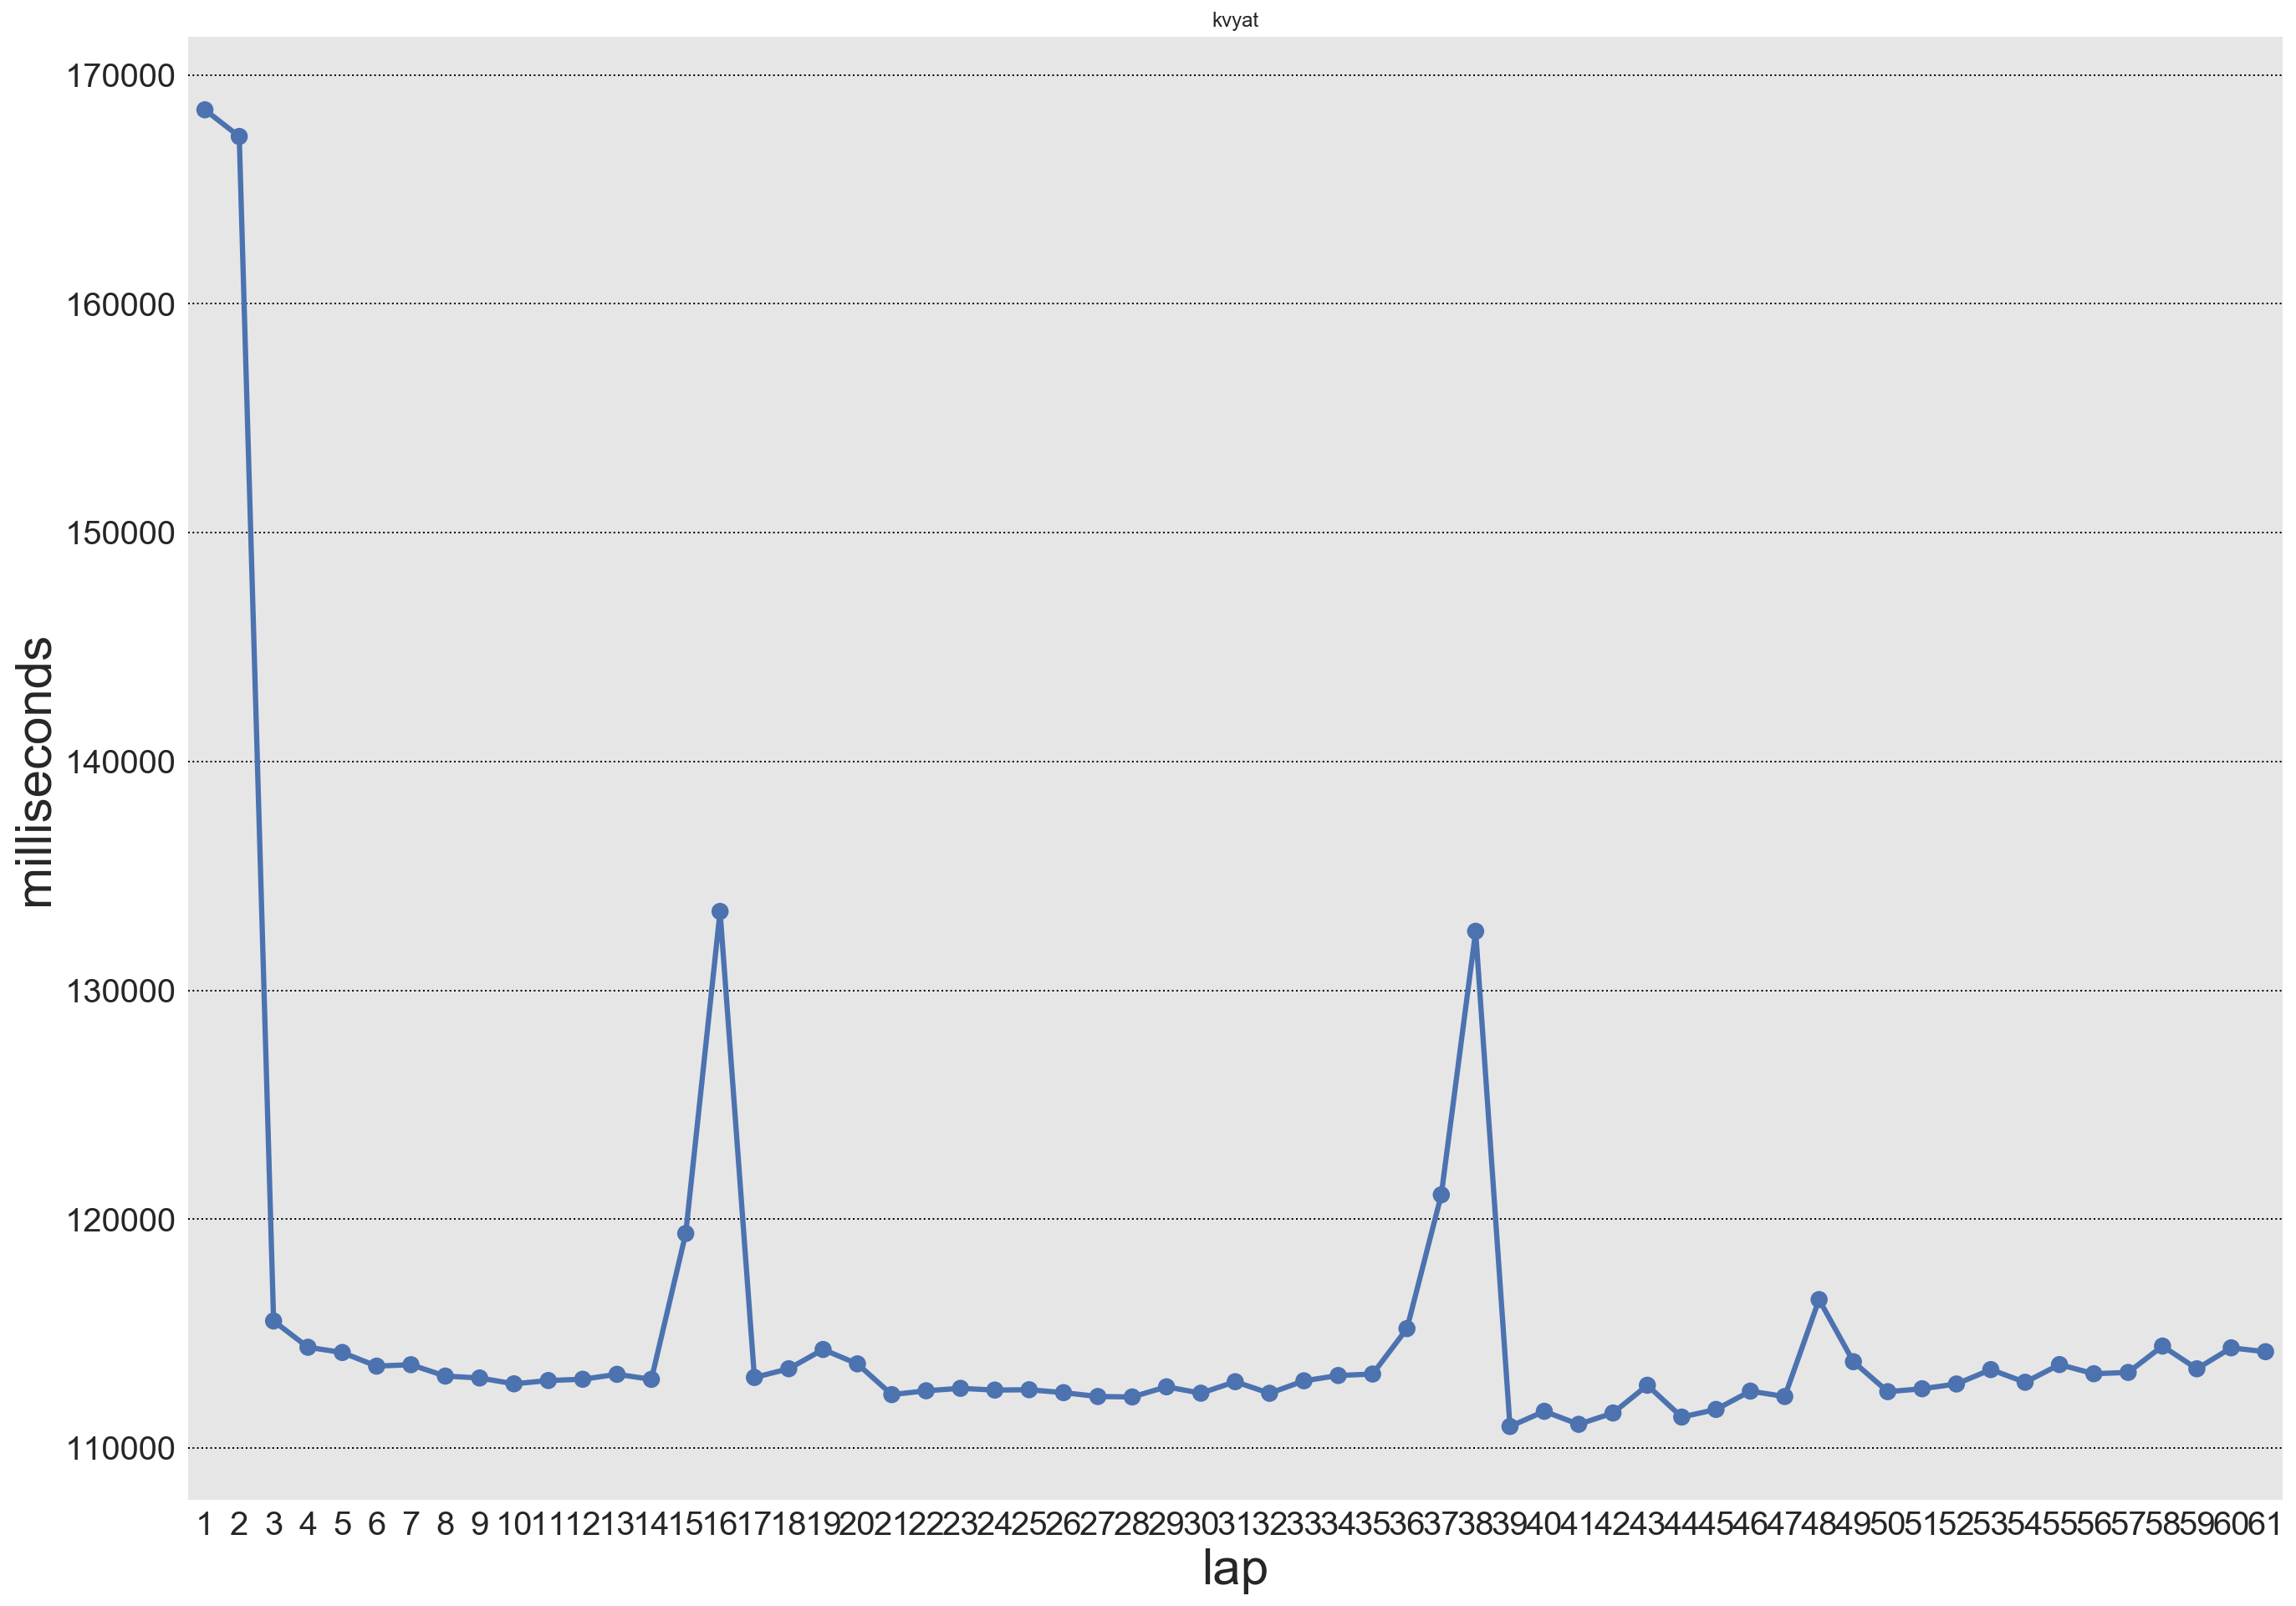

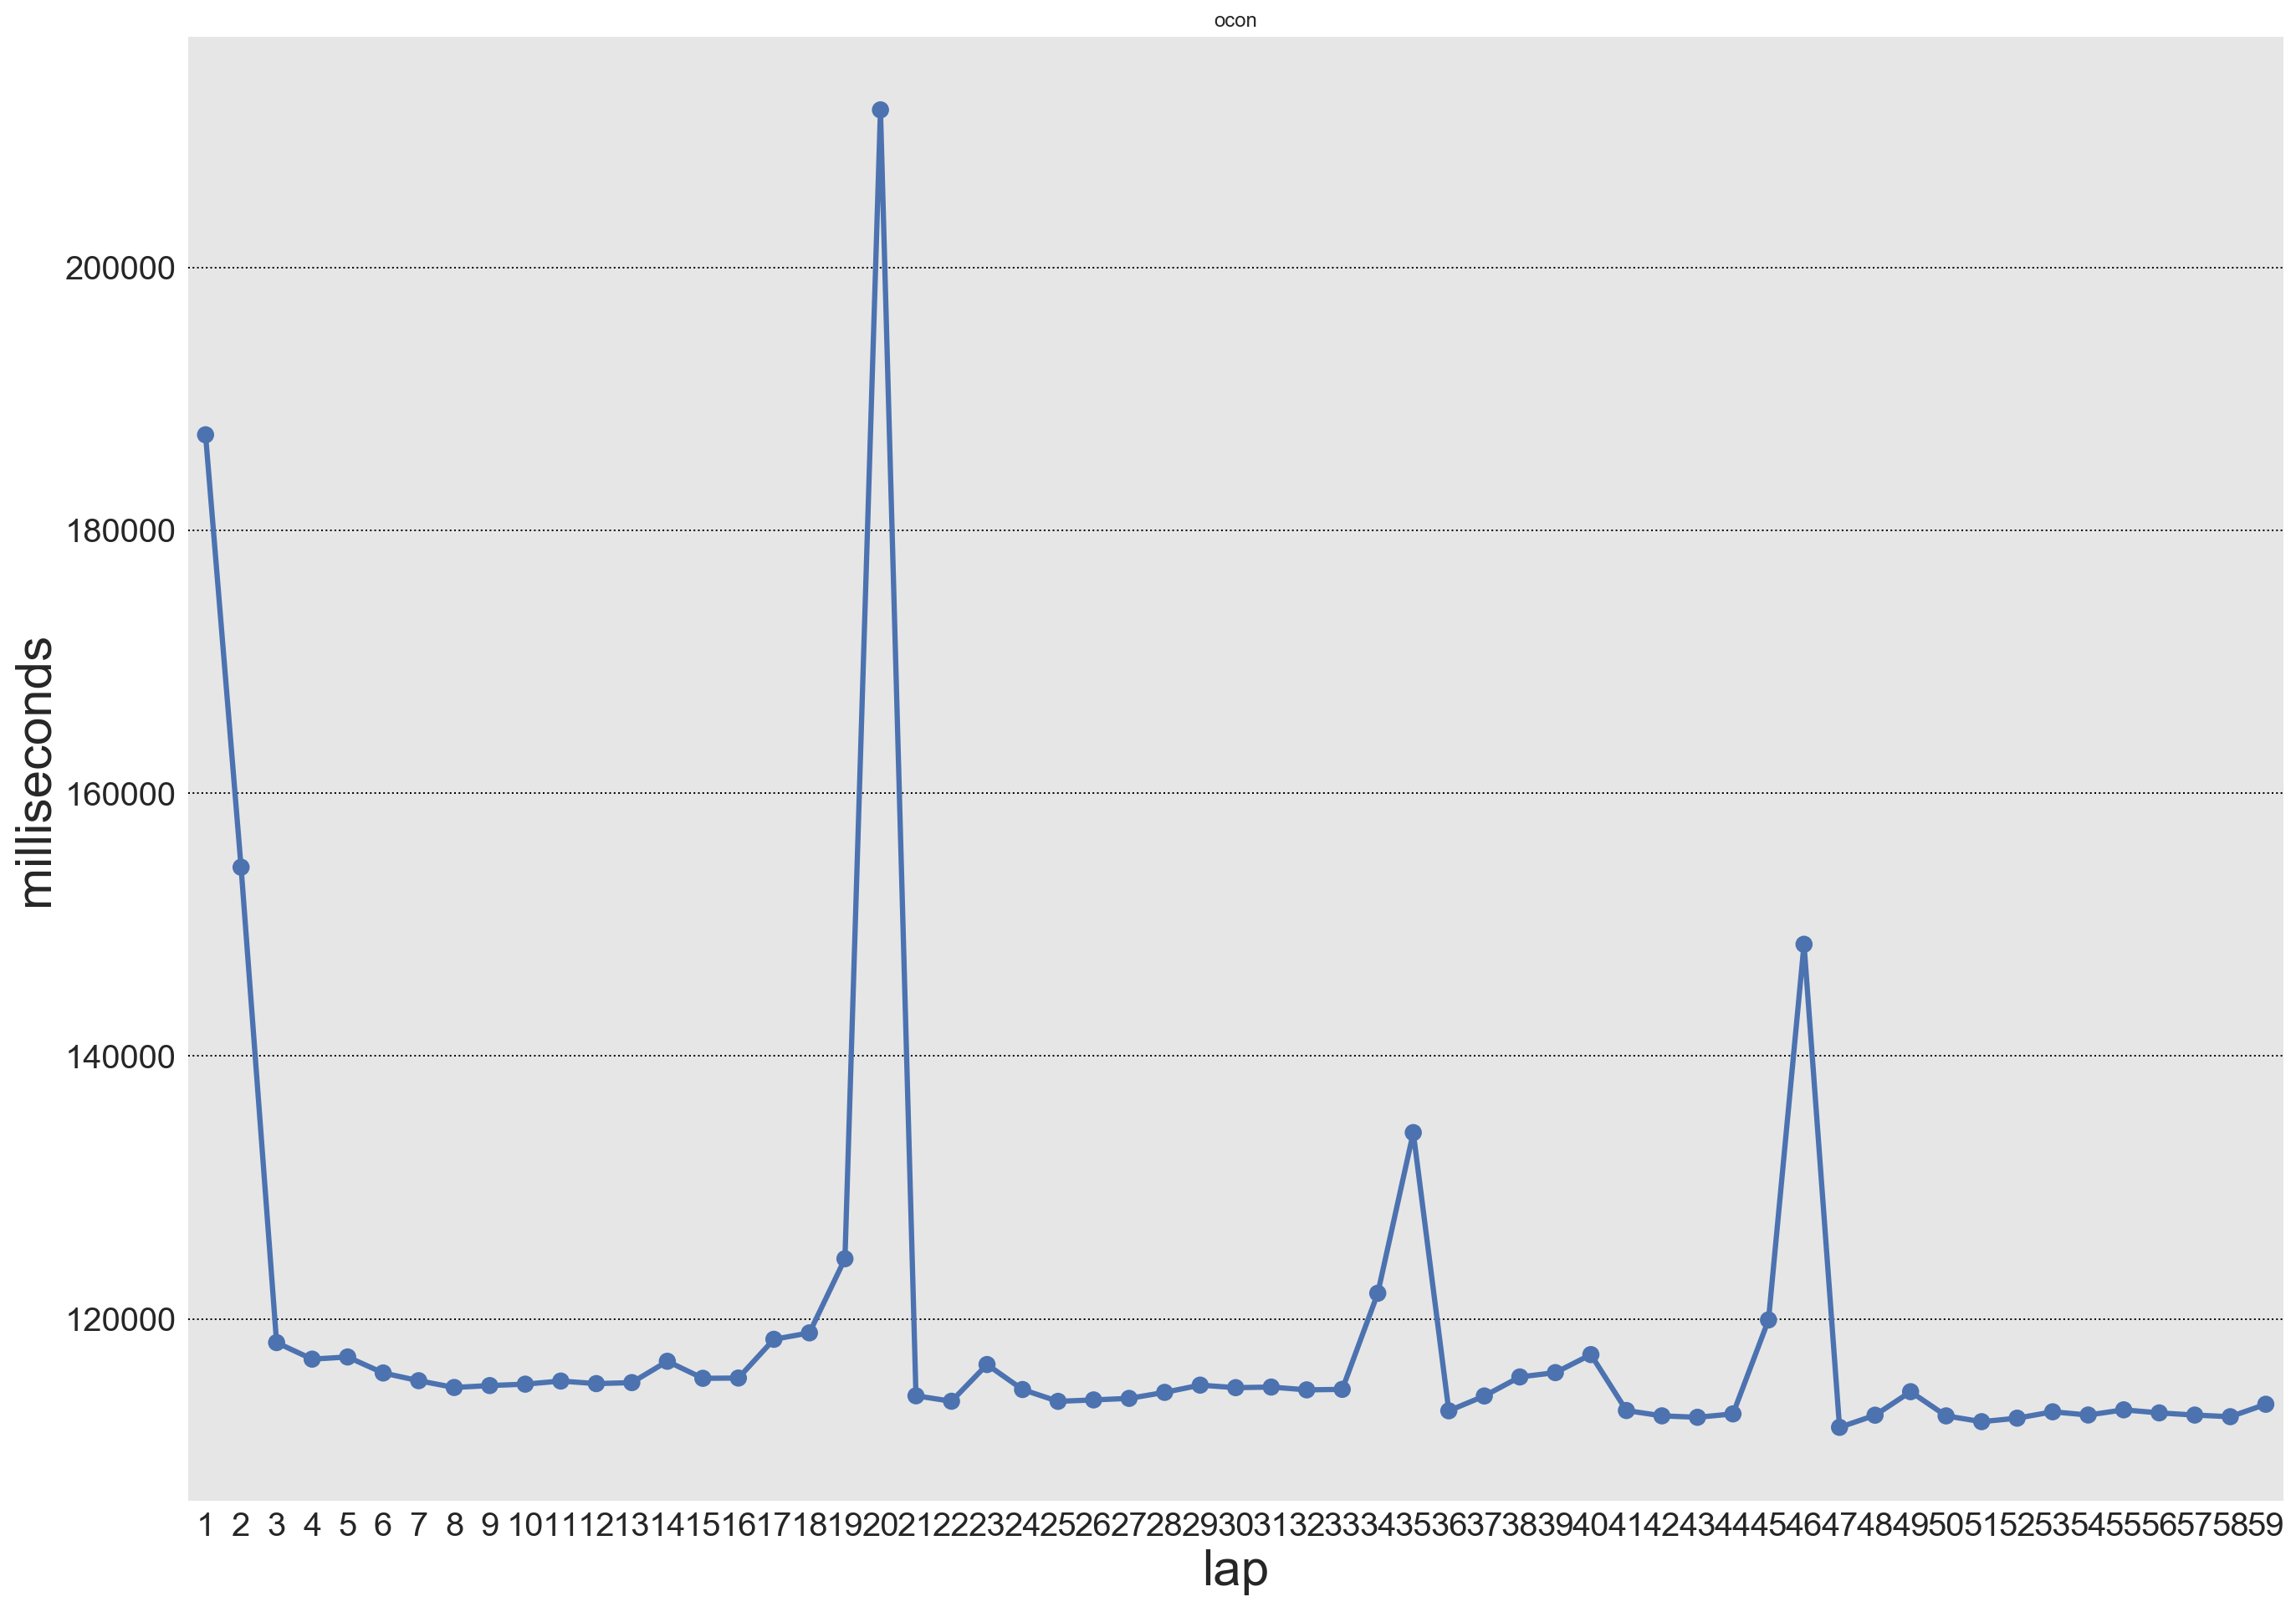

In [52]:
laptime_chart(SGP_2016, ylabel = 'Lap Time(s)', xlabel = "Lap Time(s)")

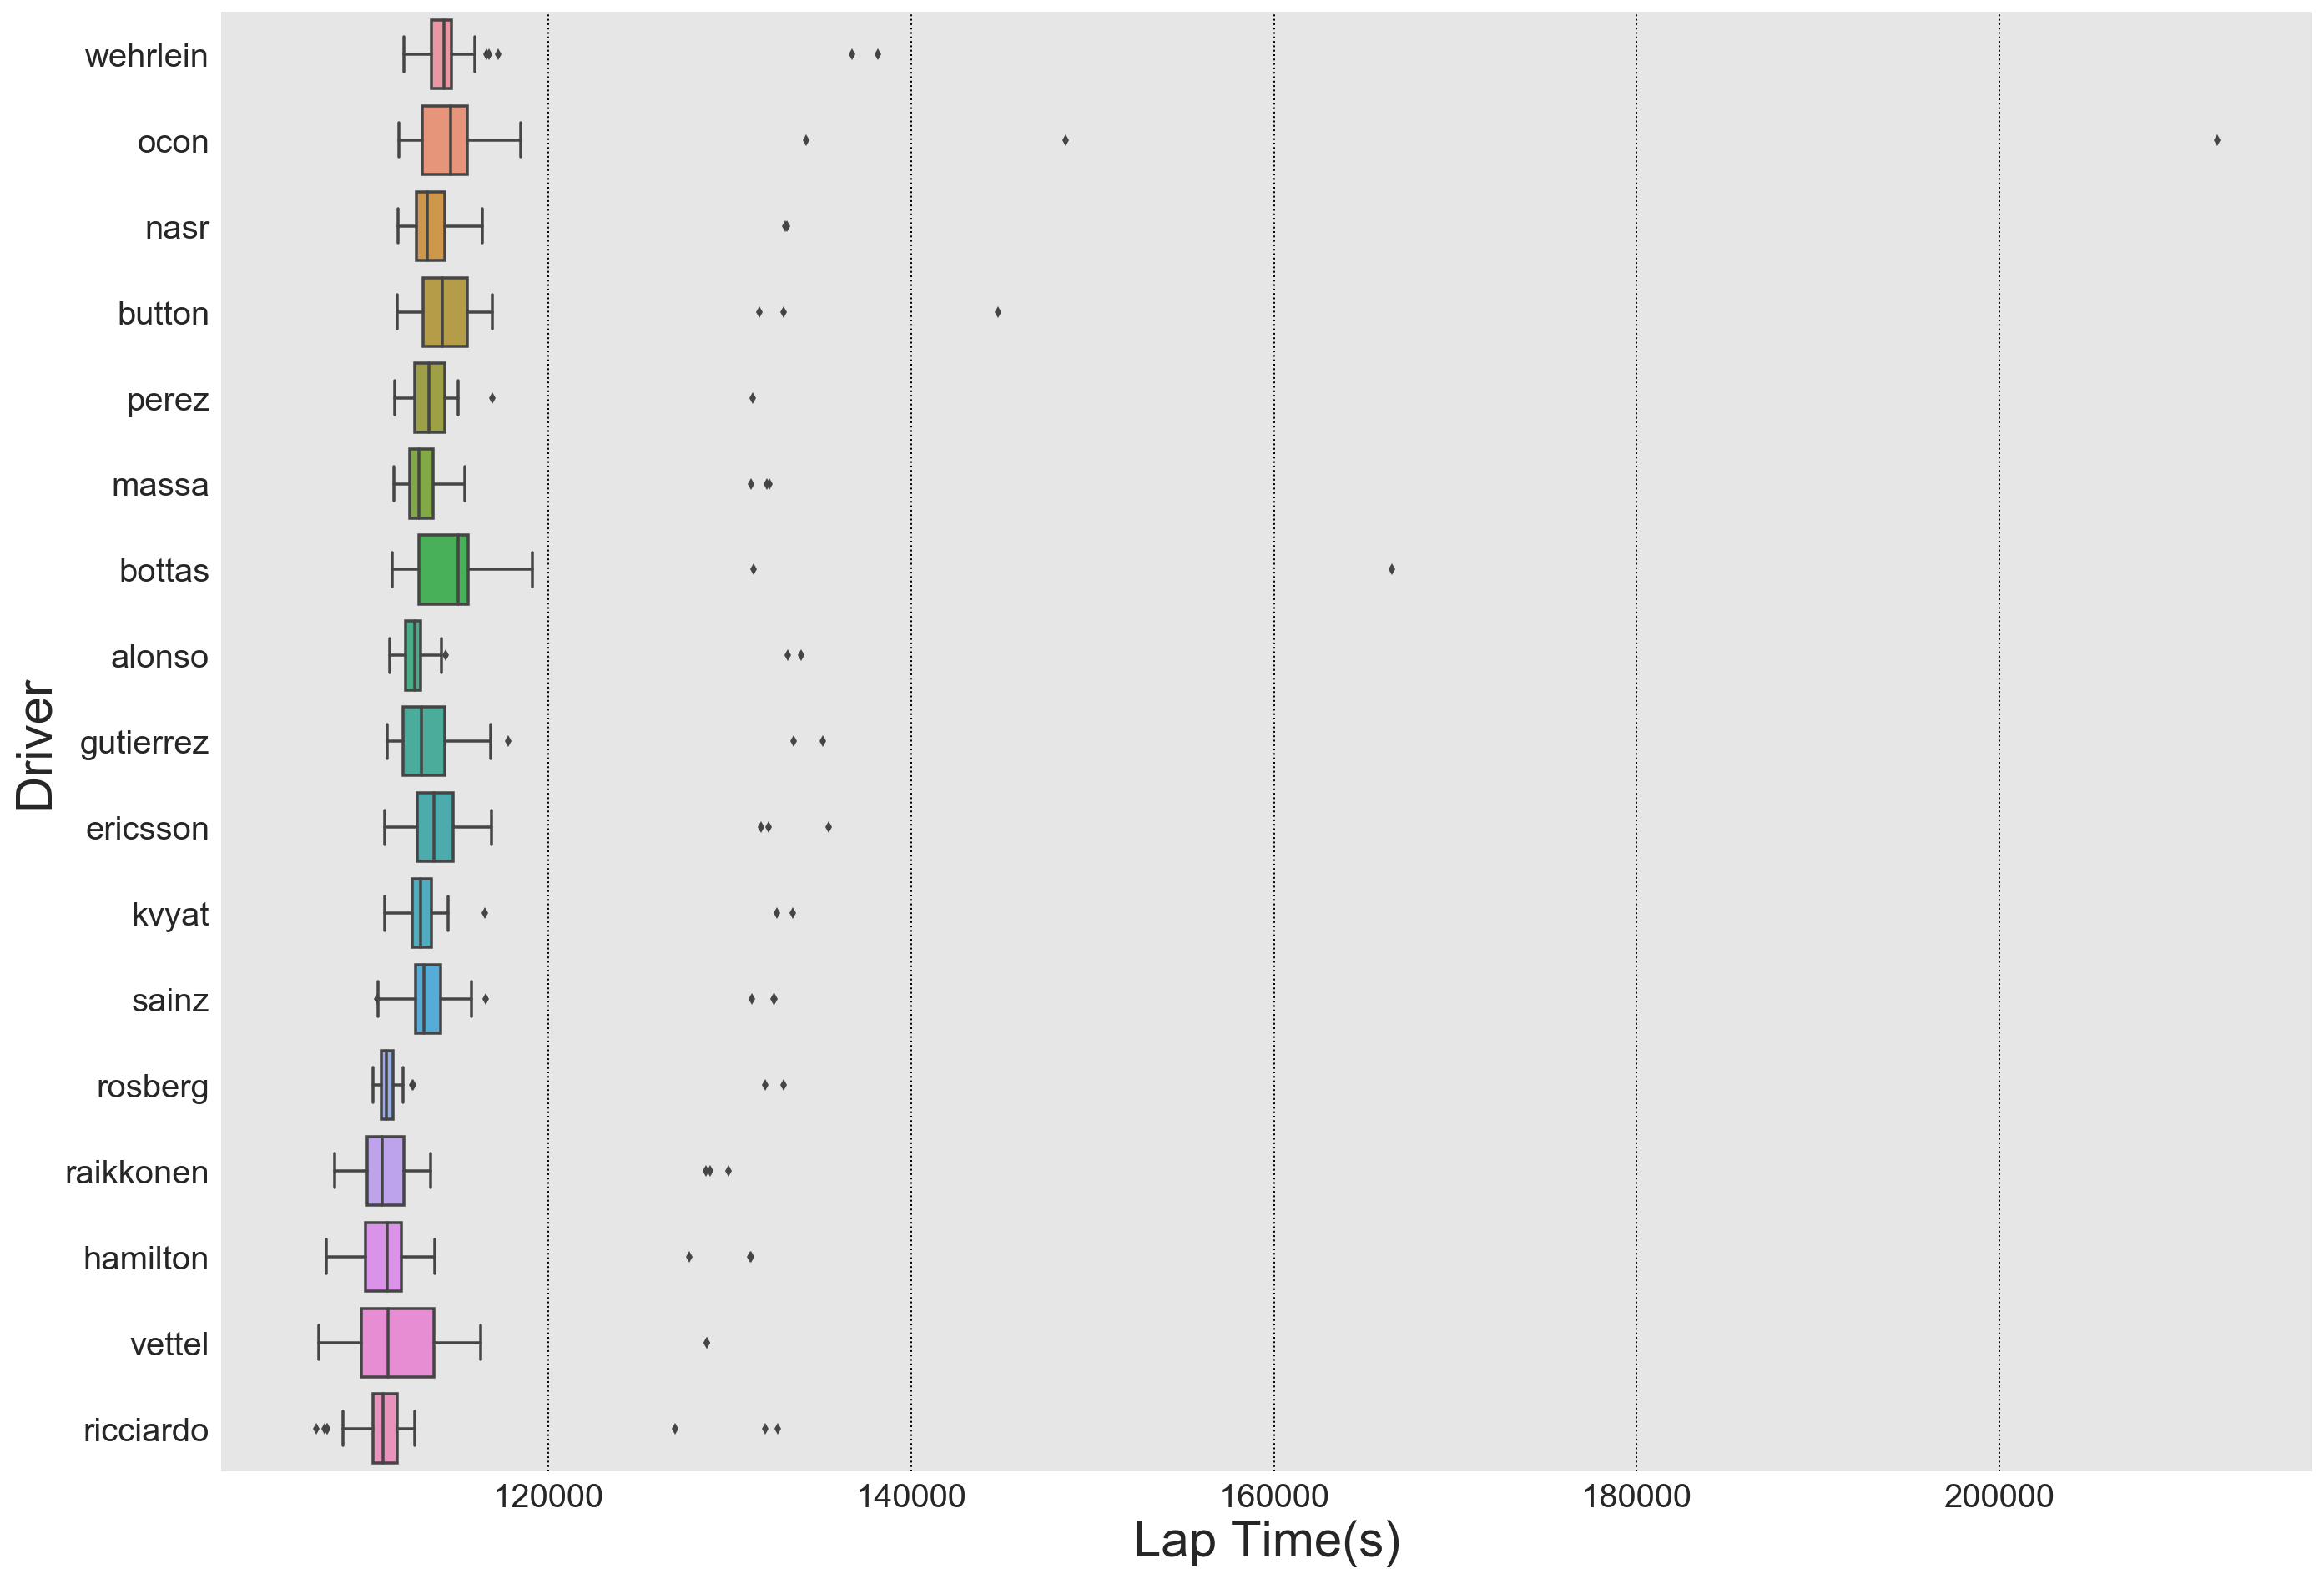

In [111]:
time_box_plot(SGP_2016, SGP_2016_tyres, df_pitStops, df_status, time_field='milliseconds', id_field='driverRef', title = '', ylabel = 'Driver', xlabel = "Lap Time(s)")